# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.1
t₁ = 5

#D₀ = 1
tolnl = 1e-4
itMax = 20
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1;

In [3]:
function heatflow(T, fD::Function, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            # if iter == 1
            #     println("current D: ", D)
            # end
            
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [4]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Creating a reference dataset with a fake law

Let's assume that $D$ is a function of time

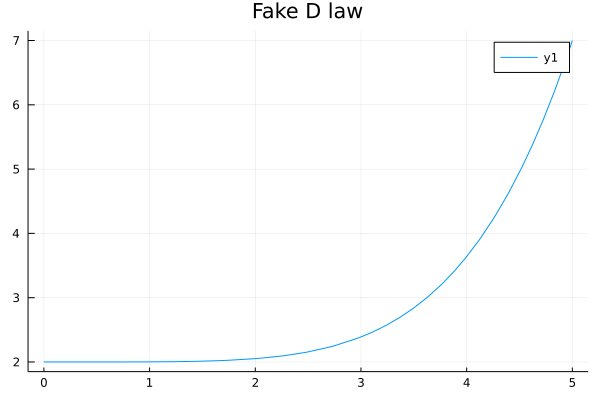

In [42]:
D_max = 10
D_min = 0

fakeD(t) = 1 * (2 + t^5 / t₁^4)

plot(fakeD, 0, t₁, title="Fake D law")

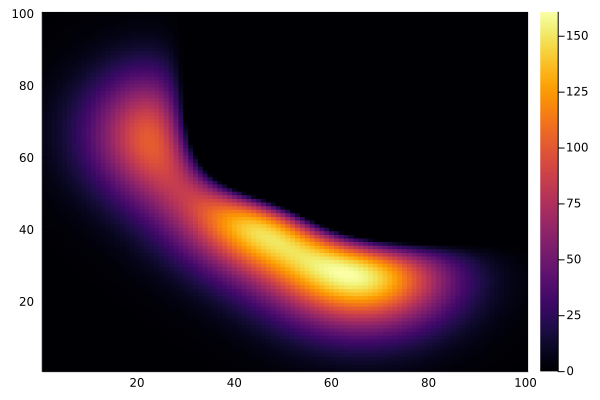

In [111]:
function truncated_gaussian(i₀, j₀, off) 
    
    M = [ 250 * exp( - ( (i - i₀)^2 + (j - j₀)^2 ) / 300 ) - off for i in 1:nx, j in 1:ny ]
    max.(0., M)
    
end

#T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

#T₀ = [ -(i - nx/2)^2 - (j - ny/.6)^2 + 40000 for i in 1:nx, j in 1:ny ]
#T₀ = max.(0., T₀)

T₀ = 1.5 * truncated_gaussian(nx/2, ny/2, 0) + 
     1 * truncated_gaussian(nx/3, ny/1.5, 0) +
     1 * truncated_gaussian(nx/1.5, ny/3, 0) - 
     4 * truncated_gaussian(nx/1.5, ny/2, 0) - 
     2 * truncated_gaussian(nx/2, ny/1.5, 0)

T₀ = max.(0., T₀)

heatmap(T₀, clim=(0, maximum(T₀)))

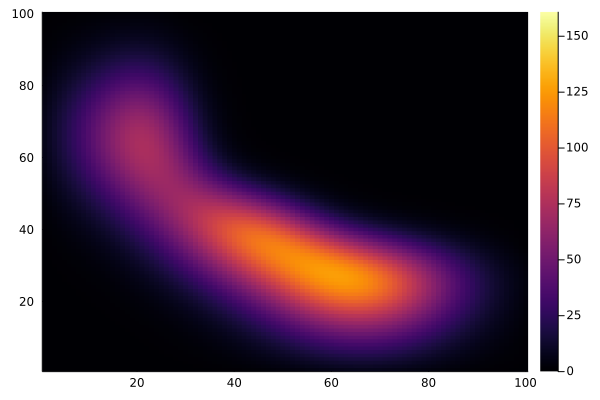

In [112]:
p = (Δx, Δy, Δt, t₁)

T₁ = copy(T₀)
T₁ = heatflow(T₁, fakeD, p, 1e-2)

heatmap(T₁, clim=(0, maximum(T₀)))

In [113]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

10.095895612117783

## Using a neural network to learn D

Now, let's try to reproduce `fakeD()` with a NN.

In [114]:
function heatflow_NN(T, uD, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            #println(D)
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [115]:
sqnorm(x) = sum(abs2, x)

function loss(T, UD, p, λ=1)

    T = heatflow_NN(T, UD, p)
    l_cost = sqrt(Flux.Losses.mse(T, T₁; agg=mean))
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss (generic function with 2 methods)

In [121]:
# Patch suggested by Michael Abbott needed in order to correctly retrieve gradients
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)
    sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

    UD = Chain(
        Dense(1,10, initb=Flux.glorot_normal), 
        #BatchNorm(10, ),
        Dense(10, 5, x->tanh.(x), initb =Flux.glorot_normal), 
        Dense(5, 5, x->tanh.(x), initb=Flux.glorot_normal),
        #BatchNorm(5, leakyrelu),
        Dense(5,1, relu, initb = Flux.zeros) 
    )
    
    #UD = Chain(
    #    Dense(1,5,initb = Flux.glorot_normal), 
    #    Dense(5, 5, x->tanh.(x), initb = Flux.glorot_normal),
    #    Dense(5, 1, relu, initb = Flux.glorot_normal)
    #)
    
    
    opt = ADAM(1.0e-3)
    #opt = Descent(0.1)
    
    losses = []
    @epochs 150 hybrid_train!(loss, UD, p, opt, losses)
    
    return UD, losses
    
end

function hybrid_train!(loss, UD, p, opt, losses)
    
    T = T₀
    θ = Flux.params(UD)
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    println("Current loss: ", loss_uD)
    println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))

    #for p in θ
    #    println("Gradients ∇_uD[p]: ", ∇_uD[p])
    #end
    
    #println("Values of NN: ", UD([0., .5, 1.]'))
    #all_times = LinRange(0, t₁, 1000)
    #plot(all_times, UD(all_times')')
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
    
end

hybrid_train! (generic function with 1 method)

In [122]:
UD_trained, losses = train(loss, p)

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.632239179438567
Current parameter:Params([Float32[-0.34185717; -0.13691202; -0.32118985; -0.7050594; -0.17649336; -0.6595102; -0.27306968; 0.5064735; -0.069123454; 0.32869735], Float32[0.09644883, -1.1158551, -1.0322126, 0.22610788, 0.15555185, -0.18428287, -0.6894437, 0.69797105, -0.28847498, 0.42772412], Float32[-0.36183968 -0.09541726 -0.5774012 -0.32581192 -0.30923885 -0.45692745 0.25381055 -0.54785466 -0.5127092 0.44071507; -0.34733993 0.24842498 -0.6101855 -0.42716047 0.19535926 -0.098317236 -0.1300677 -0.50491035 0.59820014 0.23411116; 0.1964674 0.108693644 -0.35733485 -0.00949866 0.11669783 0.58346653 -0.0005969742 0.30557752 -0.2209705 -0.22360583; 0.10958767 0.36113366 0.39915922 0.013010993 -0.5550987 -0.3208466 -0.029497374 0.60364604 -0.39530355 -0.24409491; 0.10691765 0.572028 -0.26744854 0.033914894 -0.594104 0.09162763 -0.42783225 0.011050885 -0.37407804 0.04055791], Float32[0.34448633, -0.4986879, 0.6304558, 0.08281171, 0.078796126], Float32[0.71501577 

┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.459348963306445
Current parameter:Params([Float32[-0.34085718; -0.13791202; -0.32018986; -0.7040594; -0.17749336; -0.6605102; -0.2720697; 0.50747347; -0.07012346; 0.32769737], Float32[0.09744883, -1.1168551, -1.0312126, 0.22710788, 0.15455185, -0.18528287, -0.6884437, 0.69897103, -0.28947496, 0.42672414], Float32[-0.36283967 -0.09641726 -0.5784012 -0.3268119 -0.30823886 -0.45792744 0.25281057 -0.5468547 -0.5137092 0.44171506; -0.34633994 0.24942498 -0.6091855 -0.42616048 0.19635926 -0.09731723 -0.1290677 -0.50591034 0.5992001 0.23311116; 0.1974674 0.10969365 -0.35633487 -0.00849866 0.117697835 0.5844665 0.0004030257 0.30457753 -0.2199705 -0.22460583; 0.10858767 0.36013368 0.39815924 0.0120109925 -0.5560987 -0.32184657 -0.030497374 0.604646 -0.39630353 -0.2430949; 0.10791765 0.57302797 -0.26644856 0.034914892 -0.593104 0.09262763 -0.42683226 0.010050884 -0.37307805 0.03955791], Float32[0.3454863, -0.49968788, 0.6294558, 0.083811715, 0.077796124], Float32[0.7140158 0.5544

┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.289066540141265
Current parameter:Params([Float32[-0.33985695; -0.13891317; -0.31919026; -0.70305914; -0.1784927; -0.66150826; -0.2710701; 0.5084733; -0.07112359; 0.32669768], Float32[0.09844872, -1.1178558, -1.030213, 0.22810777, 0.1535522, -0.18628179, -0.6874443, 0.69997084, -0.29047492, 0.42572454], Float32[-0.36383823 -0.09741678 -0.5794006 -0.32781065 -0.30723998 -0.45892683 0.25181118 -0.5458552 -0.5147088 0.4427144; -0.3453396 0.25042513 -0.6081854 -0.42516008 0.1973602 -0.09631683 -0.12806757 -0.5069106 0.6002005 0.23211096; 0.19845958 0.11068481 -0.3553436 -0.007506317 0.118691325 0.5854588 0.0013943441 0.30358565 -0.21897864 -0.22559743; 0.10758905 0.3591344 0.39716014 0.0110122925 -0.5570978 -0.32284558 -0.031496413 0.6056451 -0.39730293 -0.24209595; 0.10891689 0.5740274 -0.26544926 0.035914216 -0.5921042 0.09362708 -0.42583296 0.0090514505 -0.37207845 0.03855862], Float32[0.3464858, -0.5006879, 0.6284655, 0.08481101, 0.07679677], Float32[0.7130162 0.5536369

┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.12176418989711
Current parameter:Params([Float32[-0.3388564; -0.13991608; -0.31819135; -0.70205843; -0.17949094; -0.6625029; -0.2700712; 0.5094727; -0.07212395; 0.32569852], Float32[0.099448405, -1.1188574, -1.0292143, 0.22910742, 0.15255316, -0.18727878, -0.686446, 0.70097023, -0.2914748, 0.42472562], Float32[-0.36483434 -0.09841547 -0.580399 -0.32880718 -0.3062429 -0.4599252 0.25081286 -0.54485667 -0.51570773 0.44371256; -0.34433872 0.2514255 -0.6071851 -0.42415902 0.19836266 -0.0953158 -0.12706724 -0.5079114 0.6012013 0.23111048; 0.1994361 0.111657545 -0.35437036 -0.006529354 0.11967163 0.5864354 0.0023678732 0.30261037 -0.21800381 -0.2265719; 0.10659282 0.35813636 0.39616263 0.010015833 -0.5580953 -0.32384285 -0.032493792 0.6066427 -0.39830124 -0.24109879; 0.109914735 0.5750258 -0.2644512 0.03691228 -0.59110475 0.094625495 -0.42483494 0.008053072 -0.37107965 0.037560627], Float32[0.34748444, -0.50168794, 0.6274954, 0.08580907, 0.075798586], Float32[0.7120173 0.55337

┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.9577596540488065
Current parameter:Params([Float32[-0.33785537; -0.14092125; -0.31719345; -0.7010572; -0.18048769; -0.6634923; -0.26907346; 0.5104717; -0.0731246; 0.32470015], Float32[0.10044776, -1.11986, -1.0282167, 0.23010671, 0.15155497, -0.18827295, -0.6854493, 0.70196897, -0.29247448, 0.42372772], Float32[-0.36582693 -0.099413 -0.581396 -0.32980058 -0.30524838 -0.4609221 0.24981602 -0.5438594 -0.5167057 0.44470912; -0.34333715 0.25242615 -0.6061846 -0.4231571 0.19936715 -0.09431394 -0.1260667 -0.5089127 0.6022027 0.23010968; 0.20038632 0.11259801 -0.3534281 -0.005578275 0.1206295 0.5873852 0.0033108427 0.30166367 -0.21705882 -0.22751716; 0.10560002 0.35714012 0.3951674 0.0090226 -0.5590904 -0.32483765 -0.033488773 0.60763806 -0.39929798 -0.24010423; 0.110910445 0.57602257 -0.26345506 0.03790841 -0.59010607 0.0956223 -0.42383888 0.0070563224 -0.3700821 0.036564603], Float32[0.34848186, -0.50268793, 0.62656116, 0.08680532, 0.07480217], Float32[0.7110194 0.5536557 -0

┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.797311469701132
Current parameter:Params([Float32[-0.33685377; -0.14192905; -0.31619692; -0.70005536; -0.18148257; -0.6644747; -0.26807728; 0.51146996; -0.0741256; 0.32370278], Float32[0.10144665, -1.120864, -1.0272207, 0.23110548, 0.15055792, -0.18926331, -0.68445474, 0.70296687, -0.29347387, 0.42273116], Float32[-0.3668149 -0.10040901 -0.58239114 -0.3307899 -0.30425707 -0.46191707 0.2488211 -0.5428639 -0.5177024 0.4457036; -0.34233478 0.2534271 -0.6051839 -0.4221542 0.20037414 -0.093311094 -0.12506595 -0.5099147 0.6032049 0.22910851; 0.20129606 0.11348661 -0.35253486 -0.0046671485 0.12155232 0.5882931 0.004205673 0.3007621 -0.21616198 -0.22841667; 0.10461174 0.35614634 0.39417523 0.008033617 -0.5600823 -0.32582918 -0.034480594 0.6086305 -0.40029258 -0.23911308; 0.111903176 0.5770171 -0.26246154 0.038901813 -0.58910865 0.09661683 -0.4228455 0.0060618636 -0.36908635 0.035571318], Float32[0.3494777, -0.50368786, 0.62568486, 0.087799184, 0.07380819], Float32[0.7100227 0.5

┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.640604853309883
Current parameter:Params([Float32[-0.3358515; -0.14293973; -0.31520212; -0.6990528; -0.18247524; -0.6654481; -0.26708323; 0.5124673; -0.075127006; 0.32270667], Float32[0.10244494, -1.1218693, -1.0262268, 0.23210354, 0.14956228, -0.1902488, -0.683463, 0.70396364, -0.29447287, 0.42173633], Float32[-0.36779717 -0.101403154 -0.58338404 -0.33177415 -0.30326965 -0.46290973 0.24782853 -0.5418705 -0.51869756 0.44669548; -0.3413315 0.25442827 -0.6041831 -0.42115012 0.20138405 -0.09230713 -0.12406504 -0.5109174 0.60420793 0.22810699; 0.20214696 0.11429665 -0.35171467 -0.0038143345 0.12242317 0.58913887 0.005028989 0.2999278 -0.21533847 -0.22924858; 0.10362908 0.3551556 0.3931868 0.0070499363 -0.5610703 -0.3268166 -0.035468467 0.60961926 -0.4012845 -0.23812619; 0.11289199 0.5780087 -0.26147145 0.039891616 -0.588113 0.09760831 -0.4218557 0.0050704395 -0.36809298 0.034581613], Float32[0.35047162, -0.50468755, 0.62489665, 0.088790044, 0.0728174], Float32[0.70902747 0.

┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.487739414732964
Current parameter:Params([Float32[-0.33484846; -0.14395346; -0.31420946; -0.6980495; -0.18346542; -0.66641027; -0.26609182; 0.5134636; -0.07612886; 0.3217121], Float32[0.10344246, -1.1228758, -1.0252353, 0.2331007, 0.14856833, -0.19122832, -0.6824746, 0.70495903, -0.29547137, 0.42074358], Float32[-0.36877257 -0.10239508 -0.58437425 -0.33275232 -0.30228677 -0.46389958 0.24683876 -0.5408795 -0.5196909 0.44768432; -0.34032732 0.2554297 -0.60318214 -0.42014483 0.20239727 -0.09130195 -0.12306403 -0.5119209 0.6052119 0.22710514; 0.20291625 0.1149943 -0.35099763 -0.003042745 0.12322021 0.5898971 0.005751587 0.2991889 -0.21462083 -0.22998562; 0.10265318 0.35416853 0.39220294 0.0060726237 -0.5620535 -0.32779902 -0.036451593 0.6106036 -0.40227312 -0.23714441; 0.11387585 0.5789966 -0.26048568 0.040876843 -0.5871198 0.09859592 -0.42087027 0.0040828716 -0.3671027 0.033596415], Float32[0.3514632, -0.5056869, 0.6242342, 0.08977727, 0.07183059], Float32[0.708034 0.55574

┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.3387217318571
Current parameter:Params([Float32[-0.3338446; -0.14497025; -0.31321934; -0.6970453; -0.18445286; -0.6673589; -0.2651037; 0.5144586; -0.077131204; 0.32071933], Float32[0.104439035, -1.1238834, -1.0242468, 0.23409672, 0.14757632, -0.19220072, -0.6814904, 0.70595276, -0.29646918, 0.4197533], Float32[-0.36973998 -0.10338444 -0.58536136 -0.33372343 -0.30130908 -0.4648862 0.24585225 -0.53989136 -0.52068204 0.44866964; -0.33932215 0.25643125 -0.60218126 -0.41913822 0.20341411 -0.09029548 -0.12206302 -0.51292527 0.60621685 0.22610302; 0.2035777 0.11554177 -0.3504175 -0.0023789846 0.12391686 0.59053797 0.006340602 0.29857785 -0.2140466 -0.23059678; 0.101685174 0.3531858 0.39122438 0.0051027494 -0.563031 -0.32877564 -0.03742917 0.6115827 -0.40325785 -0.23616862; 0.11485366 0.57997996 -0.25950518 0.041856445 -0.5861299 0.099578716 -0.41989025 0.0031000467 -0.3661163 0.03261671], Float32[0.35245213, -0.50668573, 0.6237376, 0.090760216, 0.070848614], Float32[0.7070424 

┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.193477410535926
Current parameter:Params([Float32[-0.33283985; -0.14599009; -0.31223214; -0.69604033; -0.18543734; -0.66829145; -0.26411945; 0.5154521; -0.07813406; 0.3197286], Float32[0.10543449, -1.1248918, -1.0232618, 0.23509139, 0.14658652, -0.19316484, -0.68051106, 0.7069445, -0.2974662, 0.4187659], Float32[-0.37069827 -0.104370885 -0.58634496 -0.3346865 -0.30033723 -0.46586913 0.2448694 -0.5389065 -0.52167076 0.44965097; -0.33831602 0.25743288 -0.6011805 -0.41813028 0.20443487 -0.08928767 -0.12106211 -0.5139304 0.60722274 0.22510073; 0.20410432 0.11590502 -0.35000598 -0.0018506728 0.12448373 0.59103096 0.0067648287 0.2981267 -0.21365148 -0.23105174; 0.10072617 0.35220805 0.39025193 0.004141374 -0.56400204 -0.32974562 -0.0384004 0.61255586 -0.4042381 -0.23519966; 0.115824245 0.5809579 -0.2585309 0.042829312 -0.5851441 0.10055574 -0.4189166 0.0021229011 -0.36513448 0.031643525], Float32[0.35343802, -0.5076839, 0.62343955, 0.09173825, 0.06987235], Float32[0.7060529 0

┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.051879694729101
Current parameter:Params([Float32[-0.33183414; -0.14701286; -0.31124827; -0.6950345; -0.1864187; -0.6692055; -0.26313972; 0.51644385; -0.07913745; 0.3187402], Float32[0.10642864, -1.1259006, -1.0222807, 0.23608446, 0.1455992, -0.1941195, -0.67953724, 0.70793396, -0.2984622, 0.41778177], Float32[-0.3716463 -0.10535407 -0.5873246 -0.33564055 -0.29937187 -0.46684796 0.24389061 -0.5379253 -0.52265674 0.45062786; -0.33730894 0.2584345 -0.60018 -0.41712096 0.2054598 -0.08827849 -0.12006143 -0.51493627 0.60822964 0.22409834; 0.20447277 0.11606358 -0.34978488 -0.0014818959 0.124892995 0.5913508 0.007002129 0.2978599 -0.21345939 -0.23132743; 0.099777274 0.35123593 0.3892863 0.003189538 -0.56496567 -0.33070812 -0.039364506 0.6135223 -0.40521327 -0.23423837; 0.116786405 0.5819295 -0.2575639 0.043794297 -0.58416337 0.10152597 -0.4179504 0.0011524025 -0.36415815 0.030677924], Float32[0.35442054, -0.5086812, 0.62335473, 0.092710726, 0.06890271], Float32[0.7050656 0.55

┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.9137915398753265
Current parameter:Params([Float32[-0.33082747; -0.14803842; -0.3102681; -0.6940278; -0.18739678; -0.6700984; -0.2621652; 0.5174337; -0.08014139; 0.3177543], Float32[0.107421264, -1.1269099, -1.0213041, 0.23707569, 0.14461459, -0.19506355, -0.6785696, 0.70892084, -0.29945704, 0.41680127], Float32[-0.37258303 -0.10633367 -0.5883 -0.3365847 -0.2984136 -0.46782228 0.24291632 -0.5369481 -0.5236397 0.45159987; -0.33630097 0.25943598 -0.59917986 -0.41611028 0.20648912 -0.087267935 -0.11906112 -0.5159429 0.6092375 0.22309597; 0.20466812 0.116016395 -0.34976038 -0.0012881745 0.1251242 0.5914835 0.0070451517 0.2977879 -0.21347526 -0.2314137; 0.09883955 0.35027006 0.38832825 0.0022482548 -0.56592107 -0.33166233 -0.040320724 0.6144813 -0.40618274 -0.23328558; 0.117738925 0.5828939 -0.2566051 0.044750232 -0.58318865 0.10248838 -0.4169926 0.00018952822 -0.36318815 0.029720966], Float32[0.35539934, -0.5096774, 0.62347645, 0.093677044, 0.06794059], Float32[0.7040806 0.

┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.779096039311697
Current parameter:Params([Float32[-0.32981983; -0.1490666; -0.309292; -0.6930203; -0.18837148; -0.67096764; -0.26119646; 0.5184215; -0.08114586; 0.31677118], Float32[0.108412154, -1.1279191, -1.0203325, 0.23806481, 0.14363298, -0.19599587, -0.67760897, 0.7099048, -0.30045053, 0.41582483], Float32[-0.37350738 -0.10730937 -0.5892707 -0.337518 -0.2974631 -0.4687917 0.24194689 -0.5359752 -0.52461934 0.45256656; -0.33529216 0.2604372 -0.5981803 -0.41509822 0.20752297 -0.08625602 -0.11806134 -0.51695013 0.6102463 0.22209376; 0.20468675 0.11577936 -0.34992304 -0.0012733849 0.12516904 0.5914292 0.006901724 0.29790547 -0.21368581 -0.23131481; 0.09791404 0.34931108 0.38737848 0.0013185067 -0.5668675 -0.33260745 -0.041268323 0.6154321 -0.40714592 -0.23234205; 0.118680604 0.58385026 -0.25565553 0.045695968 -0.5822209 0.10344196 -0.41604424 -0.00076475076 -0.36222532 0.0287737], Float32[0.35637408, -0.5106724, 0.62378246, 0.09463659, 0.06698689], Float32[0.7030978 0.

┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.64771245941972
Current parameter:Params([Float32[-0.32881126; -0.1500972; -0.30832028; -0.692012; -0.18934266; -0.6718105; -0.26023415; 0.5194069; -0.08215085; 0.3157911], Float32[0.10940106, -1.128928, -1.0193661, 0.23905154, 0.1426546, -0.19691536, -0.67665595, 0.7108855, -0.30144244, 0.41485283], Float32[-0.37441835 -0.10828087 -0.5902364 -0.33843964 -0.29652098 -0.46975583 0.2409827 -0.535007 -0.5255954 0.45352757; -0.3342826 0.26143798 -0.5971815 -0.41408488 0.2085615 -0.08524279 -0.11706228 -0.517958 0.611256 0.22109185; 0.20453575 0.11537759 -0.35025313 -0.0014302236 0.12503234 0.59120023 0.006590252 0.29819563 -0.21406679 -0.23104608; 0.09700173 0.34835958 0.3864377 0.0004012414 -0.567804 -0.3335427 -0.042206585 0.6163741 -0.40810224 -0.23140855; 0.119610265 0.5847976 -0.25471616 0.04663037 -0.58126116 0.10438569 -0.4151063 -0.0017094814 -0.3612705 0.027837152], Float32[0.35734448, -0.5116658, 0.6242444, 0.09558877, 0.06604245], Float32[0.7021173 0.5614512 -0.61

┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.51959263592965
Current parameter:Params([Float32[-0.3278018; -0.15113004; -0.30735335; -0.6910031; -0.19031022; -0.6726244; -0.25927886; 0.52038985; -0.08315629; 0.3148143], Float32[0.11038772, -1.1299362, -1.0184058, 0.24003558, 0.14167973, -0.19782099, -0.6757113, 0.7118627, -0.30243254, 0.41388565], Float32[-0.375315 -0.10924787 -0.5911968 -0.33934882 -0.29558793 -0.47071436 0.24002409 -0.5340438 -0.5265677 0.4544825; -0.33327243 0.2624382 -0.59618366 -0.41307032 0.20960477 -0.08422833 -0.11606413 -0.51896626 0.6122665 0.22009043; 0.20422982 0.11483802 -0.35072687 -0.0017435397 0.124729 0.5908162 0.006133643 0.29863575 -0.2145909 -0.23062849; 0.096103586 0.34741616 0.38550657 -0.0005026293 -0.5687298 -0.33446738 -0.043134827 0.61730653 -0.40905115 -0.23048583; 0.12052677 0.58573514 -0.2537879 0.047552332 -0.58031034 0.105318576 -0.41417974 -0.0026437344 -0.36032447 0.026912307], Float32[0.35831022, -0.51265746, 0.62483454, 0.096533015, 0.06510813], Float32[0.70113903

┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.394709143712847
Current parameter:Params([Float32[-0.32679155; -0.15216485; -0.30639154; -0.68999356; -0.19127405; -0.67340684; -0.2583312; 0.5213701; -0.08416209; 0.31384104], Float32[0.11137184, -1.1309435, -1.0174518, 0.2410166, 0.14070868, -0.19871177, -0.67477554, 0.71283597, -0.30342057, 0.41292372], Float32[-0.37619644 -0.11021012 -0.59215146 -0.34024483 -0.29466456 -0.471667 0.23907137 -0.5330858 -0.5275359 0.455431; -0.33226177 0.26343766 -0.595187 -0.41205466 0.21065283 -0.08321275 -0.11506713 -0.5199749 0.6132777 0.2190897; 0.20378725 0.11418508 -0.3513211 -0.0021944717 0.124279186 0.59029895 0.0055547045 0.2992026 -0.21523286 -0.23008403; 0.09522051 0.34648138 0.3845857 -0.0013922332 -0.5696442 -0.3353807 -0.044052392 0.6182288 -0.40999207 -0.22957458; 0.121429 0.58666205 -0.2528717 0.048460774 -0.5793695 0.10623966 -0.41326547 -0.003566608 -0.35938808 0.026000122], Float32[0.35927102, -0.5136471, 0.6255291, 0.09746876, 0.06418471], Float32[0.7001628 0.56355

┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.273049305985978
Current parameter:Params([Float32[-0.32578066; -0.15320137; -0.30543518; -0.6889837; -0.19223398; -0.67415535; -0.25739178; 0.52234745; -0.08516815; 0.3128716], Float32[0.11235309, -1.1319495, -1.0165045, 0.24199426, 0.13974172, -0.19958675, -0.6738494, 0.713805, -0.3044063, 0.4119675], Float32[-0.37706184 -0.111167364 -0.5931002 -0.34112698 -0.29375154 -0.4726134 0.23812485 -0.5321334 -0.52849984 0.45637283; -0.33125085 0.2644361 -0.5941918 -0.41103807 0.21170564 -0.0821962 -0.11407154 -0.52098364 0.61428946 0.21808991; 0.20322685 0.11343918 -0.35201544 -0.0027637377 0.123704076 0.5896692 0.0048737563 0.29987517 -0.21597134 -0.22943297; 0.09435338 0.3455558 0.38367575 -0.0022667402 -0.5705464 -0.336282 -0.044958647 0.61914027 -0.41092446 -0.22867545; 0.12231589 0.5875775 -0.25196835 0.04935466 -0.5784396 0.10714801 -0.41236436 -0.0044772294 -0.3584621 0.025101509], Float32[0.36022663, -0.5146343, 0.6263089, 0.09839548, 0.06327296], Float32[0.69918853 0.

┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.154604380595026
Current parameter:Params([Float32[-0.32476932; -0.1542393; -0.30448467; -0.6879736; -0.1931899; -0.6748675; -0.25646117; 0.5233216; -0.08617431; 0.31190625], Float32[0.113331124, -1.1329539, -1.0155647, 0.24296817, 0.13877915, -0.20044509, -0.6729335, 0.7147695, -0.3053894, 0.41101733], Float32[-0.37791044 -0.11211938 -0.5940427 -0.3419947 -0.2928495 -0.47355333 0.23718478 -0.5311867 -0.52945936 0.45730764; -0.33023992 0.26543325 -0.59319836 -0.41002077 0.21276312 -0.081178874 -0.113077655 -0.5219923 0.6153016 0.21709134; 0.20256604 0.11261669 -0.35279295 -0.0034335621 0.1230233 0.58894527 0.004107882 0.3006357 -0.21678916 -0.22869273; 0.093503 0.34463996 0.38277727 -0.0031253672 -0.57143563 -0.33717066 -0.045853 0.62004036 -0.41184783 -0.2277891; 0.123186424 0.58848083 -0.2510787 0.050232988 -0.5775216 0.10804271 -0.41147727 -0.0053747585 -0.35754728 0.024217341], Float32[0.3611768, -0.51561886, 0.6271589, 0.09931265, 0.06237361], Float32[0.6982161 0.56

┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.039366813704587
Current parameter:Params([Float32[-0.32375777; -0.15527828; -0.30354035; -0.6869636; -0.19414166; -0.6755411; -0.25553998; 0.52429235; -0.087180376; 0.3109453], Float32[0.11430558, -1.1339562, -1.0146326, 0.24393794, 0.13782129, -0.20128597, -0.6720284, 0.715729, -0.30636957, 0.4100737], Float32[-0.37874153 -0.11306596 -0.5949788 -0.34284744 -0.29195917 -0.47448656 0.2362514 -0.53024596 -0.5304142 0.45823517; -0.32922927 0.26642886 -0.59220695 -0.409003 0.2138251 -0.08016103 -0.112085804 -0.52300066 0.61631393 0.2160943; 0.20182008 0.11173056 -0.35363984 -0.0041884785 0.12225385 0.5881424 0.0032710435 0.3014696 -0.21767278 -0.22787774; 0.09267013 0.34373432 0.38189083 -0.003967382 -0.57231116 -0.33804598 -0.04673489 0.62092847 -0.41276163 -0.22691612; 0.12403962 0.58937126 -0.25020352 0.0510948 -0.5766166 0.108922884 -0.41060495 -0.006258391 -0.35664436 0.023348443], Float32[0.3621213, -0.5166004, 0.6280672, 0.10021978, 0.06148734], Float32[0.69724524 0.

┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.9273258421336874
Current parameter:Params([Float32[-0.32274628; -0.15631793; -0.30260262; -0.68595403; -0.19508907; -0.67617404; -0.25462878; 0.5252594; -0.088186115; 0.30998906], Float32[0.11527604, -1.134956, -1.0137087, 0.24490312, 0.13686845, -0.2021087, -0.67113477, 0.71668315, -0.3073465, 0.40913704], Float32[-0.3795545 -0.11400693 -0.5959083 -0.34368473 -0.2910811 -0.4754129 0.23532493 -0.5293114 -0.53136426 0.45915523; -0.32821923 0.26742262 -0.591218 -0.40798506 0.21489139 -0.07914294 -0.11109636 -0.5240084 0.6173262 0.21509914; 0.20100187 0.11079101 -0.35454506 -0.005015446 0.12140986 0.58727306 0.0023745294 0.30236515 -0.21861155 -0.22699982; 0.09185546 0.34283942 0.38101694 -0.004792108 -0.5731724 -0.33890742 -0.0476038 0.6218041 -0.41366538 -0.22605705; 0.12487457 0.5902481 -0.24934353 0.051939186 -0.57572544 0.1097877 -0.40974814 -0.0071273623 -0.35575405 0.022495592], Float32[0.36306, -0.5175784, 0.6290245, 0.10111641, 0.06061479], Float32[0.6962759 0.567

┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.8184680949824013
Current parameter:Params([Float32[-0.32173517; -0.15735781; -0.3016719; -0.6849452; -0.19603196; -0.6767644; -0.25372812; 0.52622247; -0.08919125; 0.3090379], Float32[0.11624207, -1.1359528, -1.0127935, 0.24586324, 0.13592094, -0.20291261, -0.6702531, 0.71763164, -0.30831978, 0.40820777], Float32[-0.3803488 -0.114942126 -0.5968309 -0.3445062 -0.290216 -0.4763322 0.23440556 -0.5283832 -0.5323094 0.4600676; -0.3272102 0.26841414 -0.5902319 -0.40696734 0.21596171 -0.07812497 -0.11010972 -0.5250152 0.6183381 0.21410628; 0.2001222 0.10980618 -0.35549968 -0.0059036342 0.12050292 0.5863475 0.0014274633 0.3033129 -0.21959704 -0.22606857; 0.09105963 0.34195566 0.38015604 -0.005598929 -0.5740186 -0.3397544 -0.048459254 0.6226668 -0.41455868 -0.2252124; 0.12569042 0.59111077 -0.2484994 0.052765295 -0.57484907 0.110636376 -0.4089075 -0.007980957 -0.354877 0.021659503], Float32[0.36399266, -0.51855266, 0.6300234, 0.10200212, 0.05975655], Float32[0.6953078 0.56908536

┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.7127759760448122
Current parameter:Params([Float32[-0.32072484; -0.15839744; -0.3007486; -0.68393755; -0.19697009; -0.67731065; -0.2528386; 0.52718127; -0.09019547; 0.30809215], Float32[0.11720323, -1.1369462, -1.0118877, 0.24681783, 0.1349791, -0.20369719, -0.6693839, 0.71857405, -0.3092891, 0.40728635], Float32[-0.38112393 -0.11587141 -0.59774655 -0.34531152 -0.2893645 -0.47724426 0.23349345 -0.5274614 -0.5332495 0.4609721; -0.3262026 0.26940304 -0.5892491 -0.40595025 0.21703571 -0.077107504 -0.109126315 -0.5260206 0.6193493 0.21311612; 0.19919004 0.1087826 -0.35649648 -0.006844093 0.11954241 0.585374 0.00043726494 0.30430517 -0.22062252 -0.22509183; 0.09028321 0.34108347 0.37930858 -0.0063872896 -0.5748492 -0.34058645 -0.049300823 0.62351596 -0.41544107 -0.22438261; 0.12648638 0.59195864 -0.24767172 0.05357234 -0.57398844 0.111468166 -0.40808368 -0.008818512 -0.35401383 0.020840827], Float32[0.36491916, -0.5195226, 0.631058, 0.10287651, 0.05891316], Float32[0.6943407

┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.6102280912288762
Current parameter:Params([Float32[-0.31971574; -0.1594363; -0.29983315; -0.68293154; -0.19790325; -0.67781126; -0.2519608; 0.5281354; -0.09119841; 0.3071522], Float32[0.11815902, -1.1379356, -1.0109915, 0.24776635, 0.13404325, -0.20446196, -0.6685277, 0.71950996, -0.31025404, 0.4063732], Float32[-0.38187948 -0.116794646 -0.59865505 -0.3461004 -0.2885272 -0.478149 0.23258872 -0.5265462 -0.53418446 0.4618686; -0.32519698 0.2703889 -0.58827 -0.40493423 0.21811298 -0.076091 -0.10814662 -0.5270242 0.6203594 0.21212918; 0.19821282 0.10772559 -0.3575295 -0.007829409 0.118536 0.58435935 -0.0005899708 0.3053357 -0.22168253 -0.22407606; 0.089526676 0.3402232 0.37847492 -0.0071567036 -0.5756637 -0.3414031 -0.050128125 0.6243513 -0.41631216 -0.2235681; 0.12726176 0.5927912 -0.24686106 0.054359622 -0.5731444 0.1122824 -0.40727723 -0.009639426 -0.35316512 0.020040149], Float32[0.36583936, -0.5204878, 0.63212323, 0.10373921, 0.058085095], Float32[0.6933746 0.57139194 

┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.5107996856204937
Current parameter:Params([Float32[-0.31870833; -0.16047382; -0.29892606; -0.68192774; -0.19883114; -0.6782653; -0.2510953; 0.5290846; -0.09219965; 0.30621848], Float32[0.119108945, -1.1389207, -1.0101054, 0.24870825, 0.13311371, -0.20520659, -0.6676851, 0.7204391, -0.31121418, 0.4054688], Float32[-0.38261506 -0.11771175 -0.5995563 -0.3468726 -0.28770474 -0.4790463 0.23169151 -0.5256376 -0.53511417 0.462757; -0.32419387 0.27137125 -0.5872952 -0.40391985 0.21919303 -0.075075954 -0.107171156 -0.52802557 0.62136805 0.21114594; 0.19719678 0.106639564 -0.3585938 -0.008853405 0.117489964 0.5833091 -0.0016491748 0.30639935 -0.2227726 -0.22302662; 0.088790454 0.3393752 0.37765542 -0.007906752 -0.5764615 -0.34220394 -0.050940827 0.6251725 -0.4171716 -0.2227692; 0.12801595 0.59360796 -0.24606785 0.055126514 -0.57231766 0.11307849 -0.4064886 -0.010443168 -0.3523314 0.01925797], Float32[0.36675316, -0.5214477, 0.6332152, 0.10458992, 0.05727277], Float32[0.69240904 0

┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.4144622545988565
Current parameter:Params([Float32[-0.31770316; -0.16150941; -0.29802775; -0.68092674; -0.19975346; -0.67867184; -0.2502426; 0.53002846; -0.09319875; 0.30529138], Float32[0.12005248, -1.1399007, -1.0092298, 0.24964297, 0.13219085, -0.20593083, -0.6668564, 0.7213609, -0.3121691, 0.40457353], Float32[-0.3833304 -0.118622646 -0.6004503 -0.347628 -0.28689772 -0.47993606 0.2308019 -0.5247358 -0.5360386 0.46363717; -0.32319388 0.2723496 -0.58632517 -0.40290767 0.22027533 -0.07406293 -0.106200464 -0.5290242 0.6223747 0.21016698; 0.1961472 0.10552824 -0.3596852 -0.009910881 0.11640949 0.58222806 -0.002736072 0.30749178 -0.22388898 -0.22194801; 0.088074885 0.33853975 0.37685034 -0.008637085 -0.5772422 -0.34298867 -0.051738646 0.6259792 -0.41801906 -0.22198622; 0.12874845 0.5944085 -0.24529251 0.05587249 -0.571509 0.11385591 -0.40571818 -0.011229279 -0.35151312 0.018494712], Float32[0.36766046, -0.52240187, 0.63433033, 0.105428346, 0.056476533], Float32[0.6914439 

┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.321184810173013
Current parameter:Params([Float32[-0.31670085; -0.16254242; -0.29713875; -0.67992914; -0.20066987; -0.6790306; -0.24940321; 0.5309665; -0.09419517; 0.3043714], Float32[0.12098907, -1.1408751, -1.0083653, 0.2505699, 0.131275, -0.20663455, -0.66604215, 0.72227514, -0.3131184, 0.40368786], Float32[-0.38402528 -0.11952726 -0.60133684 -0.34836647 -0.28610674 -0.4808183 0.22991994 -0.5238408 -0.5369577 0.46450907; -0.3221977 0.27332345 -0.5853605 -0.40189832 0.22135924 -0.073052526 -0.10523512 -0.5300194 0.6233789 0.2091929; 0.19506857 0.10439479 -0.36080018 -0.010997413 0.115298934 0.5811202 -0.003847004 0.3086093 -0.22502849 -0.22084412; 0.08738024 0.33771712 0.37605992 -0.009347424 -0.57800543 -0.34375694 -0.052521355 0.6267711 -0.41885427 -0.22121939; 0.12945886 0.59519255 -0.24453536 0.056597125 -0.570719 0.11461424 -0.4049663 -0.011997387 -0.35071066 0.017750707], Float32[0.36856118, -0.52334976, 0.6354657, 0.10625426, 0.05569666], Float32[0.690479 0.574

┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.2309324575755225
Current parameter:Params([Float32[-0.31570202; -0.16357216; -0.29625955; -0.67893565; -0.20157997; -0.67934144; -0.24857767; 0.5318983; -0.09518839; 0.303459], Float32[0.12191814, -1.1418432, -1.0075122, 0.25148845, 0.13036649, -0.20731774, -0.6652427, 0.72318137, -0.31406158, 0.4028122], Float32[-0.38469946 -0.120425545 -0.60221595 -0.34908798 -0.28533235 -0.48169294 0.22904569 -0.52295256 -0.5378714 0.46537265; -0.32120603 0.2742922 -0.58440185 -0.40089253 0.22244409 -0.072045416 -0.10427575 -0.5310107 0.62438005 0.20822434; 0.19396476 0.10324198 -0.3619356 -0.012109187 0.11416199 0.5799889 -0.004978792 0.30974874 -0.22618838 -0.21971829; 0.086706705 0.3369075 0.37528437 -0.010037562 -0.57875085 -0.34450856 -0.053288773 0.627548 -0.419677 -0.2204689; 0.13014689 0.59595984 -0.24379659 0.057300102 -0.5699482 0.11535314 -0.40423316 -0.012747201 -0.34992433 0.017026193], Float32[0.36945528, -0.5242908, 0.6366186, 0.10706746, 0.054933354], Float32[0.689513

┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.1436677171029825
Current parameter:Params([Float32[-0.3147074; -0.16459794; -0.2953907; -0.67794704; -0.20248336; -0.6796046; -0.24776645; 0.53282344; -0.09617778; 0.30255467], Float32[0.12283912, -1.1428045, -1.0066711, 0.25239795, 0.12946567, -0.20798047, -0.6644583, 0.7240792, -0.3149982, 0.401947], Float32[-0.38535288 -0.121317476 -0.60308754 -0.3497925 -0.28457513 -0.48255998 0.22817917 -0.5220712 -0.53877974 0.4662279; -0.32021964 0.2752553 -0.5834498 -0.39989102 0.22352912 -0.07104231 -0.10332298 -0.5319974 0.62537766 0.20726196; 0.1928392 0.10207225 -0.3630887 -0.013242871 0.11300186 0.5788372 -0.006128633 0.3109073 -0.22736624 -0.21857348; 0.08605441 0.3361111 0.3745238 -0.010707361 -0.57947814 -0.34524333 -0.05404077 0.6283097 -0.42048702 -0.21973486; 0.13081238 0.5967102 -0.24307635 0.05798122 -0.569197 0.11607237 -0.4035189 -0.013478526 -0.34915435 0.016321314], Float32[0.3703427, -0.5252244, 0.63778687, 0.10786779, 0.054186746], Float32[0.68854856 0.5773555

┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.05934960733626
Current parameter:Params([Float32[-0.31371772; -0.16561905; -0.29453272; -0.67696416; -0.20337954; -0.6798207; -0.24697; 0.5337414; -0.0971627; 0.30165896], Float32[0.1237514, -1.1437584, -1.0058422, 0.25329778, 0.1285729, -0.20862293, -0.6636893, 0.72496825, -0.3159278, 0.40109265], Float32[-0.38598543 -0.12220304 -0.6039517 -0.35048008 -0.28383562 -0.48341945 0.22732039 -0.52119666 -0.5396827 0.46707475; -0.31923932 0.27621213 -0.582505 -0.3988946 0.2246135 -0.07004395 -0.10237749 -0.53297883 0.626371 0.20630647; 0.19169492 0.10088778 -0.36425707 -0.01439551 0.11182133 0.57766783 -0.007294019 0.3120825 -0.2285599 -0.21741232; 0.08542339 0.335328 0.37377828 -0.011356751 -0.58018714 -0.34596115 -0.054777272 0.6290562 -0.42128423 -0.21901736; 0.13145526 0.5974436 -0.24237469 0.05864039 -0.5684657 0.11677181 -0.40282354 -0.01419126 -0.3484009 0.015636116], Float32[0.37122345, -0.52615, 0.6389682, 0.10865514, 0.053456888], Float32[0.6875827 0.57857955 -0.625

┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.977933531235731
Current parameter:Params([Float32[-0.3127338; -0.16663471; -0.29368618; -0.6759878; -0.20426802; -0.6799907; -0.24618874; 0.53465176; -0.09814247; 0.30077237], Float32[0.124654375, -1.1447042, -1.005026, 0.25418726, 0.12768851, -0.20924544, -0.66293603, 0.7258482, -0.3168499, 0.40024954], Float32[-0.3865971 -0.12308222 -0.60480833 -0.35115078 -0.2831143 -0.48427135 0.22646934 -0.52032894 -0.5405803 0.46791327; -0.31826591 0.27716205 -0.5815682 -0.39790413 0.22569638 -0.06905115 -0.10143995 -0.53395426 0.6273595 0.20535861; 0.19053462 0.09969058 -0.36543846 -0.015564453 0.1106229 0.57648313 -0.008472676 0.3132721 -0.2297674 -0.21623719; 0.084813625 0.33455834 0.37304792 -0.01198573 -0.58087766 -0.34666193 -0.055498242 0.6297874 -0.42206848 -0.21831642; 0.13207561 0.59815997 -0.24169156 0.05927765 -0.5677545 0.11745143 -0.40214705 -0.014885395 -0.347664 0.0149705475], Float32[0.3720975, -0.527067, 0.64016086, 0.10942943, 0.05274375], Float32[0.686616 0.579

┌ Info: Epoch 31
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.8993719462850454
Current parameter:Params([Float32[-0.31175646; -0.16764419; -0.29285163; -0.6750188; -0.20514826; -0.6801158; -0.24542305; 0.5355539; -0.09911635; 0.2998955], Float32[0.12554742, -1.1456414, -1.0042229, 0.25506574, 0.12681286, -0.2098484, -0.66219866, 0.7267186, -0.31776398, 0.3994181], Float32[-0.3871879 -0.12395504 -0.6056575 -0.35180473 -0.28241172 -0.4851157 0.225626 -0.519468 -0.54147243 0.46874347; -0.31730035 0.27810442 -0.58064 -0.39692044 0.22677682 -0.06806472 -0.10051108 -0.53492296 0.62834245 0.2044191; 0.18936081 0.098482475 -0.36663085 -0.016747285 0.1094088 0.5752853 -0.0096625155 0.31447402 -0.23098695 -0.21505027; 0.08422503 0.3338021 0.37233266 -0.012594358 -0.58154964 -0.34734562 -0.0562037 0.63050324 -0.42283967 -0.21763201; 0.1326736 0.59885937 -0.24102683 0.059893146 -0.5670634 0.11811131 -0.4014893 -0.015561022 -0.34694365 0.014324461], Float32[0.37296483, -0.52797484, 0.6413629, 0.110190615, 0.05204724], Float32[0.6856483 0.58105

┌ Info: Epoch 32
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.8236130203950025
Current parameter:Params([Float32[-0.31078658; -0.16864671; -0.2920296; -0.67405814; -0.20601968; -0.68019754; -0.24467325; 0.5364472; -0.10008359; 0.29902887], Float32[0.12642993, -1.1465694, -1.0034331, 0.25593257, 0.12594628, -0.2104323, -0.6614773, 0.7275791, -0.3186696, 0.39859867], Float32[-0.38775787 -0.12482152 -0.60649925 -0.3524421 -0.2817283 -0.48595256 0.22479033 -0.5186138 -0.5423593 0.46956542; -0.3163435 0.27903858 -0.5797212 -0.39594445 0.22785385 -0.06708553 -0.09959159 -0.53588414 0.62931913 0.20348874; 0.18817578 0.09726519 -0.36783233 -0.017941784 0.10818111 0.5740765 -0.010861598 0.3156864 -0.23221688 -0.21385358; 0.08365745 0.3330593 0.37163246 -0.013182755 -0.58220303 -0.3480123 -0.056893703 0.6312038 -0.4235978 -0.21696407; 0.13324955 0.599542 -0.2403803 0.060487144 -0.5663923 0.11875165 -0.40085 -0.016218323 -0.34623972 0.013697618], Float32[0.3738255, -0.52887285, 0.6425727, 0.110938706, 0.05136719], Float32[0.6846793 0.5823109

┌ Info: Epoch 33
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.7506000519516793
Current parameter:Params([Float32[-0.30982503; -0.16964151; -0.29122064; -0.67310673; -0.20688169; -0.6802376; -0.24393965; 0.5373313; -0.10104341; 0.2981731], Float32[0.12730129, -1.1474875, -1.002657, 0.25678706, 0.12508912, -0.21099775, -0.66077214, 0.72842944, -0.31956625, 0.39779165], Float32[-0.38830712 -0.1256817 -0.6073336 -0.353063 -0.28106445 -0.48678198 0.22396229 -0.5177663 -0.54324085 0.47037914; -0.31539628 0.27996385 -0.5788124 -0.3949771 0.22892644 -0.066114455 -0.098682195 -0.53683704 0.6302888 0.20256828; 0.18698165 0.096040346 -0.36904112 -0.019145884 0.10694174 0.57285845 -0.012068107 0.31690744 -0.23345558 -0.21264902; 0.083110675 0.33232996 0.37094724 -0.013751099 -0.5828379 -0.34866205 -0.05756835 0.63188905 -0.42434287 -0.21631245; 0.13380384 0.6002081 -0.23975167 0.06106002 -0.56574094 0.119372725 -0.4002289 -0.016857572 -0.34555203 0.013089689], Float32[0.37467948, -0.5297605, 0.6437887, 0.11167373, 0.050703354], Float32[0.6837

┌ Info: Epoch 34
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.6802723922752194
Current parameter:Params([Float32[-0.3088727; -0.17062785; -0.29042527; -0.6721655; -0.20773366; -0.68023795; -0.24322248; 0.5382055; -0.10199501; 0.29732874], Float32[0.1281609, -1.1483953, -1.001895, 0.2576286, 0.124241695, -0.21154536, -0.66008323, 0.7292692, -0.32045346, 0.39699736], Float32[-0.3888358 -0.12653561 -0.6081606 -0.35366765 -0.2804206 -0.48760405 0.2231418 -0.51692545 -0.5441171 0.47118473; -0.31445962 0.2808796 -0.5779144 -0.3940193 0.22999355 -0.065152384 -0.0977836 -0.5377808 0.63125074 0.20165849; 0.18578042 0.09480947 -0.3702555 -0.02035764 0.10569247 0.5716331 -0.013280326 0.31813544 -0.23470157 -0.21143837; 0.08258445 0.33161396 0.3702769 -0.014299622 -0.58345425 -0.34929496 -0.05822778 0.6325591 -0.4250749 -0.21567702; 0.134337 0.600858 -0.23914054 0.06161225 -0.56510895 0.119974926 -0.3996256 -0.01747913 -0.34488028 0.012500267], Float32[0.37552685, -0.53063715, 0.6450094, 0.112395756, 0.050055433], Float32[0.6827367 0.58484674

┌ Info: Epoch 35
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.612564594468103
Current parameter:Params([Float32[-0.30793053; -0.17160498; -0.289644; -0.67123544; -0.20857495; -0.68020076; -0.24252191; 0.5390693; -0.102937594; 0.29649633], Float32[0.12900814, -1.1492921, -1.0011472, 0.25845656, 0.123404324, -0.2120759, -0.65941054, 0.73009807, -0.32133082, 0.39621612], Float32[-0.38934404 -0.1273833 -0.60898036 -0.3542563 -0.2797971 -0.48841882 0.22232881 -0.51609117 -0.54498816 0.47198227; -0.31353447 0.2817851 -0.57702786 -0.393072 0.23105413 -0.06420021 -0.096896514 -0.53871477 0.63220423 0.20076013; 0.184574 0.09357404 -0.37147388 -0.021575218 0.104435004 0.5704021 -0.014496624 0.31936878 -0.23595342 -0.21022333; 0.08207845 0.33091122 0.36962125 -0.014828603 -0.58405226 -0.3499112 -0.058872174 0.63321424 -0.42579398 -0.21505758; 0.13484961 0.6014919 -0.2385465 0.062144406 -0.56449586 0.12055872 -0.39903963 -0.01808343 -0.34422415 0.011928865], Float32[0.37636766, -0.5315023, 0.6462333, 0.11310489, 0.04942306], Float32[0.6817626

┌ Info: Epoch 36
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.5474059835513634
Current parameter:Params([Float32[-0.3069994; -0.1725722; -0.28887734; -0.6703174; -0.20940493; -0.6801283; -0.2418381; 0.5399221; -0.103870355; 0.29567644], Float32[0.12984249, -1.1501776, -1.0004138, 0.25927034, 0.12257731, -0.21259016, -0.6587541, 0.7309158, -0.32219782, 0.3954482], Float32[-0.38983205 -0.12822485 -0.6097929 -0.35482916 -0.2791943 -0.4892264 0.22152323 -0.5152634 -0.54585403 0.47277182; -0.3126217 0.28267977 -0.5761534 -0.39213613 0.23210709 -0.063258804 -0.09602161 -0.53963804 0.6331485 0.19987394; 0.18336417 0.09233545 -0.37269473 -0.022796873 0.10317097 0.5691671 -0.015715446 0.32060596 -0.23720974 -0.20900552; 0.08159232 0.3302216 0.3689801 -0.015338368 -0.58463216 -0.35051104 -0.059501734 0.6338545 -0.42650017 -0.21445389; 0.13534234 0.6021105 -0.23796904 0.06265715 -0.56390107 0.121124655 -0.3984705 -0.01867099 -0.3435832 0.011374933], Float32[0.37720194, -0.53235537, 0.6474591, 0.11380125, 0.048805825], Float32[0.6807864 0.587

┌ Info: Epoch 37
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.4847214724601328
Current parameter:Params([Float32[-0.30608016; -0.17352884; -0.28812572; -0.6694124; -0.21022296; -0.6800229; -0.24117112; 0.54076344; -0.104792506; 0.29486957], Float32[0.13066338, -1.1510513, -0.9996951, 0.2600694, 0.121760935, -0.21308896, -0.65811384, 0.7317221, -0.3230541, 0.3946939], Float32[-0.39030004 -0.1290603 -0.61059827 -0.3553865 -0.27861246 -0.49002686 0.22072496 -0.51444197 -0.5467148 0.4735535; -0.31172222 0.28356293 -0.5752917 -0.39121255 0.23315138 -0.062329028 -0.09515954 -0.54054993 0.63408285 0.19900063; 0.18215266 0.09109505 -0.3739166 -0.024020938 0.10190191 0.5679296 -0.016935308 0.3218455 -0.23846918 -0.20778647; 0.08112566 0.32954496 0.36835325 -0.015829282 -0.5851941 -0.35109466 -0.060116697 0.6344802 -0.4271936 -0.21386568; 0.13581596 0.6027141 -0.23740761 0.0631512 -0.56332386 0.12167337 -0.3979176 -0.019242376 -0.3429569 0.010837862], Float32[0.3780298, -0.53319585, 0.6486854, 0.11448499, 0.04820326], Float32[0.67980784 0.5

┌ Info: Epoch 38
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.4244314340531234
Current parameter:Params([Float32[-0.3051737; -0.17447427; -0.28738955; -0.66852117; -0.2110284; -0.679887; -0.24052098; 0.5415928; -0.10570327; 0.29407626], Float32[0.13147032, -1.1519127, -0.99899125, 0.2608532, 0.12095546, -0.21357319, -0.6574896, 0.73251677, -0.32389924, 0.39395344], Float32[-0.39074823 -0.12988973 -0.6113966 -0.35592857 -0.27805188 -0.4908203 0.21993391 -0.5136269 -0.5475705 0.47432742; -0.31083685 0.28443402 -0.57444334 -0.39030215 0.23418595 -0.06141171 -0.09431092 -0.5414497 0.63500655 0.19814087; 0.1809411 0.08985416 -0.37513804 -0.025245825 0.100629315 0.5666912 -0.018154785 0.323086 -0.23973048 -0.20656767; 0.08067804 0.3288811 0.36774042 -0.016301746 -0.5857384 -0.35166237 -0.06071733 0.6350915 -0.42787448 -0.21329267; 0.13627127 0.6033033 -0.2368616 0.06362736 -0.56276345 0.12220553 -0.39738032 -0.019798221 -0.34234476 0.010316995], Float32[0.37885123, -0.5340233, 0.649911, 0.115156285, 0.047614865], Float32[0.67882687 0.59

┌ Info: Epoch 39
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.366453713935213
Current parameter:Params([Float32[-0.30428082; -0.17540792; -0.2866692; -0.6676446; -0.21182066; -0.6797231; -0.23988765; 0.54240966; -0.106601916; 0.29329693], Float32[0.13226284, -1.1527616, -0.99830234, 0.26162127, 0.12016113, -0.21404372, -0.6568812, 0.7332995, -0.32473287, 0.39322698], Float32[-0.3911769 -0.1307132 -0.61218804 -0.35645568 -0.2775128 -0.4916068 0.21914999 -0.51281804 -0.54842126 0.47509363; -0.30996642 0.28529248 -0.57360893 -0.38940576 0.23520978 -0.060507633 -0.09347632 -0.5423367 0.635919 0.19729531; 0.17973106 0.08861401 -0.37635776 -0.02647001 0.099354625 0.5654533 -0.019372517 0.32432607 -0.24099238 -0.20535053; 0.08024898 0.32822984 0.36714137 -0.01675619 -0.58626544 -0.35221446 -0.061303914 0.63568866 -0.42854294 -0.21273455; 0.13670911 0.6038787 -0.23633038 0.06408647 -0.56221896 0.12272189 -0.396858 -0.020339197 -0.34174615 0.009811634], Float32[0.37966636, -0.5348372, 0.65113467, 0.11581534, 0.047040105], Float32[0.6778433

┌ Info: Epoch 40
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.3107013621034134
Current parameter:Params([Float32[-0.3034023; -0.17632927; -0.28596497; -0.6667835; -0.21259917; -0.6795336; -0.23927104; 0.5432136; -0.107487746; 0.29253203], Float32[0.13304052, -1.1535977, -0.9976284, 0.26237318, 0.11937816, -0.21450147, -0.6562885, 0.7340702, -0.32555467, 0.3925147], Float32[-0.39158636 -0.13153078 -0.6129726 -0.35696813 -0.2769954 -0.4923865 0.2183731 -0.51201534 -0.54926705 0.4758523; -0.30911162 0.2861378 -0.57278895 -0.38852414 0.2362219 -0.059617538 -0.09265626 -0.5432102 0.6368195 0.19646451; 0.17852402 0.08737581 -0.37757444 -0.027692039 0.09807923 0.5642172 -0.020587204 0.32556444 -0.24225369 -0.2041364; 0.07983799 0.32759094 0.3665558 -0.017193075 -0.5867755 -0.35275128 -0.06187676 0.636272 -0.42919922 -0.21219097; 0.13713036 0.60444087 -0.23581326 0.0645294 -0.56168944 0.12322321 -0.39635 -0.020866014 -0.34116045 0.0093210535], Float32[0.38047522, -0.5356372, 0.6523552, 0.11646237, 0.046478417], Float32[0.6768571 0.5926778

┌ Info: Epoch 41
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.2570858311305497
Current parameter:Params([Float32[-0.30253887; -0.17723785; -0.28527713; -0.6659385; -0.21336341; -0.67932093; -0.238671; 0.5440042; -0.1083601; 0.2917819], Float32[0.133803, -1.1544207, -0.99696946, 0.26310858, 0.11860673, -0.21494736, -0.6557112, 0.73482865, -0.32636434, 0.3918167], Float32[-0.3919769 -0.13234255 -0.6137504 -0.3574662 -0.2764998 -0.49315944 0.21760315 -0.51121867 -0.550108 0.47660354; -0.30827317 0.28696945 -0.5719839 -0.38765803 0.23722138 -0.058742106 -0.09185121 -0.54406965 0.6377075 0.19564901; 0.1773214 0.08614072 -0.37878686 -0.028910523 0.09680445 0.56298435 -0.021797605 0.32679987 -0.24351324 -0.20292656; 0.079444565 0.32696417 0.36598343 -0.017612884 -0.58726895 -0.35327318 -0.06243619 0.63684183 -0.42984352 -0.21166156; 0.13753594 0.6049905 -0.23530959 0.06495705 -0.5611739 0.12371029 -0.39585555 -0.021379406 -0.340587 0.008844506], Float32[0.38127792, -0.536423, 0.6535715, 0.11709761, 0.045929223], Float32[0.67586815 0.5940

┌ Info: Epoch 42
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.205517575995115
Current parameter:Params([Float32[-0.30169114; -0.17813326; -0.2846059; -0.6651103; -0.21411286; -0.6790875; -0.23808734; 0.5447811; -0.10921838; 0.29104692], Float32[0.13454993, -1.1552305, -0.99632555, 0.26382715, 0.117847, -0.2153823, -0.655149, 0.7355748, -0.32716164, 0.3911331], Float32[-0.3923488 -0.13314858 -0.6145215 -0.35795018 -0.2760262 -0.49392578 0.21684 -0.51042795 -0.55094415 0.47734743; -0.3074516 0.28778708 -0.57119405 -0.38680804 0.23820734 -0.057881948 -0.09106158 -0.54491454 0.6385824 0.19484925; 0.17612457 0.08490985 -0.37999386 -0.030124143 0.09553157 0.56175596 -0.02300254 0.32803115 -0.24476993 -0.20172225; 0.07906817 0.32634926 0.3654239 -0.018016113 -0.58774626 -0.35378054 -0.062982544 0.6373985 -0.43047607 -0.21114597; 0.13792677 0.6055281 -0.23481865 0.06537036 -0.5606713 0.12418396 -0.39537397 -0.021880126 -0.3400251 0.008381232], Float32[0.3820745, -0.5371943, 0.65478253, 0.117721304, 0.04539193], Float32[0.67487633 0.595359

┌ Info: Epoch 43
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.1559057497156515
Current parameter:Params([Float32[-0.30085975; -0.17901519; -0.28395137; -0.6642994; -0.21484712; -0.6788357; -0.2375198; 0.54554397; -0.11006206; 0.29032734], Float32[0.13528109, -1.156027, -0.9956966, 0.26452866, 0.11709909, -0.21580717, -0.65460163, 0.7363085, -0.32794634, 0.39046392], Float32[-0.39270237 -0.13394895 -0.61528605 -0.3584204 -0.2755746 -0.49468562 0.21608357 -0.50964314 -0.5517756 0.47808412; -0.30664748 0.2885903 -0.57041985 -0.38597474 0.23917902 -0.057037607 -0.0902877 -0.54574436 0.6394438 0.19406565; 0.17493479 0.083684236 -0.38119432 -0.031331643 0.09426182 0.5605332 -0.024200896 0.32925713 -0.24602267 -0.20052461; 0.078708254 0.32574594 0.36487687 -0.018403279 -0.58820784 -0.35427374 -0.06351617 0.63794225 -0.43109712 -0.21064381; 0.13830376 0.6060545 -0.23433974 0.06577024 -0.56018066 0.12464504 -0.39490455 -0.022368936 -0.33947405 0.007930467], Float32[0.38286507, -0.5379508, 0.65598726, 0.11833371, 0.044865932], Float32[0.673

┌ Info: Epoch 44
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.10815945164653
Current parameter:Params([Float32[-0.30004516; -0.17988336; -0.28331366; -0.6635064; -0.21556577; -0.6785677; -0.23696809; 0.54629254; -0.11089066; 0.28962338], Float32[0.13599622, -1.15681, -0.9950825, 0.26521292, 0.11636309, -0.21622287, -0.65406877, 0.7370298, -0.32871827, 0.38980916], Float32[-0.39303797 -0.13474374 -0.61604416 -0.35887718 -0.27514505 -0.49543902 0.21533374 -0.5088641 -0.5526023 0.47881374; -0.30586123 0.28937885 -0.56966156 -0.3851586 0.24013567 -0.056209553 -0.089529864 -0.54655874 0.6402912 0.1932985; 0.17375326 0.08246488 -0.38238722 -0.03253184 0.092996374 0.5593173 -0.025391618 0.33047676 -0.24727045 -0.19933476; 0.07836427 0.32515392 0.36434203 -0.018774904 -0.5886541 -0.35475317 -0.06403743 0.6384736 -0.43170696 -0.2101547; 0.1386678 0.60657024 -0.23387216 0.06615762 -0.5597009 0.12509437 -0.39444655 -0.022846596 -0.33893317 0.007491451], Float32[0.3836497, -0.53869236, 0.6571848, 0.1189351, 0.04435063], Float32[0.6728841 0.59

┌ Info: Epoch 45
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.062188990042283
Current parameter:Params([Float32[-0.2992478; -0.18073758; -0.28269276; -0.6627315; -0.21626851; -0.6782857; -0.23643188; 0.54702663; -0.11170376; 0.28893518], Float32[0.1366952, -1.1575798, -0.99448305, 0.2658798, 0.11563907, -0.21663022, -0.65355, 0.7377386, -0.32947734, 0.38916883], Float32[-0.39335597 -0.13553302 -0.6167959 -0.35932082 -0.27473757 -0.4961861 0.21459042 -0.50809073 -0.5534244 0.47953638; -0.3050932 0.29015243 -0.56891936 -0.38436002 0.24107666 -0.055398177 -0.08878828 -0.5473573 0.6411243 0.19254808; 0.17258112 0.08125274 -0.38357157 -0.033723615 0.091736354 0.5581092 -0.02657372 0.33168903 -0.2485123 -0.19815369; 0.07803565 0.32457292 0.36381903 -0.019131519 -0.5890856 -0.35521927 -0.064546674 0.6389927 -0.43230587 -0.20967822; 0.13901983 0.60707605 -0.23341522 0.06653339 -0.5592309 0.12553275 -0.39399928 -0.023313863 -0.33840173 0.007063435], Float32[0.38442847, -0.5394188, 0.65837413, 0.11952575, 0.043845426], Float32[0.67188376 0.

┌ Info: Epoch 46
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.01790635215091
Current parameter:Params([Float32[-0.29846805; -0.18157774; -0.28208864; -0.6619752; -0.21695507; -0.6779918; -0.2359108; 0.5477461; -0.11250104; 0.2882629], Float32[0.13737793, -1.1583362, -0.99389815, 0.26652926, 0.114927046, -0.21703006, -0.653045, 0.738435, -0.3302234, 0.38854283], Float32[-0.39365667 -0.13631687 -0.6175414 -0.35975164 -0.2743521 -0.496927 0.2138535 -0.50732297 -0.55424196 0.48025218; -0.30434367 0.29091087 -0.56819344 -0.3835793 0.24200144 -0.054603796 -0.0880631 -0.54813987 0.6419428 0.19181456; 0.17141941 0.08004869 -0.38474646 -0.03490593 0.09048282 0.55691004 -0.027746277 0.33289295 -0.24974729 -0.19698238; 0.07772185 0.32400265 0.3633075 -0.019473657 -0.5895027 -0.35567245 -0.065044284 0.6395001 -0.4328941 -0.20921397; 0.1393607 0.60757256 -0.23296823 0.06689844 -0.55876976 0.12596099 -0.39356202 -0.02377148 -0.33787906 0.0066456837], Float32[0.38520145, -0.54013014, 0.65955454, 0.120105945, 0.043349728], Float32[0.6708807 0.600

┌ Info: Epoch 47
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.9752256017258292
Current parameter:Params([Float32[-0.29770616; -0.18240377; -0.2815012; -0.6612376; -0.21762525; -0.6776879; -0.23540446; 0.5484508; -0.11328221; 0.28760657], Float32[0.13804436, -1.1590794, -0.9933276, 0.26716128, 0.11422702, -0.21742319, -0.6525533, 0.73911893, -0.3309565, 0.38793108], Float32[-0.39394048 -0.13709533 -0.61828065 -0.36016992 -0.27398857 -0.49766174 0.21312286 -0.50656074 -0.55505496 0.4809612; -0.30361283 0.29165405 -0.56748384 -0.38281673 0.24290955 -0.053826652 -0.08735441 -0.54890615 0.6427464 0.19109805; 0.17026912 0.078853555 -0.38591105 -0.036077805 0.08923679 0.55572075 -0.028908435 0.33408764 -0.25097457 -0.19582172; 0.0774223 0.32344282 0.3628071 -0.019801855 -0.589906 -0.3561131 -0.06553063 0.639996 -0.43347198 -0.20876156; 0.13969125 0.60806036 -0.23253053 0.06725364 -0.5583164 0.12637989 -0.39313412 -0.024220167 -0.3373645 0.0062374845], Float32[0.38596871, -0.54082626, 0.6607252, 0.12067596, 0.042862963], Float32[0.6698749

┌ Info: Epoch 48
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.9340629768570972
Current parameter:Params([Float32[-0.29696235; -0.18321568; -0.2809303; -0.6605189; -0.2182789; -0.6773758; -0.23491243; 0.54914075; -0.11404708; 0.2869662], Float32[0.13869448, -1.1598096, -0.99277115, 0.26777592, 0.11353896, -0.21781032, -0.6520745, 0.73979056, -0.33167654, 0.38733342], Float32[-0.39420775 -0.1378685 -0.61901385 -0.360576 -0.2736469 -0.49839047 0.21239842 -0.50580394 -0.5558635 0.4816636; -0.30290076 0.2923819 -0.56679064 -0.38207245 0.2438006 -0.05306691 -0.086662225 -0.5496561 0.64353496 0.1903986; 0.16913113 0.077668115 -0.38706452 -0.03723834 0.08799919 0.5545421 -0.030059403 0.33527225 -0.2521933 -0.19467252; 0.077136435 0.3228931 0.36231744 -0.020116644 -0.5902959 -0.3565417 -0.06600607 0.6404809 -0.43403977 -0.20832057; 0.1400123 0.6085401 -0.23210149 0.0675998 -0.5578699 0.1267902 -0.3927149 -0.024660626 -0.33685735 0.0058381488], Float32[0.3867303, -0.54150724, 0.6618854, 0.121236086, 0.042384565], Float32[0.6688666 0.6036016

┌ Info: Epoch 49
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.8943380044551632
Current parameter:Params([Float32[-0.29623675; -0.18401352; -0.28037578; -0.6598191; -0.21891595; -0.67705727; -0.23443425; 0.54981583; -0.114795506; 0.28634176], Float32[0.13932835, -1.160527, -0.99222857, 0.26837328, 0.1128628, -0.21819218, -0.6516082, 0.74044997, -0.3323836, 0.3867497], Float32[-0.39445883 -0.13863643 -0.619741 -0.36097017 -0.2733269 -0.49911323 0.21168008 -0.5050525 -0.5566676 0.4823595; -0.30220753 0.29309443 -0.56611377 -0.38134652 0.24467427 -0.05232466 -0.085986525 -0.5503896 0.6443084 0.18971622; 0.16800627 0.076493084 -0.38820618 -0.038386706 0.086770914 0.55337507 -0.031198459 0.33644605 -0.25340274 -0.19353555; 0.07686371 0.3223532 0.3618382 -0.020418549 -0.59067297 -0.35695863 -0.06647098 0.64095503 -0.43459776 -0.20789063; 0.14032461 0.6090124 -0.23168047 0.06793771 -0.5574293 0.12719262 -0.39230374 -0.025093531 -0.33635697 0.0054470156], Float32[0.38748634, -0.54217315, 0.66303444, 0.12178662, 0.04191399], Float32[0.66785

┌ Info: Epoch 50
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.8559735444001986
Current parameter:Params([Float32[-0.29552943; -0.18479739; -0.27983734; -0.6591383; -0.21953638; -0.6767339; -0.23396948; 0.55047613; -0.11552741; 0.28573313], Float32[0.13994607, -1.1612318, -0.9916995, 0.26895353, 0.112198465, -0.21856941, -0.651154, 0.74109733, -0.33307773, 0.38617975], Float32[-0.3946941 -0.13939919 -0.6204623 -0.36135274 -0.27302846 -0.49983016 0.21096775 -0.5043064 -0.55746734 0.48304898; -0.30153307 0.29379162 -0.5654531 -0.380639 0.24553035 -0.05159993 -0.08532722 -0.55110663 0.6450666 0.18905081; 0.1668953 0.07532912 -0.38933536 -0.039522145 0.0855528 0.5522203 -0.032324944 0.3376083 -0.25460216 -0.19241148; 0.07660359 0.32182285 0.361369 -0.020708092 -0.59103763 -0.35736433 -0.06692572 0.6414189 -0.43514627 -0.20747131; 0.14062892 0.6094778 -0.2312669 0.06826811 -0.5569938 0.12758785 -0.39190003 -0.025519524 -0.33586276 0.005063456], Float32[0.38823688, -0.5428241, 0.6641718, 0.122327834, 0.041450717], Float32[0.66684294 0.60

┌ Info: Epoch 51
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.8188957402328392
Current parameter:Params([Float32[-0.29484037; -0.18556747; -0.27931473; -0.6584764; -0.2201402; -0.67640716; -0.23351763; 0.5511218; -0.11624277; 0.28514022], Float32[0.1405478, -1.1619242, -0.9911837, 0.2695169, 0.11154583, -0.21894266, -0.65071136, 0.7417328, -0.33375904, 0.3856233], Float32[-0.3949139 -0.14015682 -0.6211778 -0.36172402 -0.27275133 -0.5005413 0.21026132 -0.5035655 -0.5582627 0.48373216; -0.30087727 0.2944736 -0.56480855 -0.37994975 0.2463687 -0.05089268 -0.084684186 -0.5518073 0.6458096 0.18840227; 0.16579887 0.07417681 -0.39045152 -0.04064397 0.084345594 0.55107844 -0.03343827 0.33875838 -0.25579095 -0.19130093; 0.07635554 0.3213017 0.36090955 -0.020985784 -0.59139043 -0.35775918 -0.067370646 0.64187276 -0.43568558 -0.20706224; 0.14092591 0.6099369 -0.23086022 0.068591714 -0.5565625 0.12797657 -0.39150324 -0.025939215 -0.33537415 0.0046868725], Float32[0.38898197, -0.5434602, 0.6652969, 0.12286002, 0.040994246], Float32[0.66582793 0

┌ Info: Epoch 52
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.7830343021055486
Current parameter:Params([Float32[-0.2941695; -0.18632394; -0.27880764; -0.6578333; -0.22072752; -0.6760784; -0.23307824; 0.5517528; -0.11694162; 0.28456283], Float32[0.1411337, -1.1626047, -0.9906808, 0.27006358, 0.11090477, -0.21931249, -0.6502799, 0.7423565, -0.33442765, 0.3850802], Float32[-0.39511868 -0.1409094 -0.6218875 -0.36208427 -0.2724953 -0.5012468 0.2095607 -0.50282973 -0.5590538 0.48440912; -0.30024 0.29514048 -0.56417996 -0.37927872 0.24718925 -0.050202817 -0.08405723 -0.5524916 0.6465374 0.18777041; 0.1647176 0.07303669 -0.3915541 -0.041751567 0.083150014 0.5499502 -0.034537904 0.33989567 -0.2569685 -0.19020444; 0.076119035 0.3207895 0.36045945 -0.021252126 -0.5917318 -0.35814363 -0.06780611 0.64231706 -0.43621597 -0.20666304; 0.14121625 0.6103901 -0.23045988 0.068909176 -0.5561346 0.12835936 -0.3911128 -0.026353179 -0.33489054 0.0043167025], Float32[0.3897217, -0.5440816, 0.6664093, 0.12338346, 0.0405441], Float32[0.66481113 0.60923386 

┌ Info: Epoch 53
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.7483223158307997
Current parameter:Params([Float32[-0.2935167; -0.18706703; -0.27831572; -0.6572087; -0.22129846; -0.6757489; -0.23265082; 0.5523694; -0.11762407; 0.28400075], Float32[0.14170398, -1.1632735, -0.9901905, 0.27059388, 0.11027512, -0.21967942, -0.64985913, 0.7429686, -0.33508372, 0.38455012], Float32[-0.39530876 -0.14165697 -0.62259156 -0.3624338 -0.2722601 -0.5019467 0.20886584 -0.5020991 -0.55984056 0.48508; -0.29962102 0.29579243 -0.56356704 -0.37862572 0.24799198 -0.049530186 -0.08344613 -0.5531598 0.6472502 0.18715502; 0.163652 0.07190925 -0.39264262 -0.042844385 0.081966706 0.548836 -0.035623387 0.34101966 -0.25813425 -0.1891225; 0.07589357 0.3202859 0.36001837 -0.021507606 -0.59206223 -0.35851806 -0.06823246 0.64275205 -0.43673775 -0.20627333; 0.14150053 0.610838 -0.23006539 0.06922111 -0.5557094 0.12873681 -0.3907282 -0.026761957 -0.33441147 0.0039524166], Float32[0.39045608, -0.54468864, 0.66750854, 0.12389843, 0.040099826], Float32[0.6637927 0.610

┌ Info: Epoch 54
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.714696662732959
Current parameter:Params([Float32[-0.29288182; -0.18779701; -0.2778386; -0.65660244; -0.22185318; -0.6754198; -0.23223488; 0.5529718; -0.11829023; 0.28345376], Float32[0.14225891, -1.1639309, -0.9897124, 0.27110812, 0.109656714, -0.22004394, -0.6494487, 0.74356943, -0.33572742, 0.38403285], Float32[-0.39548454 -0.14239956 -0.62329006 -0.36277288 -0.27204543 -0.502641 0.20817663 -0.5013735 -0.56062305 0.48574486; -0.29902005 0.29642963 -0.56296957 -0.3779905 0.24877696 -0.048874587 -0.082850635 -0.553812 0.64794797 0.18655585; 0.16260254 0.0707949 -0.39371672 -0.043921944 0.08079624 0.5477364 -0.036694314 0.3421299 -0.25928771 -0.18805552; 0.075678654 0.31979066 0.359586 -0.0217527 -0.5923822 -0.35888287 -0.06865004 0.6431781 -0.43725118 -0.20589274; 0.1417793 0.611281 -0.22967628 0.06952809 -0.55528635 0.12910944 -0.39034897 -0.027166054 -0.33393642 0.0035935207], Float32[0.39118522, -0.5452815, 0.66859424, 0.124405205, 0.039660994], Float32[0.66277295 0

┌ Info: Epoch 55
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.682097433992822
Current parameter:Params([Float32[-0.2922646; -0.18851416; -0.27737588; -0.6560142; -0.2223919; -0.67509216; -0.23182996; 0.55356014; -0.118940294; 0.28292158], Float32[0.14279875, -1.1645774, -0.98924625, 0.27160662, 0.10904937, -0.2204065, -0.64904815, 0.74415916, -0.33635896, 0.38352805], Float32[-0.3956464 -0.14313726 -0.623983 -0.3631018 -0.271851 -0.5033299 0.207493 -0.5006529 -0.5614013 0.4864038; -0.29843682 0.29705235 -0.5623873 -0.37737283 0.2495443 -0.04823578 -0.08227046 -0.55444854 0.648631 0.18597259; 0.1615696 0.06969402 -0.39477605 -0.04498383 0.079639144 0.54665184 -0.037750345 0.343226 -0.2604285 -0.18700385; 0.07547381 0.31930348 0.35916203 -0.021987868 -0.59269214 -0.35923845 -0.069059156 0.6435956 -0.43775654 -0.20552091; 0.1420531 0.61171955 -0.22929211 0.06983063 -0.55486476 0.12947777 -0.38997468 -0.02756594 -0.33346492 0.0032395548], Float32[0.39190915, -0.5458605, 0.6696662, 0.124904044, 0.039227203], Float32[0.66175205 0.613511

┌ Info: Epoch 56
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.6504684819285036
Current parameter:Params([Float32[-0.29166484; -0.18921879; -0.27692714; -0.65544367; -0.22291487; -0.6747669; -0.23143557; 0.5541347; -0.119574465; 0.28240395], Float32[0.14332381, -1.1652133, -0.9887916, 0.27208975, 0.10845289, -0.22076751, -0.6486571, 0.74473804, -0.33697858, 0.38303545], Float32[-0.3957947 -0.14387009 -0.62467057 -0.36342084 -0.27167648 -0.50401336 0.20681489 -0.49993724 -0.56217533 0.48705688; -0.29787093 0.29766083 -0.56181985 -0.37677237 0.25029415 -0.04761349 -0.08170528 -0.55506957 0.6492994 0.18540493; 0.16055349 0.06860691 -0.39582032 -0.046029694 0.07849588 0.5455826 -0.038791195 0.34430757 -0.2615562 -0.1859678; 0.075278565 0.3188241 0.35874614 -0.02221356 -0.5929925 -0.35958514 -0.069460146 0.64400476 -0.43825412 -0.20515752; 0.14232239 0.61215407 -0.22891247 0.07012923 -0.55444413 0.12984224 -0.3896049 -0.027962046 -0.33299658 0.002890092], Float32[0.39262792, -0.54642594, 0.67072403, 0.12539521, 0.038798075], Float32[0.6

┌ Info: Epoch 57
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.6197561564185283
Current parameter:Params([Float32[-0.29108217; -0.18991122; -0.276492; -0.6548905; -0.22342236; -0.6744448; -0.23105125; 0.5546958; -0.120193; 0.28190053], Float32[0.1438344, -1.1658391, -0.98834807, 0.27255788, 0.10786705, -0.22112732, -0.6482751, 0.7453063, -0.3375865, 0.38255474], Float32[-0.39592978 -0.14459808 -0.62535274 -0.36373025 -0.2715215 -0.5046915 0.2061422 -0.49922645 -0.5629451 0.48770422; -0.29732206 0.29825535 -0.56126696 -0.3761888 0.25102672 -0.0470074 -0.08115477 -0.55567545 0.6499534 0.18485253; 0.15955448 0.06753384 -0.39684933 -0.04705925 0.07736685 0.54452896 -0.039816637 0.34537438 -0.26267052 -0.18494761; 0.07509249 0.31835225 0.35833803 -0.022430204 -0.59328365 -0.3599233 -0.06985331 0.644406 -0.43874416 -0.20480222; 0.1425876 0.6125849 -0.22853698 0.07042432 -0.554024 0.13020326 -0.38923925 -0.028354775 -0.332531 0.0025447384], Float32[0.3933416, -0.54697806, 0.6717676, 0.12587894, 0.038373258], Float32[0.6597079 0.6163817 -0

┌ Info: Epoch 58
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.589911030243792
Current parameter:Params([Float32[-0.29051632; -0.1905918; -0.27607; -0.6543542; -0.22391468; -0.6741267; -0.23067655; 0.5552436; -0.12079617; 0.28141102], Float32[0.14433086, -1.166455, -0.9879153, 0.27301142, 0.10729163, -0.22148626, -0.6479017, 0.7458642, -0.33818293, 0.38208562], Float32[-0.39605206 -0.14532128 -0.62602955 -0.36403027 -0.2713857 -0.50536436 0.2054749 -0.49852052 -0.5637107 0.4883459; -0.29678977 0.29883623 -0.56072825 -0.37562177 0.25174227 -0.046417173 -0.080618575 -0.5562665 0.6505934 0.18431501; 0.15857278 0.06647501 -0.39786288 -0.048072264 0.07625241 0.54349124 -0.040826496 0.34642616 -0.26377115 -0.18394345; 0.07491514 0.31788766 0.35793743 -0.022638218 -0.5935661 -0.36025333 -0.07023895 0.6447996 -0.43922693 -0.20445468; 0.14284915 0.6130124 -0.22816528 0.0707163 -0.5536038 0.13056123 -0.38887736 -0.028744495 -0.33206782 0.0022031304], Float32[0.3940502, -0.5475172, 0.6727967, 0.12635551, 0.03795242], Float32[0.6586852 0.61782

┌ Info: Epoch 59
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.560886081164703
Current parameter:Params([Float32[-0.2899669; -0.19126086; -0.27566072; -0.6538345; -0.22439215; -0.67381316; -0.23031102; 0.5557785; -0.12138427; 0.28093508], Float32[0.14481354, -1.1670616, -0.9874929, 0.27345076, 0.10672641, -0.22184461, -0.64753664, 0.74641204, -0.33876815, 0.38162777], Float32[-0.39616188 -0.14603972 -0.6267011 -0.36432117 -0.2712687 -0.506032 0.2048129 -0.4978194 -0.5644721 0.48898196; -0.29627362 0.2994038 -0.5602033 -0.37507084 0.25244108 -0.045842443 -0.08009632 -0.556843 0.65121955 0.183792; 0.15760851 0.06543059 -0.39886087 -0.049068566 0.07515284 0.54246956 -0.04182065 0.34746274 -0.2648579 -0.18295544; 0.07474611 0.3174301 0.35754403 -0.022838002 -0.5938402 -0.36057553 -0.07061735 0.6451858 -0.43970266 -0.20411459; 0.14310737 0.6134369 -0.22779708 0.07100553 -0.5531833 0.13091649 -0.38851893 -0.02913154 -0.33160672 0.0018649349], Float32[0.3947538, -0.5480437, 0.6738113, 0.12682514, 0.037535254], Float32[0.6576624 0.6192616 

┌ Info: Epoch 60
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.5326373470512373
Current parameter:Params([Float32[-0.28943357; -0.19191876; -0.2752637; -0.6533309; -0.22485511; -0.6735048; -0.22995424; 0.5563008; -0.12195764; 0.28047234], Float32[0.1452828, -1.167659, -0.9870806, 0.27387637, 0.10617115, -0.22220263, -0.6471795, 0.74695003, -0.33934245, 0.38118085], Float32[-0.3962596 -0.14675345 -0.6273675 -0.36460322 -0.27117008 -0.5066945 0.20415615 -0.49712303 -0.5652293 0.48961252; -0.2957732 0.29995835 -0.55969185 -0.37453562 0.25312346 -0.04528283 -0.07958762 -0.55740535 0.65183216 0.18328309; 0.15666175 0.06440068 -0.39984322 -0.050048035 0.07406838 0.5414641 -0.04279902 0.348484 -0.26593056 -0.18198368; 0.074585 0.31697935 0.3571576 -0.023029938 -0.5941063 -0.3608902 -0.07098878 0.645565 -0.4401716 -0.20378166; 0.1433626 0.61385864 -0.22743204 0.07129235 -0.55276215 0.13126935 -0.38816366 -0.029516215 -0.3311474 0.0015298468], Float32[0.39545244, -0.548558, 0.6748113, 0.12728806, 0.037121475], Float32[0.65663975 0.62070405 

┌ Info: Epoch 61
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.5051233386712348
Current parameter:Params([Float32[-0.2889159; -0.19256587; -0.27487853; -0.65284294; -0.22530392; -0.6732022; -0.22960581; 0.5568108; -0.122516595; 0.28002244], Float32[0.14573902, -1.1682479, -0.98667794, 0.27428862, 0.10562562, -0.22256054, -0.6468299, 0.7474785, -0.33990607, 0.38074458], Float32[-0.39634556 -0.14746246 -0.62802875 -0.36487663 -0.27108946 -0.5073519 0.20350458 -0.4964314 -0.5659823 0.49023762; -0.29528806 0.30050024 -0.5591934 -0.37401566 0.25378975 -0.04473794 -0.07909209 -0.5579539 0.6524316 0.1827879; 0.15573254 0.06338536 -0.40080988 -0.051010605 0.07299923 0.5404749 -0.043761577 0.34948984 -0.26698905 -0.18102817; 0.07443143 0.31653512 0.35677782 -0.023214398 -0.5943648 -0.3611977 -0.07135352 0.6459373 -0.44063398 -0.20345561; 0.14361514 0.61427796 -0.22706991 0.07157704 -0.55234 0.13162011 -0.38781127 -0.029898798 -0.33068958 0.0011975873], Float32[0.39614612, -0.54906034, 0.6757967, 0.12774448, 0.036710817], Float32[0.65561754 

┌ Info: Epoch 62
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.4783053619995559
Current parameter:Params([Float32[-0.28841352; -0.19320254; -0.27450475; -0.65237015; -0.22573896; -0.6729057; -0.22926532; 0.5573088; -0.1230615; 0.27958503], Float32[0.14618255, -1.1688286, -0.9862846, 0.27468798, 0.10508958, -0.22291853, -0.6464875, 0.74799764, -0.34045932, 0.3803186], Float32[-0.39642012 -0.1481668 -0.6286849 -0.36514163 -0.27102643 -0.5080042 0.20285815 -0.4957445 -0.5667311 0.49085736; -0.29481772 0.30102983 -0.5587076 -0.37351054 0.2544403 -0.044207364 -0.07860934 -0.558489 0.6530182 0.18230599; 0.15482087 0.062384658 -0.40176088 -0.051956255 0.07194552 0.53950197 -0.044708338 0.35048023 -0.26803324 -0.18008892; 0.07428504 0.3160972 0.35640448 -0.023391731 -0.5946161 -0.36149833 -0.071711816 0.6463031 -0.44109002 -0.20313615; 0.14386526 0.6146951 -0.22671044 0.071859874 -0.55191654 0.131969 -0.3874615 -0.030279541 -0.33023304 0.0008679024], Float32[0.39683488, -0.5495511, 0.67676747, 0.12819463, 0.036303036], Float32[0.654596 0.6

┌ Info: Epoch 63
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.452146889188748
Current parameter:Params([Float32[-0.287926; -0.19382912; -0.27414197; -0.6519121; -0.22616059; -0.67261565; -0.22893238; 0.55779517; -0.12359272; 0.27915975], Float32[0.14661379, -1.1694014, -0.9859003, 0.27507484, 0.10456279, -0.22327675, -0.6461519, 0.7485078, -0.34100243, 0.37990263], Float32[-0.39648363 -0.1488665 -0.62933594 -0.36539847 -0.27098054 -0.5086515 0.2022168 -0.49506226 -0.56747574 0.49147177; -0.2943617 0.3015475 -0.55823404 -0.3730198 0.2550755 -0.043690685 -0.07813896 -0.5590111 0.65359217 0.18183698; 0.15392667 0.061398562 -0.40269628 -0.05288501 0.07090734 0.5385453 -0.04563935 0.35145515 -0.2690631 -0.17916588; 0.07414548 0.3156654 0.35603735 -0.023562275 -0.5948605 -0.36179233 -0.072063915 0.6466626 -0.44153994 -0.20282301; 0.14411318 0.6151102 -0.22635339 0.07214108 -0.5514917 0.13231628 -0.38711414 -0.030658673 -0.32977754 0.00054056064], Float32[0.39751878, -0.5500307, 0.67772365, 0.12863871, 0.035897903], Float32[0.65357524 0.

┌ Info: Epoch 64
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.4266143048678623
Current parameter:Params([Float32[-0.2874529; -0.19444597; -0.27378973; -0.6514683; -0.2265692; -0.6723324; -0.22860663; 0.5582702; -0.12411062; 0.27874625], Float32[0.14703311, -1.1699667, -0.9855246, 0.27544963, 0.104045, -0.22363535, -0.6458229, 0.7490092, -0.34153575, 0.3794963], Float32[-0.39653644 -0.14956158 -0.629982 -0.36564735 -0.27095136 -0.50929385 0.2015805 -0.49438468 -0.56821615 0.49208093; -0.29391956 0.30205357 -0.5577724 -0.37254304 0.25569576 -0.043187484 -0.077680565 -0.55952054 0.654154 0.18138042; 0.15304984 0.060427025 -0.40361616 -0.053796936 0.06988475 0.5376049 -0.046554703 0.35241467 -0.2700786 -0.17825896; 0.07401242 0.3152395 0.35567617 -0.023726352 -0.59509826 -0.36208 -0.07241005 0.64701605 -0.44198397 -0.20251596; 0.14435913 0.61552364 -0.22599855 0.07242087 -0.5510652 0.13266213 -0.38676897 -0.031036397 -0.32932287 0.00021535179], Float32[0.39819786, -0.55049944, 0.6786654, 0.12907693, 0.03549521], Float32[0.6525556 0.62

┌ Info: Epoch 65
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.4016751161773366
Current parameter:Params([Float32[-0.2869938; -0.19505343; -0.27344763; -0.6510383; -0.22696519; -0.67205614; -0.22828771; 0.5587343; -0.12461557; 0.2783441], Float32[0.14744088, -1.170525, -0.9851572, 0.27581277, 0.10353599, -0.22399442, -0.6455001, 0.7495021, -0.3420595, 0.37909934], Float32[-0.39657888 -0.15025206 -0.6306231 -0.3658885 -0.27093846 -0.5099313 0.20094918 -0.4937117 -0.5689524 0.4926849; -0.2934908 0.3025484 -0.5573222 -0.37207976 0.25630143 -0.04269734 -0.07723375 -0.56001776 0.654704 0.18093592; 0.15219025 0.059469968 -0.40452066 -0.054692138 0.06887774 0.53668064 -0.04745452 0.35335883 -0.2710798 -0.177368; 0.073885545 0.31481928 0.35532072 -0.023884268 -0.59532976 -0.36236164 -0.07275044 0.64736366 -0.44242227 -0.20221475; 0.14460328 0.61593544 -0.22564574 0.072699435 -0.55063695 0.13300677 -0.3864258 -0.0314129 -0.32886887 -0.00010791505], Float32[0.3988721, -0.5509577, 0.6795928, 0.12950946, 0.03509476], Float32[0.65153724 0.62792

┌ Info: Epoch 66
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.3772992930075707
Current parameter:Params([Float32[-0.2865483; -0.19565186; -0.27311528; -0.6506216; -0.22734892; -0.6717871; -0.2279753; 0.5591877; -0.12510796; 0.27795297], Float32[0.14783749, -1.1710764, -0.9847978, 0.2761647, 0.10303551, -0.22435407, -0.64518327, 0.7499868, -0.34257397, 0.37871143], Float32[-0.39661127 -0.15093796 -0.6312593 -0.36612216 -0.2709414 -0.5105639 0.2003228 -0.49304333 -0.56968445 0.49328372; -0.29307497 0.3030324 -0.5568831 -0.37162954 0.25689295 -0.04221983 -0.07679811 -0.5605031 0.65524244 0.18050306; 0.15134771 0.05852728 -0.4054099 -0.055570755 0.06788629 0.5357724 -0.048338953 0.35428777 -0.27206674 -0.17649287; 0.073764555 0.31440458 0.3549708 -0.024036316 -0.59555525 -0.36263746 -0.07308531 0.6477057 -0.44285503 -0.20191914; 0.14484583 0.6163459 -0.22529477 0.07297693 -0.5502068 0.13335033 -0.38608444 -0.031788345 -0.32841536 -0.00042941308], Float32[0.3995416, -0.5514058, 0.68050593, 0.12993649, 0.034696374], Float32[0.6505203 0.

┌ Info: Epoch 67
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.353459276048703
Current parameter:Params([Float32[-0.28611588; -0.19624159; -0.27279225; -0.6502178; -0.2277208; -0.6715254; -0.22766905; 0.5596309; -0.12558816; 0.2775725], Float32[0.14822331, -1.1716214, -0.98444605, 0.27650583, 0.10254334, -0.22471435, -0.64487207, 0.7504636, -0.34307945, 0.37833226], Float32[-0.39663395 -0.1516193 -0.63189065 -0.36634848 -0.27095976 -0.51119167 0.19970134 -0.49237952 -0.5704123 0.49387747; -0.2926716 0.30350587 -0.55645466 -0.3711919 0.25747073 -0.04175453 -0.07637328 -0.560977 0.65576977 0.18008141; 0.15052204 0.05759882 -0.4062841 -0.056432955 0.066910334 0.53488 -0.049208183 0.3552016 -0.27303952 -0.17563337; 0.07364916 0.3139952 0.35462624 -0.024182772 -0.59577507 -0.3629077 -0.073414855 0.64804226 -0.44328246 -0.20162891; 0.1450869 0.61675507 -0.22494549 0.073253505 -0.54977465 0.13369296 -0.38574475 -0.032162882 -0.32796222 -0.0007492996], Float32[0.40020633, -0.5518441, 0.68140507, 0.13035819, 0.034299884], Float32[0.6495051 

┌ Info: Epoch 68
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.330128287898836
Current parameter:Params([Float32[-0.2856962; -0.19682294; -0.27247816; -0.6498263; -0.2280812; -0.67127115; -0.22736867; 0.560064; -0.12605655; 0.27720234], Float32[0.1485987, -1.1721605, -0.98410165, 0.27683654, 0.102059245, -0.22507533, -0.64456624, 0.75093263, -0.3435762, 0.37796155], Float32[-0.3966472 -0.15229611 -0.63251716 -0.36656767 -0.27099308 -0.51181465 0.19908473 -0.49172026 -0.57113594 0.4944662; -0.29228023 0.30396917 -0.5560366 -0.3707664 0.25803515 -0.041301023 -0.07595886 -0.56143975 0.65628624 0.1796706; 0.14971298 0.05668443 -0.40714344 -0.05727894 0.06594977 0.53400326 -0.050062414 0.35610053 -0.27399826 -0.17478931; 0.073539086 0.313591 0.35428682 -0.024323901 -0.5959894 -0.3631726 -0.073739275 0.64837366 -0.4437047 -0.20134385; 0.14532664 0.6171632 -0.22459774 0.07352929 -0.5493405 0.13403481 -0.38540658 -0.032536644 -0.3275093 -0.0010677174], Float32[0.40086633, -0.552273, 0.6822903, 0.13077474, 0.033905137], Float32[0.6484916 0.

┌ Info: Epoch 69
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.3072815217093694
Current parameter:Params([Float32[-0.2852888; -0.19739625; -0.27217266; -0.6494468; -0.22843048; -0.6710244; -0.22707386; 0.5604875; -0.12651351; 0.2768421], Float32[0.14896403, -1.1726938, -0.98376435, 0.27715725, 0.101583004, -0.22543703, -0.64426553, 0.7513942, -0.3440645, 0.377599], Float32[-0.3966514 -0.15296839 -0.63313884 -0.36677995 -0.2710409 -0.5124329 0.19847295 -0.49106553 -0.57185537 0.49504992; -0.29190043 0.30442268 -0.5556284 -0.37035266 0.25858665 -0.0408589 -0.07555448 -0.5618918 0.6567923 0.17927022; 0.14892028 0.055783916 -0.40798816 -0.058108933 0.06500447 0.533142 -0.050901875 0.3569847 -0.2749431 -0.17396043; 0.07343408 0.31319177 0.35395235 -0.024459954 -0.59619856 -0.36343235 -0.07405875 0.64870006 -0.44412193 -0.20106377; 0.14556518 0.61757034 -0.2242514 0.073804386 -0.5489042 0.13437599 -0.38506982 -0.03290975 -0.32705653 -0.0013847967], Float32[0.40152165, -0.5526927, 0.683162, 0.13118628, 0.033511993], Float32[0.6474801 0.63

┌ Info: Epoch 70
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.2848962140840885
Current parameter:Params([Float32[-0.28489327; -0.19796184; -0.27187538; -0.6490787; -0.22876903; -0.6707852; -0.22678435; 0.5609017; -0.12695941; 0.27649143], Float32[0.14931965, -1.1732217, -0.98343384, 0.27746832, 0.1011144, -0.22579946, -0.6439697, 0.7518486, -0.34454462, 0.37724432], Float32[-0.39664677 -0.15363617 -0.63375574 -0.3669855 -0.2711028 -0.5130464 0.19786595 -0.49041533 -0.57257056 0.49562874; -0.29153174 0.3048667 -0.55522984 -0.3699502 0.25912562 -0.04042775 -0.07515977 -0.5623335 0.6572882 0.17887989; 0.14814368 0.054897074 -0.40881848 -0.058923185 0.06407427 0.53229594 -0.05172681 0.35785437 -0.27587423 -0.17314649; 0.0733339 0.31279737 0.35362267 -0.02459117 -0.59640276 -0.3636872 -0.07437346 0.6490216 -0.4445343 -0.20078848; 0.14580262 0.61797667 -0.22390634 0.0740789 -0.5484657 0.1347166 -0.3847343 -0.03328231 -0.32660377 -0.0017006558], Float32[0.4021723, -0.5531037, 0.6840202, 0.13159296, 0.033120316], Float32[0.64647055 0.6351

┌ Info: Epoch 71
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.26295028423216
Current parameter:Params([Float32[-0.28450918; -0.19852; -0.27158597; -0.64872175; -0.22909722; -0.6705535; -0.22649986; 0.56130683; -0.12739462; 0.27615005], Float32[0.1496659, -1.1737446, -0.98310983, 0.27777013, 0.10065322, -0.22616263, -0.64367855, 0.752296, -0.34501678, 0.37689725], Float32[-0.39663365 -0.15429947 -0.63436794 -0.3671845 -0.2711783 -0.51365525 0.1972637 -0.48976964 -0.5732815 0.49620268; -0.29117376 0.30530158 -0.5548405 -0.3695586 0.25965247 -0.040007185 -0.07477438 -0.56276524 0.65777427 0.17849922; 0.14738287 0.05402368 -0.40963468 -0.05972196 0.063159 0.5314649 -0.052537482 0.35870972 -0.27679178 -0.1723472; 0.0732383 0.31240764 0.35329762 -0.024717772 -0.5966022 -0.36393732 -0.07468358 0.64933854 -0.44494197 -0.2005178; 0.14603905 0.6183823 -0.22356245 0.07435293 -0.54802513 0.13505673 -0.38439995 -0.03365442 -0.32615095 -0.002015403], Float32[0.4028183, -0.5535062, 0.6848653, 0.13199495, 0.03272998], Float32[0.64546317 0.6365444

┌ Info: Epoch 72
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.2414234349787105
Current parameter:Params([Float32[-0.28413612; -0.19907106; -0.2713041; -0.6483754; -0.22941539; -0.67032933; -0.22622013; 0.56170326; -0.12781948; 0.27581757], Float32[0.15000314, -1.1742625, -0.9827921, 0.27806306, 0.10019927, -0.22652653, -0.6433918, 0.7527366, -0.34548125, 0.3765575], Float32[-0.39661232 -0.15495828 -0.63497543 -0.3673771 -0.27126703 -0.51425946 0.19666617 -0.4891284 -0.57398826 0.49677178; -0.29082605 0.30572766 -0.55446005 -0.36917746 0.2601676 -0.03959681 -0.074397944 -0.56318736 0.6582509 0.17812787; 0.14663754 0.05316349 -0.41043705 -0.060505547 0.06225845 0.5306485 -0.05333417 0.35955104 -0.277696 -0.17156228; 0.07314707 0.31202245 0.35297704 -0.024839977 -0.59679717 -0.36418292 -0.07498925 0.64965093 -0.44534507 -0.20025155; 0.14627457 0.6187872 -0.22321962 0.074626535 -0.5475823 0.13539647 -0.38406667 -0.034026172 -0.32569796 -0.0023291374], Float32[0.40345964, -0.55390054, 0.6856975, 0.13239236, 0.032340873], Float32[0.6444

┌ Info: Epoch 73
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.220295901501695
Current parameter:Params([Float32[-0.2837737; -0.1996153; -0.27102944; -0.6480392; -0.22972387; -0.67011255; -0.22594494; 0.5620913; -0.12823436; 0.2754937], Float32[0.15033166, -1.1747761, -0.98248035, 0.27834746, 0.09975234, -0.22689116, -0.64310926, 0.7531708, -0.3459383, 0.37622482], Float32[-0.39658305 -0.15561263 -0.6355783 -0.36756352 -0.2713685 -0.5148591 0.19607331 -0.48849165 -0.57469076 0.49733612; -0.2904882 0.30614525 -0.5540881 -0.3688064 0.2606714 -0.03919625 -0.07403014 -0.5636002 0.6587184 0.17776546; 0.14590736 0.052316252 -0.41122586 -0.06127424 0.061372403 0.52984655 -0.054117158 0.3603786 -0.27858713 -0.17079145; 0.073060006 0.31164166 0.35266078 -0.024957987 -0.5969878 -0.36442414 -0.07529064 0.64995897 -0.44574374 -0.19998957; 0.14650925 0.61919165 -0.22287776 0.0748998 -0.5471373 0.13573588 -0.38373435 -0.034397643 -0.32524475 -0.0026419503], Float32[0.4040964, -0.554287, 0.68651706, 0.13278534, 0.031952888], Float32[0.6434551 0.6

┌ Info: Epoch 74
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.199550749491197
Current parameter:Params([Float32[-0.28342152; -0.200153; -0.27076167; -0.6477129; -0.23002301; -0.66990316; -0.22567405; 0.5624712; -0.1286396; 0.27517813], Float32[0.15065181, -1.1752855, -0.9821744, 0.27862367, 0.09931224, -0.22725648, -0.6428307, 0.75359863, -0.34638813, 0.37589896], Float32[-0.39654616 -0.15626256 -0.63617647 -0.36774388 -0.27148232 -0.5154541 0.1954851 -0.48785934 -0.575389 0.4978957; -0.29015985 0.30655465 -0.5537244 -0.368445 0.26116428 -0.03880513 -0.073670626 -0.5640041 0.65917706 0.17741165; 0.145192 0.051481705 -0.4120014 -0.062028352 0.06050062 0.5290587 -0.054886747 0.36119264 -0.27946535 -0.17003438; 0.0729769 0.31126514 0.3523487 -0.025071993 -0.5971743 -0.3646612 -0.07558788 0.65026283 -0.4461381 -0.19973171; 0.14674315 0.61959565 -0.22253677 0.07517278 -0.5466901 0.13607506 -0.38340288 -0.03476891 -0.32479125 -0.0029539256], Float32[0.40472856, -0.554666, 0.6873243, 0.133174, 0.03156592], Float32[0.6424545 0.6408197 -0.

┌ Info: Epoch 75
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.179170287032703
Current parameter:Params([Float32[-0.28307924; -0.20068443; -0.2705005; -0.64739597; -0.23031314; -0.66970104; -0.22540723; 0.5628433; -0.12903553; 0.2748705], Float32[0.1509639, -1.1757909, -0.981874, 0.278892, 0.098878786, -0.22762245, -0.64255595, 0.7540204, -0.346831, 0.37557968], Float32[-0.39650187 -0.15690807 -0.63677007 -0.36791837 -0.27160805 -0.5160446 0.1949015 -0.48723146 -0.576083 0.49845058; -0.28984058 0.30695617 -0.5533686 -0.36809292 0.2616466 -0.0384231 -0.073319085 -0.5643994 0.6596272 0.1770661; 0.1444911 0.05065957 -0.41276398 -0.0627682 0.05964285 0.52828467 -0.055643238 0.36199346 -0.28033096 -0.16929075; 0.07289757 0.31089276 0.35204062 -0.025182178 -0.59735686 -0.3648942 -0.07588112 0.65056264 -0.44652832 -0.1994778; 0.14697635 0.6199993 -0.22219658 0.07544553 -0.54624075 0.13641407 -0.38307223 -0.035140034 -0.32433736 -0.003265142], Float32[0.40535617, -0.5550376, 0.6881194, 0.13355848, 0.031179875], Float32[0.6414563 0.6422381 

┌ Info: Epoch 76
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.159138805194832
Current parameter:Params([Float32[-0.28274646; -0.20120987; -0.27024567; -0.6470881; -0.23059456; -0.6695061; -0.22514428; 0.5632079; -0.12942249; 0.27457058], Float32[0.15126821, -1.1762927, -0.9815789, 0.27915278, 0.0984518, -0.22798905, -0.6422848, 0.75443625, -0.3472671, 0.37526676], Float32[-0.39645046 -0.15754916 -0.6373591 -0.36808714 -0.2717453 -0.51663065 0.19432247 -0.48660797 -0.57677275 0.49900082; -0.28953004 0.3073501 -0.5530204 -0.36774978 0.26211873 -0.038049802 -0.07297521 -0.5647865 0.6600691 0.1767285; 0.14380434 0.049849574 -0.41351393 -0.06349411 0.058798827 0.5275241 -0.056386948 0.36278135 -0.28118417 -0.16856025; 0.07282183 0.3105244 0.3517365 -0.025288714 -0.59753567 -0.36512336 -0.07617048 0.6508585 -0.44691446 -0.19922775; 0.14720891 0.62040263 -0.22185709 0.075718105 -0.5457892 0.13675293 -0.3827423 -0.035511084 -0.32388306 -0.003575672], Float32[0.40597925, -0.5554023, 0.68890274, 0.13393888, 0.030794663], Float32[0.64046055 

┌ Info: Epoch 77
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.1394408052183873
Current parameter:Params([Float32[-0.28242284; -0.2017296; -0.26999685; -0.64678895; -0.23086758; -0.66931814; -0.224885; 0.5635652; -0.12980078; 0.27427804], Float32[0.15156505, -1.176791, -0.98128885, 0.2794063, 0.09803111, -0.22835621, -0.64201707, 0.7548464, -0.34769666, 0.37495995], Float32[-0.39639217 -0.15818585 -0.63794357 -0.36825034 -0.27189365 -0.5172122 0.19374798 -0.4859889 -0.57745826 0.49954644; -0.28922787 0.30773672 -0.55267954 -0.36741522 0.26258105 -0.037684906 -0.072638705 -0.5651656 0.6605031 0.17639853; 0.14313135 0.049051423 -0.41425154 -0.064206414 0.057968277 0.5267768 -0.05711819 0.3635566 -0.28202528 -0.16784255; 0.072749525 0.31015995 0.35143614 -0.025391765 -0.59771085 -0.36534876 -0.07645609 0.65115064 -0.44729668 -0.19898139; 0.1474409 0.6208058 -0.22151823 0.07599055 -0.5453355 0.13709173 -0.38241297 -0.035882115 -0.32342827 -0.0038855842], Float32[0.40659782, -0.5557602, 0.6896746, 0.13431531, 0.030410198], Float32[0.639

┌ Info: Epoch 78
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.1200627247411634
Current parameter:Params([Float32[-0.28210804; -0.20224383; -0.2697538; -0.6464981; -0.23113248; -0.66913706; -0.2246292; 0.5639155; -0.13017072; 0.27399263], Float32[0.15185468, -1.1772861, -0.9810037, 0.2796529, 0.09761655, -0.2287239, -0.6417526, 0.75525105, -0.3481199, 0.37465903], Float32[-0.39632726 -0.15881819 -0.6385235 -0.36840814 -0.2720527 -0.5177893 0.19317801 -0.48537418 -0.5781395 0.5000875; -0.28893375 0.30811632 -0.5523457 -0.36708888 0.2630339 -0.037328083 -0.072309285 -0.565537 0.66092944 0.17607589; 0.14247176 0.048264835 -0.41497713 -0.06490546 0.05715092 0.5260423 -0.057837278 0.36431953 -0.28285453 -0.16713732; 0.07268049 0.30979928 0.35113946 -0.025491484 -0.59788257 -0.36557057 -0.07673807 0.6514391 -0.44767505 -0.19873859; 0.14767233 0.62120885 -0.22117995 0.076262906 -0.5448796 0.1374305 -0.38208425 -0.036253188 -0.32297295 -0.0041949432], Float32[0.4072119, -0.55611163, 0.6904353, 0.13468789, 0.030026399], Float32[0.6384762 0.

┌ Info: Epoch 79
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.1009907666014187
Current parameter:Params([Float32[-0.2818017; -0.20275284; -0.26951632; -0.64621526; -0.23138955; -0.6689628; -0.22437668; 0.564259; -0.13053259; 0.27371407], Float32[0.15213738, -1.1777785, -0.98072326, 0.27989283, 0.09720797, -0.22909206, -0.64149123, 0.7556504, -0.34853706, 0.3743638], Float32[-0.39625597 -0.15944616 -0.639099 -0.36856067 -0.27222207 -0.51836205 0.19261253 -0.48476383 -0.5788165 0.500624; -0.28864732 0.30848914 -0.5520186 -0.36677048 0.2634776 -0.036979023 -0.07198667 -0.56590104 0.6613484 0.17576028; 0.14182524 0.047489513 -0.41569102 -0.065591566 0.056346465 0.5253203 -0.05854453 0.36507043 -0.2836722 -0.16644424; 0.072614565 0.3094423 0.35084635 -0.025588017 -0.59805095 -0.36578894 -0.07701651 0.6517239 -0.44804966 -0.19849925; 0.14790328 0.62161183 -0.22084217 0.07653522 -0.5444216 0.13776931 -0.38175604 -0.03662435 -0.32251707 -0.0045038103], Float32[0.4078215, -0.55645686, 0.69118506, 0.13505669, 0.029643187], Float32[0.6374876

┌ Info: Epoch 80
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.082212640037841
Current parameter:Params([Float32[-0.28150353; -0.20325686; -0.2692841; -0.64594007; -0.23163906; -0.66879505; -0.22412728; 0.564596; -0.1308867; 0.2734421], Float32[0.15241343, -1.1782681, -0.98044735, 0.28012636, 0.09680521, -0.22946064, -0.6412328, 0.7560446, -0.34894827, 0.37407407], Float32[-0.3961785 -0.1600698 -0.6396701 -0.36870804 -0.27240136 -0.5189304 0.1920515 -0.4841578 -0.57948923 0.50115603; -0.28836828 0.30885544 -0.5516979 -0.36645967 0.26391247 -0.03663742 -0.07167059 -0.566258 0.6617603 0.17545144; 0.14119142 0.04672517 -0.41639352 -0.066265084 0.055554625 0.5246105 -0.05924027 0.36580962 -0.2844786 -0.16576298; 0.072551616 0.30908895 0.3505567 -0.025681503 -0.5982162 -0.36600393 -0.07729153 0.6520054 -0.44842064 -0.19826324; 0.14813378 0.6220148 -0.22050482 0.076807514 -0.54396147 0.1381082 -0.38142827 -0.03699565 -0.32206056 -0.0048122434], Float32[0.40842667, -0.5567961, 0.6919242, 0.13542183, 0.02926049], Float32[0.6365014 0.649273

┌ Info: Epoch 81
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.0637163806815881
Current parameter:Params([Float32[-0.28121322; -0.20375611; -0.26905695; -0.64567226; -0.23188125; -0.66863376; -0.22388084; 0.56492674; -0.13123332; 0.27317646], Float32[0.15268305, -1.1787553, -0.9801758, 0.28035378, 0.09640812, -0.22982956, -0.64097714, 0.75643384, -0.34935373, 0.37378964], Float32[-0.39609516 -0.1606891 -0.64023674 -0.36885044 -0.27259022 -0.51949435 0.1914949 -0.4835561 -0.5801577 0.5016836; -0.2880963 0.3092155 -0.5513835 -0.36615616 0.26433885 -0.036302984 -0.0713608 -0.56660813 0.6621653 0.17514908; 0.14056994 0.04597151 -0.41708496 -0.06692635 0.0547751 0.5239126 -0.05992481 0.3665374 -0.28527397 -0.16509318; 0.07249151 0.3087391 0.3502704 -0.025772072 -0.59837836 -0.3662157 -0.07756324 0.65228343 -0.44878808 -0.19803047; 0.14836389 0.62241787 -0.22016785 0.07707984 -0.54349923 0.1384472 -0.3811009 -0.037367135 -0.3216034 -0.0051202984], Float32[0.4090274, -0.5571295, 0.69265306, 0.13578337, 0.028878236], Float32[0.6355175 0.65

┌ Info: Epoch 82
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.0454907969625813
Current parameter:Params([Float32[-0.28093046; -0.20425083; -0.26883465; -0.6454115; -0.23211636; -0.6684788; -0.2236372; 0.5652514; -0.13157271; 0.27291694], Float32[0.15294649, -1.1792402, -0.9799084, 0.2805753, 0.09601658, -0.23019879, -0.6407242, 0.75681823, -0.34975362, 0.3735103], Float32[-0.3960061 -0.1613041 -0.640799 -0.36898798 -0.2727883 -0.52005404 0.19094269 -0.4829587 -0.58082193 0.50220674; -0.28783113 0.30956948 -0.55107504 -0.36585966 0.26475707 -0.035975434 -0.071057044 -0.5669517 0.6625637 0.17485295; 0.13996045 0.045228243 -0.41776565 -0.0675757 0.054007597 0.52322626 -0.060598463 0.36725405 -0.28605857 -0.16443457; 0.07243412 0.30839267 0.34998736 -0.025859848 -0.59853756 -0.36642438 -0.07783172 0.65255827 -0.44915202 -0.19780083; 0.14859363 0.62282103 -0.2198312 0.077352226 -0.5430349 0.13878636 -0.38077387 -0.037738856 -0.3211455 -0.0054280288], Float32[0.40962374, -0.5574574, 0.6933719, 0.13614142, 0.028496357], Float32[0.6345358

┌ Info: Epoch 83
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.0275254136927026
Current parameter:Params([Float32[-0.28065497; -0.20474121; -0.26861697; -0.6451575; -0.23234464; -0.66832995; -0.22339618; 0.56557024; -0.13190512; 0.2726633], Float32[0.15320396, -1.1797231, -0.979645, 0.2807912, 0.095630445, -0.23056825, -0.6404737, 0.757198, -0.3501481, 0.3732359], Float32[-0.39591154 -0.16191483 -0.6413569 -0.36912078 -0.27299517 -0.5206095 0.19039483 -0.48236558 -0.58148193 0.50272554; -0.28757244 0.30991766 -0.55077237 -0.36556986 0.2651674 -0.0356545 -0.070759095 -0.56728894 0.6629557 0.17456281; 0.13936262 0.04449508 -0.4184359 -0.06821346 0.05325182 0.5225511 -0.06126154 0.36795992 -0.28683272 -0.16378678; 0.07237932 0.3080496 0.3497075 -0.025944948 -0.59869397 -0.36663005 -0.07809707 0.65282995 -0.4495126 -0.19757423; 0.14882307 0.6232244 -0.2194948 0.07762471 -0.5425685 0.13912573 -0.38044712 -0.038110856 -0.32068688 -0.0057354867], Float32[0.4102157, -0.5577799, 0.694081, 0.13649605, 0.028114785], Float32[0.6335564 0.653447

┌ Info: Epoch 84
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.0098099073431257
Current parameter:Params([Float32[-0.28038648; -0.20522748; -0.26840374; -0.64491004; -0.23256631; -0.6681871; -0.22315767; 0.56588346; -0.13223082; 0.2724153], Float32[0.1534557, -1.1802042, -0.9793855, 0.28100166, 0.09524959, -0.23093788, -0.64022565, 0.75757325, -0.3505374, 0.37296626], Float32[-0.3958117 -0.16252129 -0.64191043 -0.36924896 -0.2732106 -0.52116066 0.18985131 -0.48177674 -0.5821377 0.50324; -0.28732 0.31026027 -0.55047524 -0.36528653 0.2655701 -0.035339925 -0.07046673 -0.5676201 0.6633416 0.17427842; 0.1387761 0.043771736 -0.419096 -0.06883997 0.052507475 0.5218869 -0.06191434 0.36865526 -0.28759667 -0.16314954; 0.072326995 0.30770975 0.34943074 -0.026027482 -0.5988477 -0.3668328 -0.078359365 0.6530985 -0.44986987 -0.19735058; 0.14905222 0.62362796 -0.21915862 0.077897325 -0.5421001 0.13946535 -0.3801206 -0.038483176 -0.32022744 -0.006042723], Float32[0.41080332, -0.5580973, 0.6947807, 0.13684735, 0.027733456], Float32[0.63257915 0.654

┌ Info: Epoch 85
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9923357072815704
Current parameter:Params([Float32[-0.28012472; -0.20570984; -0.26819474; -0.6446688; -0.23278159; -0.66805; -0.22292152; 0.56619126; -0.13255003; 0.27217278], Float32[0.15370193, -1.1806836, -0.9791297, 0.28120694, 0.0948739, -0.23130764, -0.6399798, 0.75794417, -0.3509216, 0.3727012], Float32[-0.3957068 -0.1631235 -0.6424597 -0.36937267 -0.27343413 -0.52170765 0.18931209 -0.48119214 -0.58278924 0.50375015; -0.28707352 0.31059748 -0.5501834 -0.3650094 0.26596552 -0.03503146 -0.07017972 -0.5679454 0.66372156 0.17399956; 0.13820054 0.04305793 -0.41974625 -0.069455534 0.051774267 0.52123326 -0.06255717 0.36934042 -0.28835073 -0.1625225; 0.07227705 0.3073731 0.349157 -0.026107555 -0.5989988 -0.36703274 -0.0786187 0.6533641 -0.4502239 -0.19712977; 0.14928113 0.62403184 -0.21882258 0.078170106 -0.54162955 0.13980524 -0.37979427 -0.038855862 -0.31976718 -0.006349786], Float32[0.4113866, -0.55840975, 0.6954712, 0.13719538, 0.027352309], Float32[0.63160396 0.656

┌ Info: Epoch 86
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9750931966221319
Current parameter:Params([Float32[-0.27986944; -0.20618849; -0.2679898; -0.6444336; -0.23299067; -0.66791856; -0.2226876; 0.5664938; -0.13286299; 0.2719355], Float32[0.15394284, -1.1811616, -0.9788774, 0.2814072, 0.09450325, -0.23167746, -0.63973606, 0.75831085, -0.3513009, 0.37244058], Float32[-0.395597 -0.16372149 -0.64300466 -0.369492 -0.27366552 -0.5222505 0.18877713 -0.48061177 -0.58343655 0.50425607; -0.2868328 0.3109295 -0.54989666 -0.3647382 0.26635388 -0.03472887 -0.069897875 -0.56826514 0.6640958 0.173726; 0.13763563 0.042353388 -0.42038694 -0.070060484 0.051051907 0.52058995 -0.06319032 0.37001565 -0.28909513 -0.16190536; 0.07222936 0.30703956 0.3488862 -0.026185267 -0.5991473 -0.36722994 -0.07887514 0.6536268 -0.45057476 -0.19691175; 0.14950985 0.624436 -0.21848665 0.07844308 -0.541157 0.14014547 -0.37946805 -0.039228957 -0.31930605 -0.0066567245], Float32[0.41196558, -0.5587174, 0.69615287, 0.1375402, 0.026971284], Float32[0.6306308 0.65758

┌ Info: Epoch 87
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9580743409768702
Current parameter:Params([Float32[-0.27962038; -0.20666361; -0.2677888; -0.64420414; -0.23319374; -0.6677926; -0.22245578; 0.56679136; -0.13316989; 0.27170324], Float32[0.1541786, -1.1816384, -0.97862864, 0.2816027, 0.09413754, -0.23204727, -0.63949436, 0.7586735, -0.35167542, 0.37218425], Float32[-0.3954825 -0.16431527 -0.6435454 -0.36960706 -0.2739044 -0.5227891 0.18824641 -0.48003557 -0.5840796 0.50475776; -0.28659758 0.31125656 -0.54961485 -0.36447272 0.26673543 -0.034431923 -0.06962099 -0.56857944 0.6644646 0.17345755; 0.13708104 0.041657835 -0.42101836 -0.07065512 0.05034011 0.5199566 -0.06381408 0.37068126 -0.28983015 -0.16129784; 0.07218385 0.30670905 0.34861824 -0.026260711 -0.5992935 -0.3674245 -0.079128765 0.6538867 -0.45092252 -0.19669642; 0.1497384 0.6248406 -0.21815076 0.078716286 -0.5406824 0.14048606 -0.37914193 -0.039602503 -0.318844 -0.0069635846], Float32[0.4125403, -0.5590205, 0.69682586, 0.1378819, 0.026590321], Float32[0.62965953 0

┌ Info: Epoch 88
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9412711860870268
Current parameter:Params([Float32[-0.27937734; -0.20713538; -0.2675915; -0.6439802; -0.23339099; -0.667672; -0.22222593; 0.567084; -0.13347097; 0.27147585], Float32[0.15440942, -1.182114, -0.9783831, 0.2817936, 0.093776666, -0.23241703, -0.63925457, 0.75903213, -0.35204533, 0.37193203], Float32[-0.39536348 -0.16490488 -0.64408195 -0.369718 -0.2741505 -0.52332366 0.18771991 -0.47946358 -0.58471847 0.5052553; -0.28636762 0.3115788 -0.54933774 -0.36421272 0.26711044 -0.034140404 -0.06934887 -0.5688885 0.66482806 0.17319399; 0.13653646 0.040971007 -0.4216408 -0.07123976 0.049638588 0.51933295 -0.06442873 0.3713375 -0.29055604 -0.16069965; 0.07214042 0.30638152 0.3483531 -0.026333977 -0.59943724 -0.36761647 -0.07937964 0.6541438 -0.45126724 -0.1964837; 0.14996682 0.6252457 -0.21781488 0.07898975 -0.5402057 0.14082707 -0.37881583 -0.03997654 -0.31838098 -0.007270412], Float32[0.41311073, -0.5593192, 0.6974905, 0.13822055, 0.026209364], Float32[0.6286901 0.660

┌ Info: Epoch 89
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9246758016705977
Current parameter:Params([Float32[-0.27914008; -0.20760399; -0.2673978; -0.6437616; -0.23358259; -0.6675565; -0.22199795; 0.567372; -0.13376643; 0.27125314], Float32[0.15463547, -1.1825887, -0.97814083, 0.28198007, 0.09342052, -0.23278669, -0.63901657, 0.75938696, -0.35241073, 0.37168384], Float32[-0.3952401 -0.16549033 -0.64461434 -0.36982486 -0.27440345 -0.52385414 0.18719758 -0.47889572 -0.58535314 0.5057486; -0.28614274 0.3118964 -0.54906523 -0.363958 0.26747912 -0.033854105 -0.06908135 -0.5691925 0.6651864 0.17293514; 0.13600159 0.040292647 -0.42225453 -0.07181469 0.04894707 0.5187187 -0.065034546 0.37198466 -0.29127306 -0.1601105; 0.07209898 0.30605692 0.34809065 -0.026405146 -0.59957874 -0.367806 -0.079627834 0.6543982 -0.451609 -0.19627355; 0.15019515 0.62565124 -0.21747893 0.07926351 -0.539727 0.14116853 -0.37848973 -0.040351115 -0.31791696 -0.007577252], Float32[0.41367695, -0.5596136, 0.698147, 0.13855618, 0.025828358], Float32[0.6277225 0.66

┌ Info: Epoch 90
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9082812347956706
Current parameter:Params([Float32[-0.2789084; -0.20806961; -0.2672075; -0.6435481; -0.23376872; -0.6674461; -0.22177172; 0.5676555; -0.13405645; 0.27103496], Float32[0.15485692, -1.1830627, -0.97790164, 0.28216228, 0.09306902, -0.23315617, -0.6387803, 0.7597381, -0.3527718, 0.37143952], Float32[-0.39511254 -0.16607165 -0.64514256 -0.3699278 -0.27466303 -0.52438056 0.1866794 -0.478332 -0.58598363 0.50623786; -0.28592274 0.31220955 -0.5487971 -0.36370835 0.26784173 -0.033572823 -0.06881825 -0.56949174 0.6655398 0.17268082; 0.13547611 0.0396225 -0.42285982 -0.07238021 0.048265282 0.5181136 -0.065631784 0.372623 -0.29198146 -0.15953012; 0.072059445 0.30573514 0.3478309 -0.0264743 -0.5997181 -0.3679931 -0.07987341 0.65465 -0.45194784 -0.19606587; 0.15042342 0.6260573 -0.2171429 0.07953759 -0.53924614 0.14151047 -0.37816358 -0.040726263 -0.31745192 -0.0078841485], Float32[0.41423896, -0.55990386, 0.6987957, 0.13888887, 0.02544725], Float32[0.62675655 0.663049

┌ Info: Epoch 91
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8920808780517799
Current parameter:Params([Float32[-0.2786821; -0.2085324; -0.2670205; -0.64333946; -0.23394951; -0.6673405; -0.22154713; 0.5679346; -0.13434121; 0.27082112], Float32[0.15507393, -1.1835359, -0.97766536, 0.2823404, 0.09272206, -0.23352544, -0.63854563, 0.7600856, -0.3531286, 0.37119892], Float32[-0.394981 -0.16664886 -0.64566666 -0.37002692 -0.27492893 -0.524903 0.18616532 -0.4777724 -0.58660996 0.50672305; -0.28570738 0.3125184 -0.54853314 -0.36346358 0.26819846 -0.033296373 -0.0685594 -0.5697863 0.6658884 0.17243087; 0.13495976 0.03896032 -0.4234569 -0.07293658 0.047592964 0.5175173 -0.066220716 0.37325278 -0.2926815 -0.15895823; 0.072021745 0.30541617 0.34757373 -0.026541516 -0.5998553 -0.36817783 -0.080116436 0.6548992 -0.45228383 -0.19586061; 0.15065168 0.626464 -0.21680671 0.07981204 -0.5387632 0.14185295 -0.37783733 -0.041102026 -0.3169858 -0.008191144], Float32[0.41479683, -0.5601902, 0.6994367, 0.13921867, 0.025065985], Float32[0.62579215 0.6644

┌ Info: Epoch 92
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8760684850223732
Current parameter:Params([Float32[-0.278461; -0.2089925; -0.26683664; -0.64313555; -0.23412514; -0.66723967; -0.22132407; 0.56820947; -0.1346209; 0.2706115], Float32[0.15528664, -1.1840087, -0.97743195, 0.2825146, 0.09237956, -0.23389444, -0.63831246, 0.76042956, -0.3534813, 0.37096196], Float32[-0.3948456 -0.167222 -0.6461867 -0.37012228 -0.27520084 -0.52542144 0.18565533 -0.4772169 -0.5872321 0.5072042; -0.28549653 0.3128231 -0.54827327 -0.3632235 0.2685495 -0.033024568 -0.06830465 -0.5700764 0.6662324 0.17218512; 0.13445224 0.038305867 -0.42404604 -0.07348409 0.046929855 0.5169296 -0.066801585 0.37387425 -0.29337338 -0.15839458; 0.0719858 0.30509993 0.3473191 -0.026606865 -0.5999905 -0.3683603 -0.08035696 0.6551459 -0.45261702 -0.19565772; 0.15087995 0.62687135 -0.21647035 0.08008688 -0.5382783 0.14219598 -0.37751094 -0.041478444 -0.31651855 -0.00849828], Float32[0.41535053, -0.5604727, 0.7000704, 0.13954563, 0.024684515], Float32[0.62482923 0.665759

┌ Info: Epoch 93
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8602377311987389
Current parameter:Params([Float32[-0.27824488; -0.20945008; -0.26665583; -0.64293617; -0.23429573; -0.6671434; -0.22110246; 0.56848025; -0.13489568; 0.27040592], Float32[0.15549521, -1.1844813, -0.97720134, 0.282685, 0.09204145, -0.23426312, -0.6380807, 0.76077014, -0.35382998, 0.3707285], Float32[-0.39470652 -0.16779105 -0.6467027 -0.37021402 -0.27547854 -0.52593595 0.18514939 -0.47666544 -0.5878501 0.5076813; -0.28528997 0.3131238 -0.5480173 -0.3629879 0.2688951 -0.032757238 -0.06805385 -0.57036215 0.666572 0.17194341; 0.13395329 0.03765891 -0.42462748 -0.07402301 0.0462757 0.51635027 -0.06737463 0.37448767 -0.29405737 -0.15783891; 0.071951546 0.30478638 0.34706697 -0.026670415 -0.60012364 -0.36854059 -0.08059505 0.65539014 -0.45294744 -0.19545712; 0.15110828 0.6272794 -0.21613374 0.08036214 -0.5377912 0.14253962 -0.37718436 -0.041855555 -0.31605014 -0.008805599], Float32[0.4159001, -0.56075156, 0.7006968, 0.13986981, 0.02430279], Float32[0.62386775 0

┌ Info: Epoch 94
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8445825717953752
Current parameter:Params([Float32[-0.27803358; -0.2099053; -0.26647794; -0.6427412; -0.23446143; -0.66705155; -0.2208822; 0.56874716; -0.13516572; 0.27020425], Float32[0.15569976, -1.1849536, -0.9769734, 0.2828518, 0.09170764, -0.23463145, -0.6378503, 0.76110744, -0.35417476, 0.37049845], Float32[-0.39456388 -0.16835608 -0.64721465 -0.3703022 -0.27576175 -0.5264466 0.18464746 -0.476118 -0.58846396 0.5081545; -0.28508756 0.31342062 -0.54776514 -0.36275667 0.2692354 -0.032494217 -0.067806855 -0.5706437 0.66690725 0.17170559; 0.13346264 0.037019227 -0.42520145 -0.07455358 0.045630258 0.51577896 -0.0679401 0.37509325 -0.29473367 -0.157291; 0.07191891 0.3044755 0.34681728 -0.02673223 -0.6002549 -0.36871868 -0.08083074 0.655632 -0.45327514 -0.19525875; 0.15133668 0.62768817 -0.21579687 0.080637865 -0.537302 0.1428839 -0.37685755 -0.042233396 -0.31558055 -0.0091131395], Float32[0.4164456, -0.5610268, 0.70131636, 0.14019126, 0.023920761], Float32[0.6229076 0.66

┌ Info: Epoch 95
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.829097789351249
Current parameter:Params([Float32[-0.27782696; -0.21035828; -0.26630282; -0.6425504; -0.23462236; -0.66696405; -0.2206632; 0.56901026; -0.13543116; 0.27000636], Float32[0.15590043, -1.1854259, -0.97674805, 0.28301504, 0.091378056, -0.23499937, -0.6376211, 0.7614415, -0.35451573, 0.37027168], Float32[-0.39441785 -0.16891709 -0.6477226 -0.37038696 -0.27605024 -0.5269533 0.18414952 -0.47557458 -0.5890737 0.5086238; -0.28488913 0.31371373 -0.5475166 -0.3625296 0.26957062 -0.032235347 -0.067563534 -0.5709213 0.66723835 0.1714715; 0.13298003 0.036386598 -0.42576817 -0.07507605 0.04499329 0.5152155 -0.06849821 0.37569124 -0.2954025 -0.15675059; 0.071887836 0.30416715 0.34657 -0.026792374 -0.6003843 -0.3688947 -0.08106409 0.6558715 -0.4536002 -0.19506258; 0.15156521 0.6280977 -0.21545969 0.08091407 -0.5368107 0.14322886 -0.37653047 -0.04261201 -0.31510973 -0.009420941], Float32[0.41698706, -0.56129867, 0.70192915, 0.14051001, 0.023538385], Float32[0.6219486 0.66

┌ Info: Epoch 96
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8137785367357673
Current parameter:Params([Float32[-0.27762485; -0.21080916; -0.2661304; -0.64236367; -0.23477864; -0.6668807; -0.22044538; 0.56926966; -0.13569215; 0.2698121], Float32[0.15609735, -1.1858982, -0.9765252, 0.28317493, 0.09105263, -0.23536685, -0.6373931, 0.7617725, -0.354853, 0.3700481], Float32[-0.39426854 -0.16947412 -0.6482266 -0.37046835 -0.27634373 -0.52745616 0.18365553 -0.47503513 -0.58967936 0.5090892; -0.28469452 0.31400326 -0.54727155 -0.36230654 0.26990092 -0.031980477 -0.06732375 -0.57119495 0.66756546 0.17124104; 0.13250524 0.035760812 -0.42632785 -0.07559067 0.044364564 0.51465964 -0.06904918 0.37628186 -0.29606408 -0.15621746; 0.07185826 0.30386138 0.346325 -0.026850902 -0.60051185 -0.36906865 -0.08129515 0.65610874 -0.45392263 -0.19486855; 0.15179388 0.6285081 -0.21512215 0.0811908 -0.5363173 0.14357454 -0.3762031 -0.042991426 -0.31463763 -0.009729041], Float32[0.41752446, -0.5615672, 0.7025354, 0.14082612, 0.023155615], Float32[0.62099075

┌ Info: Epoch 97
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7986194480207968
Current parameter:Params([Float32[-0.27742708; -0.21125807; -0.26596054; -0.64218086; -0.2349304; -0.66680145; -0.22022866; 0.56952554; -0.13594884; 0.26962137], Float32[0.15629064, -1.1863707, -0.9763047, 0.28333154, 0.09073129, -0.23573385, -0.63716626, 0.7621005, -0.35518664, 0.36982763], Float32[-0.3941161 -0.1700272 -0.6487267 -0.37054646 -0.27664202 -0.52795523 0.18316548 -0.47449964 -0.59028095 0.5095507; -0.2845036 0.3142893 -0.5470299 -0.36208734 0.27022645 -0.031729463 -0.06708739 -0.57146484 0.66788864 0.17101406; 0.13203801 0.03514167 -0.42688072 -0.07609767 0.04374386 0.51411116 -0.06959323 0.3768653 -0.2967186 -0.15569139; 0.071830116 0.3035581 0.34608233 -0.026907872 -0.6006377 -0.3692406 -0.081523955 0.6563437 -0.4542425 -0.19467661; 0.15202275 0.62891936 -0.21478422 0.081468076 -0.53582174 0.14392096 -0.37587538 -0.04337169 -0.31416422 -0.010037475], Float32[0.41805786, -0.5618325, 0.7031353, 0.14113964, 0.022772409], Float32[0.6200339 

┌ Info: Epoch 98
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7836158222505548
Current parameter:Params([Float32[-0.2772335; -0.21170515; -0.26579317; -0.6420018; -0.23507774; -0.6667261; -0.22001295; 0.56977797; -0.13620135; 0.26943406], Float32[0.1564804, -1.1868435, -0.97608656, 0.28348503, 0.09041398, -0.23610032, -0.6369404, 0.76242554, -0.35551676, 0.36961016], Float32[-0.39396068 -0.17057633 -0.6492229 -0.37062138 -0.2769449 -0.52845055 0.18267931 -0.4739681 -0.5908785 0.5100084; -0.28431624 0.31457198 -0.5467915 -0.36187187 0.2705474 -0.031482168 -0.066854335 -0.57173115 0.66820806 0.17079043; 0.13157812 0.03452897 -0.427427 -0.076597266 0.043130964 0.51356983 -0.07013055 0.3774418 -0.29736626 -0.15517217; 0.07180336 0.3032573 0.3458419 -0.026963338 -0.6007618 -0.36941063 -0.08175056 0.65657645 -0.45455983 -0.19448672; 0.15225182 0.6293315 -0.21444586 0.08174593 -0.535324 0.14426817 -0.3755473 -0.043752827 -0.3136895 -0.01034628], Float32[0.4185873, -0.5620947, 0.70372903, 0.1414506, 0.022388726], Float32[0.61907804 0.6738

┌ Info: Epoch 99
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.768763269883299
Current parameter:Params([Float32[-0.27704403; -0.2121505; -0.2656282; -0.6418264; -0.23522076; -0.66665465; -0.21979818; 0.57002705; -0.13644981; 0.26925004], Float32[0.15666676, -1.1873167, -0.97587067, 0.28363547, 0.09010063, -0.23646623, -0.63671553, 0.7627477, -0.35584345, 0.3693956], Float32[-0.3938024 -0.17112157 -0.64971524 -0.3706932 -0.27725214 -0.5289421 0.182197 -0.47344044 -0.59147197 0.51046234; -0.28413227 0.3148514 -0.54655623 -0.36166 0.2708639 -0.031238463 -0.06662447 -0.57199395 0.66852385 0.17057006; 0.13112535 0.03392253 -0.42796683 -0.077089675 0.042525664 0.5130355 -0.07066134 0.37801152 -0.29800725 -0.15465961; 0.07177793 0.30295888 0.3456037 -0.02701735 -0.6008842 -0.36957875 -0.081975 0.65680707 -0.4548747 -0.19429883; 0.15248114 0.62974465 -0.21410704 0.08202439 -0.5348241 0.1446162 -0.3752188 -0.044134874 -0.3132134 -0.010655489], Float32[0.41911277, -0.5623539, 0.7043168, 0.14175904, 0.022004528], Float32[0.618123 0.6751396 -

┌ Info: Epoch 100
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7540580678629694
Current parameter:Params([Float32[-0.27685848; -0.21259424; -0.2654655; -0.6416545; -0.23535958; -0.6665869; -0.21958429; 0.5702729; -0.13669436; 0.2690692], Float32[0.1568498, -1.1877903, -0.975657, 0.28378296, 0.08979118, -0.23683155, -0.63649154, 0.76306707, -0.35616678, 0.36918393], Float32[-0.39364138 -0.17166293 -0.65020376 -0.370762 -0.2775635 -0.52943 0.18171853 -0.47291666 -0.59206146 0.51091254; -0.28395158 0.3151277 -0.5463241 -0.3614516 0.2711761 -0.030998223 -0.06639768 -0.57225335 0.6688361 0.17035282; 0.13067949 0.03332217 -0.42850044 -0.0775751 0.041927762 0.51250786 -0.0711858 0.3785747 -0.29864174 -0.15415351; 0.071753785 0.30266285 0.34536767 -0.027069954 -0.601005 -0.36974502 -0.08219732 0.6570355 -0.45518708 -0.1941129; 0.15271072 0.6301588 -0.2137677 0.08230348 -0.53432196 0.14496508 -0.37488988 -0.044517864 -0.3127359 -0.010965134], Float32[0.41963434, -0.5626102, 0.7048988, 0.14206499, 0.021619776], Float32[0.6171688 0.6764675 -0

┌ Info: Epoch 101
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7394957959929762
Current parameter:Params([Float32[-0.27667674; -0.21303648; -0.265305; -0.641486; -0.23549427; -0.66652274; -0.2193712; 0.5705157; -0.13693509; 0.26889145], Float32[0.15702963, -1.1882645, -0.97544545, 0.28392762, 0.08948557, -0.23719625, -0.6362684, 0.76338375, -0.35648683, 0.36897498], Float32[-0.39347774 -0.17220044 -0.65068847 -0.37082782 -0.27787882 -0.52991414 0.18124385 -0.47239673 -0.59264696 0.51135904; -0.28377408 0.31540096 -0.54609483 -0.36124656 0.27148414 -0.030761328 -0.06617388 -0.57250947 0.669145 0.1701386; 0.13024034 0.032727715 -0.429028 -0.07805375 0.04133706 0.5119868 -0.07170409 0.3791315 -0.2992699 -0.15365368; 0.071730874 0.30236915 0.34513375 -0.0271212 -0.6011242 -0.3699095 -0.08241756 0.6572619 -0.45549706 -0.19392888; 0.1529406 0.6305739 -0.21342786 0.08258323 -0.53381765 0.14531486 -0.37456048 -0.044901825 -0.31225693 -0.011275247], Float32[0.420152, -0.5628637, 0.7054751, 0.14236851, 0.021234436], Float32[0.6162152 0.67779

┌ Info: Epoch 102
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7250723637333629
Current parameter:Params([Float32[-0.2764987; -0.21347731; -0.26514667; -0.64132077; -0.23562495; -0.6664621; -0.21915886; 0.5707555; -0.13717212; 0.2687167], Float32[0.15720633, -1.1887394, -0.97523594, 0.28406954, 0.08918375, -0.2375603, -0.636046, 0.76369774, -0.3568037, 0.36876872], Float32[-0.39331156 -0.17273414 -0.6511694 -0.3708908 -0.27819785 -0.5303947 0.18077293 -0.4718806 -0.59322846 0.51180184; -0.28359962 0.31567127 -0.54586846 -0.36104473 0.27178815 -0.030527666 -0.065952964 -0.5727624 0.6694505 0.1699273; 0.1298077 0.032138996 -0.4295497 -0.07852581 0.04075338 0.5114721 -0.0722164 0.3796821 -0.29989195 -0.15315993; 0.071709156 0.30207777 0.34490192 -0.027171127 -0.6012419 -0.3700722 -0.08263576 0.65748626 -0.45580465 -0.19374675; 0.15317081 0.63099015 -0.21308744 0.08286367 -0.5333111 0.14566554 -0.3742306 -0.04528679 -0.31177652 -0.011585856], Float32[0.42066583, -0.56311446, 0.706046, 0.14266962, 0.020848472], Float32[0.6152623 0.67911

┌ Info: Epoch 103
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7107840616427892
Current parameter:Params([Float32[-0.27632424; -0.21391685; -0.2649904; -0.6411587; -0.2357517; -0.66640496; -0.2189472; 0.5709923; -0.13740556; 0.26854482], Float32[0.15738, -1.1892151, -0.97502846, 0.2842088, 0.08888566, -0.23792368, -0.6358243, 0.7640092, -0.3571174, 0.36856508], Float32[-0.393143 -0.17326406 -0.6516466 -0.37095094 -0.27852044 -0.53087157 0.18030575 -0.47136828 -0.593806 0.51224107; -0.2834281 0.31593874 -0.5456449 -0.36084604 0.27208826 -0.03029713 -0.06573484 -0.57301235 0.66975284 0.16971883; 0.12938139 0.031555854 -0.43006566 -0.078991465 0.040176537 0.51096356 -0.07272289 0.38022664 -0.300508 -0.1526721; 0.071688585 0.30178866 0.34467214 -0.02721978 -0.60135806 -0.37023315 -0.082851954 0.6577086 -0.4561099 -0.19356644; 0.15340137 0.63140744 -0.21274643 0.08314482 -0.53280234 0.14601716 -0.37390018 -0.04567278 -0.31129462 -0.011896989], Float32[0.42117584, -0.5633626, 0.7066115, 0.14296836, 0.020461852], Float32[0.61431 0.6804347

┌ Info: Epoch 104
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.696628289279407
Current parameter:Params([Float32[-0.27615327; -0.21435519; -0.26483607; -0.6409997; -0.2358746; -0.66635114; -0.21873617; 0.5712263; -0.13763551; 0.26837575], Float32[0.15755072, -1.1896915, -0.9748229, 0.2843455, 0.08859125, -0.23828636, -0.63560337, 0.7643181, -0.35742807, 0.368364], Float32[-0.3929721 -0.1737902 -0.6521201 -0.37100837 -0.27884635 -0.5313449 0.17984226 -0.4708597 -0.59437966 0.51267666; -0.28325945 0.31620345 -0.5454239 -0.36065036 0.27238458 -0.03006962 -0.06551942 -0.5732593 0.67005205 0.16951309; 0.12896122 0.030978134 -0.43057606 -0.07945089 0.03960636 0.51046103 -0.07322372 0.38076532 -0.3011182 -0.15219001; 0.071669124 0.30150175 0.3444444 -0.027267199 -0.6014728 -0.37039244 -0.08306617 0.65792894 -0.45641285 -0.19338796; 0.1536323 0.63182586 -0.2124048 0.0834267 -0.53229135 0.14636976 -0.37356922 -0.04605983 -0.31081122 -0.012208673], Float32[0.42168203, -0.56360817, 0.70717186, 0.14326476, 0.020074546], Float32[0.6133582 0.681

┌ Info: Epoch 105
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6826009420176733
Current parameter:Params([Float32[-0.27598566; -0.2147924; -0.2646837; -0.64084363; -0.23599371; -0.66630054; -0.21852572; 0.57145756; -0.13786207; 0.26820943], Float32[0.15771857, -1.190169, -0.9746192, 0.28447974, 0.08830047, -0.23864833, -0.635383, 0.76462454, -0.35773572, 0.3681654], Float32[-0.39279905 -0.17431262 -0.65259 -0.3710631 -0.27917546 -0.5318147 0.17938244 -0.47035488 -0.5949494 0.5131087; -0.28309354 0.31646547 -0.5452056 -0.3604576 0.27267724 -0.029845035 -0.065306626 -0.5735034 0.6703482 0.16931; 0.12854703 0.03040569 -0.43108106 -0.07990425 0.03904268 0.5099644 -0.07371904 0.38129827 -0.30172274 -0.15171354; 0.07165073 0.30121705 0.34421864 -0.02731342 -0.6015861 -0.37055007 -0.083278455 0.6581474 -0.4567135 -0.19321123; 0.15386362 0.6322454 -0.21206254 0.08370932 -0.5317781 0.14672333 -0.3732377 -0.04644795 -0.31032628 -0.012520932], Float32[0.42218447, -0.56385124, 0.7077272, 0.14355886, 0.019686526], Float32[0.61240685 0.6830667 -

┌ Info: Epoch 106
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6686990471490643
Current parameter:Params([Float32[-0.27582133; -0.21522857; -0.26453316; -0.64069045; -0.23610915; -0.6662531; -0.2183158; 0.57168615; -0.13808534; 0.26804572], Float32[0.15788363, -1.1906474, -0.9744174, 0.28461155, 0.08801326, -0.23900954, -0.63516325, 0.7649286, -0.35804045, 0.36796921], Float32[-0.39262387 -0.17483135 -0.6530562 -0.37111527 -0.27950758 -0.532281 0.17892626 -0.46985376 -0.5955153 0.51353717; -0.28293028 0.3167249 -0.54498976 -0.36026764 0.27296633 -0.029623283 -0.06509637 -0.57374465 0.6706415 0.16910948; 0.12813866 0.029838385 -0.43158078 -0.08035171 0.03848535 0.50947344 -0.074209 0.38182566 -0.30232173 -0.1512425; 0.07163336 0.30093452 0.34399483 -0.027358484 -0.601698 -0.37070608 -0.08348883 0.65836394 -0.4570119 -0.19303624; 0.15409535 0.6326662 -0.2117196 0.08399271 -0.53126264 0.14707792 -0.37290558 -0.046837173 -0.3098398 -0.012833787], Float32[0.42268318, -0.56409186, 0.70827764, 0.14385068, 0.019297766], Float32[0.61145586 

┌ Info: Epoch 107
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6549196385624328
Current parameter:Params([Float32[-0.2756602; -0.21566379; -0.2643844; -0.64054006; -0.23622099; -0.66620874; -0.21810636; 0.5719121; -0.1383054; 0.2678846], Float32[0.15804596, -1.1911268, -0.9742173, 0.284741, 0.08772959, -0.23937002, -0.63494396, 0.7652303, -0.35834232, 0.36777538], Float32[-0.3924467 -0.1753464 -0.6535188 -0.3711649 -0.27984253 -0.53274375 0.17847367 -0.4693563 -0.5960773 0.5139622; -0.2827696 0.3169818 -0.5447764 -0.36008042 0.27325195 -0.029404275 -0.06488859 -0.5739832 0.6709319 0.16891144; 0.12773594 0.02927608 -0.43207538 -0.080793425 0.037934203 0.508988 -0.07469373 0.3823476 -0.30291533 -0.15077676; 0.071616985 0.30065414 0.34377295 -0.027402421 -0.6018085 -0.37086052 -0.08369733 0.6585786 -0.45730808 -0.19286296; 0.15432751 0.6330881 -0.21137598 0.08427689 -0.5307449 0.14743355 -0.37257284 -0.047227513 -0.3093517 -0.013147259], Float32[0.42317817, -0.56433016, 0.7088233, 0.14414027, 0.018908242], Float32[0.6105052 0.685689 -

┌ Info: Epoch 108
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6412602323140354
Current parameter:Params([Float32[-0.27550215; -0.21609811; -0.26423734; -0.64039236; -0.23632927; -0.66616744; -0.21789736; 0.57213557; -0.13852233; 0.26772597], Float32[0.15820564, -1.1916074, -0.974019, 0.2848682, 0.0874494, -0.23972972, -0.6347252, 0.7655297, -0.35864136, 0.36758384], Float32[-0.3922676 -0.17585783 -0.6539778 -0.37121207 -0.28018016 -0.5332031 0.17802465 -0.46886247 -0.5966355 0.5143838; -0.2826114 0.31723624 -0.5445654 -0.35989583 0.27353424 -0.029187929 -0.0646832 -0.5742191 0.67121947 0.16871582; 0.12733874 0.02871865 -0.432565 -0.081229545 0.037389103 0.508508 -0.07517337 0.3828643 -0.30350366 -0.15031618; 0.07160157 0.30037585 0.34355295 -0.02744527 -0.6019177 -0.3710134 -0.083903976 0.65879136 -0.45760208 -0.19269134; 0.15456012 0.63351125 -0.21103166 0.08456187 -0.5302249 0.14779022 -0.37223947 -0.04761899 -0.30886206 -0.013461367], Float32[0.4236695, -0.5645662, 0.70936435, 0.14442766, 0.018517934], Float32[0.6095549 0.68699

┌ Info: Epoch 109
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6277176501762447
Current parameter:Params([Float32[-0.2753471; -0.21653162; -0.26409197; -0.6402473; -0.23643409; -0.66612905; -0.21768874; 0.5723566; -0.13873622; 0.26756978], Float32[0.15836273, -1.1920891, -0.97382236, 0.2849932, 0.08717266, -0.24008863, -0.6345069, 0.7658269, -0.35893765, 0.36739457], Float32[-0.3920867 -0.17636563 -0.6544333 -0.37125683 -0.2805203 -0.53365904 0.17757916 -0.46837226 -0.59718996 0.5148019; -0.2824556 0.3174883 -0.5443567 -0.3597138 0.27381325 -0.028974164 -0.06448014 -0.57445246 0.6715044 0.16852254; 0.12694688 0.02816597 -0.43304977 -0.08166021 0.036849912 0.5080333 -0.07564805 0.38337582 -0.30408683 -0.14986062; 0.071587086 0.30009964 0.34333482 -0.02748706 -0.60202557 -0.37116477 -0.084108815 0.65900236 -0.4578939 -0.19252136; 0.15479319 0.63393563 -0.21068661 0.08484766 -0.5297027 0.14814796 -0.37190545 -0.048011612 -0.3083708 -0.013776127], Float32[0.42415717, -0.56479996, 0.70990086, 0.14471285, 0.018126821], Float32[0.6086048 

┌ Info: Epoch 110
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6142892893425183
Current parameter:Params([Float32[-0.275195; -0.21696436; -0.2639482; -0.6401048; -0.2365355; -0.6660935; -0.2174805; 0.5725752; -0.13894713; 0.26741594], Float32[0.1585173, -1.192572, -0.9736274, 0.28511605, 0.08689931, -0.24044673, -0.63428897, 0.76612186, -0.35923123, 0.36720747], Float32[-0.3919041 -0.17686985 -0.6548853 -0.37129924 -0.2808628 -0.5341116 0.17713718 -0.4678856 -0.5977406 0.5152167; -0.2823021 0.31773806 -0.54415023 -0.35953426 0.2740891 -0.028762903 -0.06427934 -0.57468337 0.67178667 0.16833152; 0.12656026 0.027617924 -0.4335298 -0.08208556 0.03631649 0.50756365 -0.07611788 0.3838823 -0.30466497 -0.14940996; 0.071573496 0.29982546 0.34311852 -0.027527824 -0.6021322 -0.37131464 -0.084311865 0.6592116 -0.45818362 -0.19235301; 0.15502673 0.63436127 -0.21034081 0.08513427 -0.52917826 0.14850678 -0.37157077 -0.0484054 -0.30787793 -0.014091553], Float32[0.42464125, -0.5650316, 0.7104329, 0.1449959, 0.017734885], Float32[0.6076549 0.689605 

┌ Info: Epoch 111
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6009734822426296
Current parameter:Params([Float32[-0.27504575; -0.21739642; -0.26380602; -0.63996476; -0.2366336; -0.66606086; -0.21727256; 0.5727915; -0.13915515; 0.2672644], Float32[0.15866941, -1.1930561, -0.973434, 0.2852368, 0.086629316, -0.24080402, -0.6340714, 0.7664147, -0.35952216, 0.3670225], Float32[-0.39171982 -0.17737053 -0.6553338 -0.37133938 -0.28120756 -0.53456086 0.17669867 -0.46740252 -0.59828746 0.5156281; -0.2821509 0.31798553 -0.54394597 -0.35935715 0.27436185 -0.028554074 -0.064080745 -0.57491183 0.6720664 0.1681427; 0.12617871 0.027074402 -0.43400517 -0.08250572 0.035788715 0.50709903 -0.07658299 0.3843839 -0.3052382 -0.14896409; 0.07156077 0.2995533 0.34290403 -0.02756759 -0.6022376 -0.37146306 -0.08451315 0.659419 -0.4584712 -0.19218624; 0.15526076 0.6347882 -0.20999427 0.085421704 -0.5286516 0.14886668 -0.37123543 -0.04880036 -0.30738342 -0.014407657], Float32[0.42512175, -0.5652611, 0.7109606, 0.14527681, 0.017342113], Float32[0.60670525 0.69

┌ Info: Epoch 112
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5877674362155199
Current parameter:Params([Float32[-0.27489927; -0.21782784; -0.26366535; -0.63982713; -0.23672843; -0.66603094; -0.21706493; 0.57300556; -0.13936035; 0.2671151], Float32[0.15881911, -1.1935415, -0.97324216, 0.28535554, 0.08636263, -0.24116047, -0.6338542, 0.76670545, -0.35981047, 0.36683968], Float32[-0.39153397 -0.1778677 -0.6557789 -0.3713773 -0.2815544 -0.53500676 0.1762636 -0.46692297 -0.59883064 0.5160362; -0.28200188 0.3182308 -0.5437438 -0.35918236 0.27463162 -0.028347608 -0.06388429 -0.575138 0.6723436 0.16795604; 0.12580214 0.026535297 -0.43447605 -0.08292081 0.035266463 0.5066393 -0.07704348 0.38488066 -0.3058066 -0.14852288; 0.07154888 0.29928315 0.34269133 -0.027606389 -0.6023417 -0.37161002 -0.08471271 0.6596247 -0.45875672 -0.19202101; 0.15549527 0.6352164 -0.20964697 0.08570998 -0.5281227 0.1492277 -0.3708994 -0.0491965 -0.3068873 -0.01472445], Float32[0.4255987, -0.5654886, 0.71148413, 0.14555565, 0.016948491], Float32[0.60575575 0.69220

┌ Info: Epoch 113
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5746684679769465
Current parameter:Params([Float32[-0.2747555; -0.21825866; -0.26352614; -0.6396918; -0.23682006; -0.6660037; -0.21685755; 0.5732174; -0.13956282; 0.26696795], Float32[0.15896645, -1.1940283, -0.97305185, 0.2854723, 0.08609921, -0.24151608, -0.6336373, 0.7669941, -0.36009622, 0.3666589], Float32[-0.39134663 -0.17836137 -0.65622056 -0.37141305 -0.2819032 -0.5354494 0.17583193 -0.4664469 -0.5993701 0.51644105; -0.281855 0.31847396 -0.5435437 -0.35900983 0.27489844 -0.028143438 -0.06368992 -0.5753618 0.6726184 0.16777146; 0.12543042 0.026000507 -0.43494248 -0.08333096 0.03474962 0.50618434 -0.077499464 0.38537273 -0.30637032 -0.14808623; 0.07153779 0.29901496 0.34248036 -0.027644247 -0.60244465 -0.37175557 -0.08491055 0.6598287 -0.45904016 -0.19185732; 0.15573029 0.6356459 -0.2092989 0.085999094 -0.52759165 0.1495898 -0.3705627 -0.049593825 -0.30638954 -0.01504194], Float32[0.42607215, -0.56571406, 0.7120035, 0.1458324, 0.016554007], Float32[0.60480636 0.69

┌ Info: Epoch 114
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5616752761354681
Current parameter:Params([Float32[-0.2746144; -0.21868894; -0.26338837; -0.6395588; -0.23690854; -0.6659791; -0.21665041; 0.5734271; -0.13976258; 0.26682296], Float32[0.1591115, -1.1945163, -0.972863, 0.28558716, 0.08583902, -0.24187087, -0.6334207, 0.76728076, -0.36037946, 0.3664801], Float32[-0.3911579 -0.17885159 -0.6566588 -0.3714467 -0.28225383 -0.53588873 0.17540364 -0.4659743 -0.59990597 0.5168426; -0.28171015 0.31871504 -0.5433456 -0.3588395 0.27516243 -0.027941503 -0.06349758 -0.5755834 0.6728908 0.1675889; 0.12506342 0.025469936 -0.43540463 -0.08373628 0.03423807 0.5057341 -0.07795104 0.3858602 -0.3069294 -0.14765404; 0.07152749 0.2987487 0.34227112 -0.02768119 -0.60254645 -0.37189975 -0.085106716 0.6600311 -0.4593216 -0.19169514; 0.15596582 0.63607675 -0.20895004 0.08628905 -0.5270584 0.14995302 -0.37022528 -0.049992338 -0.30589017 -0.015360132], Float32[0.4265421, -0.5659376, 0.7125189, 0.1461071, 0.016158655], Float32[0.60385716 0.69479567 

┌ Info: Epoch 115
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.548785190963941
Current parameter:Params([Float32[-0.27447584; -0.2191187; -0.26325196; -0.63942796; -0.23699395; -0.66595703; -0.2164435; 0.5736347; -0.13995972; 0.26668003], Float32[0.1592543, -1.1950057, -0.9726757, 0.28570014, 0.08558201, -0.24222478, -0.6332044, 0.7675654, -0.36066023, 0.3663033], Float32[-0.39096782 -0.17933838 -0.65709376 -0.3714783 -0.28260615 -0.5363249 0.17497869 -0.46550512 -0.6004382 0.51724094; -0.2815673 0.31895405 -0.5431494 -0.35867134 0.27542362 -0.027741741 -0.06330722 -0.57580286 0.67316085 0.16740833; 0.12470104 0.024943493 -0.43586254 -0.08413687 0.03373171 0.50528836 -0.078398295 0.3863432 -0.307484 -0.1472262; 0.07151794 0.29848436 0.34206358 -0.027717248 -0.60264707 -0.3720426 -0.08530122 0.66023177 -0.459601 -0.19153443; 0.15620184 0.6365089 -0.2086004 0.086579844 -0.52652305 0.15031734 -0.36988717 -0.05039204 -0.30538917 -0.01567903], Float32[0.4270086, -0.5661592, 0.7130303, 0.1463798, 0.015762428], Float32[0.6029081 0.696088 

┌ Info: Epoch 116
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5359965690567252
Current parameter:Params([Float32[-0.27433982; -0.219548; -0.2631169; -0.6392993; -0.23707634; -0.6659375; -0.21623677; 0.57384026; -0.1401543; 0.26653913], Float32[0.15939489, -1.1954964, -0.9724898, 0.28581128, 0.08532815, -0.24257785, -0.63298833, 0.76784813, -0.36093858, 0.3661284], Float32[-0.39077646 -0.17982177 -0.6575254 -0.37150788 -0.28296006 -0.5367579 0.17455706 -0.46503934 -0.60096675 0.5176361; -0.2814264 0.3191911 -0.54295516 -0.35850525 0.2756821 -0.027544098 -0.06311879 -0.5760202 0.67342865 0.16722968; 0.12434317 0.024421092 -0.4363163 -0.08453285 0.03323044 0.5048471 -0.07884133 0.3868218 -0.30803415 -0.14680262; 0.071509115 0.29822192 0.34185773 -0.027752442 -0.6027466 -0.3721841 -0.08549409 0.66043085 -0.45987847 -0.19137518; 0.15643837 0.6369423 -0.20824999 0.08687148 -0.52598554 0.15068278 -0.36954838 -0.05079293 -0.30488655 -0.015998637], Float32[0.4274717, -0.56637895, 0.7135378, 0.1466505, 0.01536532], Float32[0.6019591 0.69737

┌ Info: Epoch 117
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5233078406163874
Current parameter:Params([Float32[-0.27420625; -0.21997687; -0.26298314; -0.63917273; -0.23715578; -0.66592044; -0.21603021; 0.5740438; -0.14034638; 0.2664002], Float32[0.15953332, -1.1959887, -0.97230524, 0.28592062, 0.08507739, -0.24293005, -0.63277245, 0.76812893, -0.36121455, 0.36595544], Float32[-0.3905839 -0.18030182 -0.6579538 -0.3715355 -0.28331542 -0.5371877 0.17413871 -0.46457693 -0.60149175 0.51802814; -0.2812874 0.3194262 -0.5427628 -0.35834122 0.2759379 -0.027348518 -0.06293225 -0.5762354 0.67369425 0.16705291; 0.123989716 0.023902649 -0.43676606 -0.0849243 0.03273416 0.5044102 -0.07928023 0.3872961 -0.30857995 -0.1463832; 0.071501 0.29796132 0.34165353 -0.027786797 -0.602845 -0.3723243 -0.08568536 0.6606283 -0.46015397 -0.19121736; 0.1566754 0.6373771 -0.20789878 0.08716395 -0.52544594 0.15104932 -0.36920887 -0.051195 -0.30438232 -0.01631895], Float32[0.4279314, -0.56659687, 0.7140416, 0.1469192, 0.014967332], Float32[0.60101026 0.69866645

┌ Info: Epoch 118
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5107169058159556
Current parameter:Params([Float32[-0.27407506; -0.22040533; -0.26285067; -0.6390482; -0.23723231; -0.66590583; -0.21582381; 0.57424545; -0.14053601; 0.2662632], Float32[0.15966964, -1.1964823, -0.9721221, 0.28602824, 0.0848297, -0.2432814, -0.6325568, 0.7684079, -0.36148816, 0.36578432], Float32[-0.3903902 -0.18077852 -0.6583789 -0.37156123 -0.28367215 -0.5376144 0.17372361 -0.46411785 -0.60201323 0.51841706; -0.28115022 0.3196594 -0.54257226 -0.35817915 0.27619115 -0.02715495 -0.06274755 -0.5764486 0.67395765 0.16687797; 0.123640575 0.023388086 -0.43721184 -0.08531133 0.03224278 0.5039776 -0.07971507 0.38776618 -0.3091215 -0.14596786; 0.071493566 0.29770258 0.34145096 -0.027820338 -0.60294235 -0.3724632 -0.08587503 0.6608242 -0.46042752 -0.19106096; 0.15691294 0.63781315 -0.2075468 0.08745724 -0.52490425 0.15141694 -0.36886868 -0.051598243 -0.3038765 -0.01663997], Float32[0.42838773, -0.566813, 0.7145417, 0.14718598, 0.014568462], Float32[0.6000616 0.6

┌ Info: Epoch 119
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.49822236214871907
Current parameter:Params([Float32[-0.27394623; -0.2208334; -0.26271945; -0.63892573; -0.237306; -0.6658936; -0.21561755; 0.5744452; -0.14072326; 0.26612806], Float32[0.15980388, -1.1969773, -0.9719402, 0.28613415, 0.08458504, -0.24363185, -0.6323413, 0.768685, -0.36175948, 0.365615], Float32[-0.3901954 -0.18125191 -0.6588008 -0.3715851 -0.2840301 -0.538038 0.17331173 -0.4636621 -0.6025312 0.5188029; -0.28101483 0.31989077 -0.5423835 -0.35801902 0.27644187 -0.026963346 -0.062564656 -0.57665986 0.6742189 0.16670482; 0.12329566 0.022877328 -0.43765372 -0.08569402 0.03175621 0.50354916 -0.08014594 0.3882321 -0.30965886 -0.14555651; 0.07148679 0.29744565 0.34125 -0.027853085 -0.6030386 -0.37260085 -0.08606313 0.6610185 -0.46069917 -0.19090594; 0.15715097 0.6382505 -0.20719403 0.087751344 -0.5243606 0.15178566 -0.3685278 -0.052002653 -0.30336908 -0.01696169], Float32[0.42884073, -0.5670274, 0.71503806, 0.14745082, 0.014168713], Float32[0.59911305 0.7012365 -

┌ Info: Epoch 120
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.48582266609383284
Current parameter:Params([Float32[-0.27381968; -0.22126113; -0.26258942; -0.63880515; -0.2373769; -0.6658837; -0.21541142; 0.5746431; -0.14090815; 0.2659948], Float32[0.1599361, -1.1974736, -0.9717597, 0.2862384, 0.08434337, -0.24398145, -0.63212603, 0.76896024, -0.36202854, 0.3654475], Float32[-0.3899996 -0.18172204 -0.6592195 -0.37160718 -0.2843892 -0.5384586 0.17290303 -0.4632096 -0.60304564 0.51918566; -0.2808812 0.3201203 -0.54219645 -0.35786077 0.2766901 -0.026773656 -0.062383514 -0.5768692 0.6744781 0.16653341; 0.122954875 0.022370305 -0.4380918 -0.08607247 0.03127437 0.50312483 -0.08057291 0.388694 -0.3101921 -0.14514908; 0.07148066 0.29719052 0.34105062 -0.027885059 -0.60313386 -0.3727373 -0.086249694 0.66121125 -0.46096894 -0.19075228; 0.15738948 0.63868916 -0.2068405 0.08804625 -0.5238149 0.15215544 -0.36818627 -0.052408215 -0.3028601 -0.017284103], Float32[0.42929044, -0.56724006, 0.7155309, 0.14771377, 0.013768091], Float32[0.5981647 0.702

┌ Info: Epoch 121
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4735161900664923
Current parameter:Params([Float32[-0.27369538; -0.22168851; -0.2624606; -0.6386865; -0.23744507; -0.6658761; -0.21520543; 0.5748391; -0.14109077; 0.26586333], Float32[0.16006632, -1.1979715, -0.97158045, 0.286341, 0.08410464, -0.24433017, -0.63191086, 0.7692337, -0.36229536, 0.36528173], Float32[-0.38980284 -0.18218893 -0.65963507 -0.37162748 -0.28474933 -0.5388761 0.17249748 -0.46276036 -0.60355663 0.5195654; -0.28074926 0.32034808 -0.54201114 -0.35770434 0.2769359 -0.026585838 -0.062204096 -0.5770766 0.67473525 0.16636372; 0.122618146 0.02186695 -0.43852615 -0.08644674 0.030797182 0.50270456 -0.08099605 0.38915187 -0.3107213 -0.1447455; 0.07147514 0.29693717 0.34085283 -0.027916282 -0.6032281 -0.3728725 -0.08643474 0.6614025 -0.46123683 -0.19059996; 0.15762846 0.6391291 -0.20648621 0.088341944 -0.5232673 0.1525263 -0.36784405 -0.052814912 -0.3023496 -0.0176072], Float32[0.42973688, -0.56745106, 0.71602017, 0.14797483, 0.013366601], Float32[0.59721655 

┌ Info: Epoch 122
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.46130158001268484
Current parameter:Params([Float32[-0.27357328; -0.22211556; -0.2623329; -0.63856965; -0.23751058; -0.6658707; -0.21499954; 0.57503337; -0.14127113; 0.26573363], Float32[0.16019459, -1.1984707, -0.97140247, 0.28644204, 0.08386883, -0.244678, -0.63169587, 0.76950544, -0.36255997, 0.3651177], Float32[-0.3896052 -0.1826526 -0.6600475 -0.37164608 -0.28511038 -0.53929067 0.17209506 -0.46231434 -0.60406417 0.51994216; -0.28061897 0.3205741 -0.5418275 -0.35754973 0.27717936 -0.026399849 -0.062026363 -0.5772822 0.6749904 0.16619568; 0.12228539 0.021367198 -0.43895683 -0.08681693 0.030324565 0.5022882 -0.08141543 0.38960582 -0.3112465 -0.14434569; 0.07147022 0.29668555 0.34065658 -0.027946776 -0.6033213 -0.37300652 -0.086618274 0.6615923 -0.46150288 -0.19044897; 0.15786792 0.6395703 -0.20613116 0.08863841 -0.5227179 0.1528982 -0.36750117 -0.053222727 -0.30183756 -0.017930971], Float32[0.43018007, -0.56766045, 0.716506, 0.14823404, 0.012964254], Float32[0.5962686

┌ Info: Epoch 123
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4491776421772233
Current parameter:Params([Float32[-0.27345333; -0.2225423; -0.26220632; -0.6384547; -0.23757346; -0.66586757; -0.21479377; 0.5752259; -0.1414493; 0.26560566], Float32[0.16032094, -1.1989714, -0.97122574, 0.28654152, 0.08363589, -0.24502498, -0.631481, 0.76977545, -0.3628224, 0.36495537], Float32[-0.3894067 -0.18311308 -0.66045684 -0.371663 -0.28547227 -0.53970224 0.17169574 -0.4618715 -0.6045683 0.52031595; -0.2804903 0.32079843 -0.54164547 -0.35739684 0.2774205 -0.026215648 -0.06185028 -0.577486 0.6752436 0.16602927; 0.12195653 0.020870991 -0.4393839 -0.0871831 0.029856449 0.50187576 -0.08183111 0.39005592 -0.31176782 -0.14394957; 0.07146588 0.29643565 0.34046185 -0.02797656 -0.6034136 -0.37313935 -0.08680033 0.6617806 -0.4617671 -0.19029927; 0.15810783 0.64001274 -0.20577538 0.08893563 -0.5221666 0.15327114 -0.36715767 -0.05363164 -0.30132404 -0.018255403], Float32[0.43062007, -0.56786823, 0.71698844, 0.14849141, 0.0125610605], Float32[0.59532094 0.70

┌ Info: Epoch 124
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4371434784464875
Current parameter:Params([Float32[-0.27333546; -0.22296873; -0.26208082; -0.6383415; -0.23763378; -0.6658666; -0.2145881; 0.57541674; -0.14162531; 0.2654794], Float32[0.1604454, -1.1994735, -0.9710502, 0.28663945, 0.083405785, -0.24537107, -0.63126624, 0.7700438, -0.36308274, 0.3647947], Float32[-0.38920742 -0.18357041 -0.6608631 -0.3716783 -0.2858349 -0.5401109 0.17129949 -0.46143183 -0.6050691 0.5206868; -0.2803632 0.32102108 -0.54146504 -0.35724568 0.27765933 -0.026033198 -0.061675813 -0.577688 0.67549485 0.16586447; 0.12163149 0.020378273 -0.43980742 -0.087545335 0.029392764 0.5014671 -0.08224316 0.3905022 -0.31228524 -0.1435571; 0.071462095 0.2961875 0.34026864 -0.028005652 -0.6035049 -0.37327105 -0.086980924 0.66196746 -0.46202955 -0.19015087; 0.15834817 0.64045644 -0.20541887 0.08923357 -0.52161354 0.15364507 -0.36681354 -0.05404163 -0.3008091 -0.01858048], Float32[0.4310569, -0.5680744, 0.71746755, 0.14874697, 0.012157033], Float32[0.5943736 0.7

┌ Info: Epoch 125
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4251974700317712
Current parameter:Params([Float32[-0.27321965; -0.22339486; -0.2619564; -0.63823; -0.2376916; -0.6658678; -0.21438254; 0.5756059; -0.14179923; 0.26535478], Float32[0.16056803, -1.1999769, -0.97087586, 0.2867359, 0.083178475, -0.24571629, -0.63105166, 0.7703104, -0.36334094, 0.36463568], Float32[-0.3890074 -0.18402463 -0.6612663 -0.371692 -0.2861982 -0.5405166 0.17090626 -0.4609953 -0.6055665 0.5210548; -0.28023764 0.3212421 -0.5412862 -0.3570962 0.27789593 -0.025852462 -0.061502934 -0.57788825 0.67574424 0.16570123; 0.1213102 0.01988899 -0.44022742 -0.08790369 0.028933445 0.5010622 -0.08265163 0.39094478 -0.3127989 -0.14316821; 0.071458854 0.295941 0.3400769 -0.02803407 -0.60359526 -0.3734016 -0.08716007 0.6621529 -0.4622902 -0.19000372; 0.15858893 0.6409014 -0.20506166 0.08953222 -0.5210588 0.15401998 -0.3664688 -0.054452673 -0.3002927 -0.018906184], Float32[0.43149057, -0.568279, 0.7179434, 0.14900072, 0.011752188], Float32[0.5934265 0.708895 -0.73621

┌ Info: Epoch 126
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4133385860626293
Current parameter:Params([Float32[-0.27310586; -0.22382067; -0.26183304; -0.6381203; -0.23774695; -0.6658711; -0.2141771; 0.57579345; -0.14197107; 0.2652318], Float32[0.16068882, -1.2004818, -0.9707027, 0.28683087, 0.08295392, -0.24606062, -0.6308372, 0.7705754, -0.3635971, 0.3644783], Float32[-0.38880667 -0.18447575 -0.6616666 -0.37170416 -0.28656206 -0.5409195 0.17051604 -0.46056184 -0.6060606 0.52141994; -0.2801136 0.3214615 -0.54110885 -0.35694835 0.27813032 -0.025673404 -0.06133161 -0.57808685 0.6759917 0.16553952; 0.12099259 0.01940309 -0.440644 -0.088258244 0.02847843 0.500661 -0.08305658 0.39138368 -0.31330878 -0.14278284; 0.071456134 0.29569617 0.33988664 -0.028061835 -0.6036847 -0.37353104 -0.0873378 0.6623369 -0.4625491 -0.18985783; 0.15883009 0.6413475 -0.20470375 0.089831546 -0.5205024 0.15439585 -0.36612347 -0.054864738 -0.29977491 -0.019232497], Float32[0.43192112, -0.5684821, 0.7184159, 0.1492527, 0.011346542], Float32[0.5924798 0.710163

┌ Info: Epoch 127
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4015660277486189
Current parameter:Params([Float32[-0.27299404; -0.22424619; -0.2617107; -0.6380122; -0.23779991; -0.66587645; -0.21397176; 0.57597935; -0.14214088; 0.2651104], Float32[0.16080782, -1.2009879, -0.9705307, 0.28692442, 0.0827321, -0.24640408, -0.63062286, 0.7708388, -0.3638512, 0.36432248], Float32[-0.38860533 -0.1849238 -0.66206384 -0.3717148 -0.28692642 -0.5413195 0.1701288 -0.46013147 -0.6065514 0.5217822; -0.27999103 0.32167932 -0.540933 -0.35680208 0.27836257 -0.025495991 -0.061161816 -0.5782837 0.6762374 0.16537932; 0.12067861 0.018920528 -0.44105718 -0.08860905 0.028027661 0.50026345 -0.08345806 0.39181894 -0.31381494 -0.14240092; 0.07145392 0.295453 0.3396978 -0.028088963 -0.60377324 -0.37365937 -0.08751412 0.6625195 -0.46280622 -0.18971315; 0.15907162 0.6417948 -0.20434518 0.09013153 -0.51994437 0.15477264 -0.36577758 -0.0552778 -0.2992558 -0.019559398], Float32[0.43234858, -0.5686837, 0.7188853, 0.14950292, 0.010940116], Float32[0.5915336 0.71142

┌ Info: Epoch 128
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3898786889317541
Current parameter:Params([Float32[-0.27288416; -0.2246714; -0.26158938; -0.6379057; -0.23785052; -0.66588384; -0.21376655; 0.5761637; -0.14230871; 0.2649906], Float32[0.16092506, -1.2014954, -0.97035986, 0.28701654, 0.08251295, -0.24674667, -0.63040864, 0.7711006, -0.3641033, 0.36416826], Float32[-0.3884034 -0.1853688 -0.6624581 -0.37172395 -0.28729117 -0.54171664 0.16974452 -0.45970413 -0.6070389 0.5221417; -0.27986988 0.3218956 -0.54075867 -0.3566574 0.2785927 -0.025320191 -0.060993522 -0.578479 0.6764813 0.16522057; 0.12036818 0.018441258 -0.44146702 -0.08895616 0.02758108 0.49986947 -0.08385612 0.39225063 -0.31431744 -0.14202242; 0.0714522 0.2952115 0.3395104 -0.028115468 -0.60386086 -0.37378663 -0.08768905 0.6627008 -0.46306166 -0.18956968; 0.15931351 0.64224327 -0.20398596 0.09043213 -0.51938486 0.15515032 -0.36543116 -0.05569182 -0.29873535 -0.019886864], Float32[0.43277296, -0.56888384, 0.71935153, 0.1497514, 0.01053293], Float32[0.59058785 0.71

┌ Info: Epoch 129
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.37827601629682284
Current parameter:Params([Float32[-0.2727762; -0.22509627; -0.26146904; -0.6378009; -0.23789883; -0.6658932; -0.21356146; 0.5763465; -0.14247459; 0.2648723], Float32[0.16104057, -1.2020042, -0.9701901, 0.2871073, 0.08229645, -0.24708839, -0.63019454, 0.77136075, -0.3643534, 0.36401558], Float32[-0.3882009 -0.1858108 -0.6628495 -0.37173167 -0.28765625 -0.54211104 0.16936316 -0.45927984 -0.6075232 0.5224984; -0.27975017 0.32211035 -0.54058576 -0.35651425 0.27882075 -0.025145974 -0.060826704 -0.57867265 0.6767234 0.16506328; 0.120061256 0.017965239 -0.44187358 -0.08929965 0.027138634 0.499479 -0.08425081 0.3926788 -0.31481633 -0.14164728; 0.071450956 0.2949716 0.33932444 -0.02814137 -0.60394764 -0.37391284 -0.0878626 0.66288066 -0.46331537 -0.1894274; 0.15955573 0.6426928 -0.20362613 0.09073332 -0.5188239 0.15552886 -0.3650842 -0.05610677 -0.29821363 -0.02021487], Float32[0.43319434, -0.5690825, 0.7198146, 0.14999816, 0.0101250075], Float32[0.58964264 0.7

┌ Info: Epoch 130
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3667569616930951
Current parameter:Params([Float32[-0.27267006; -0.22552082; -0.26134965; -0.6376976; -0.2379449; -0.6659045; -0.21335651; 0.5765278; -0.14263856; 0.26475555], Float32[0.16115439, -1.2025142, -0.9700215, 0.28719667, 0.08208257, -0.24742924, -0.62998056, 0.7716194, -0.36460152, 0.36386442], Float32[-0.38799793 -0.18624982 -0.663238 -0.371738 -0.2880216 -0.54250264 0.16898468 -0.45885852 -0.6080043 0.52285236; -0.27963182 0.32232362 -0.5404143 -0.3563726 0.27904674 -0.02497331 -0.060661335 -0.5788647 0.6769638 0.16490741; 0.11975778 0.01749243 -0.4422769 -0.08963955 0.026700271 0.499092 -0.084642164 0.39310348 -0.31531164 -0.14127545; 0.07145017 0.29473326 0.33913988 -0.028166683 -0.6040336 -0.37403798 -0.08803481 0.6630592 -0.4635674 -0.1892863; 0.15979825 0.6431435 -0.2032657 0.09103507 -0.5182616 0.15590823 -0.36473677 -0.056522608 -0.2976907 -0.02054339], Float32[0.4336127, -0.56927973, 0.72027457, 0.15024322, 0.009716375], Float32[0.588698 0.71521395 

┌ Info: Epoch 131
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3553208549216608
Current parameter:Params([Float32[-0.27256575; -0.22594503; -0.2612312; -0.63759583; -0.23798878; -0.6659178; -0.2131517; 0.57670754; -0.14280066; 0.26464027], Float32[0.16126654, -1.2030255, -0.96985394, 0.2872847, 0.081871256, -0.2477692, -0.6297667, 0.77187645, -0.36484772, 0.36371475], Float32[-0.38779446 -0.18668589 -0.66362363 -0.37174296 -0.28838712 -0.5428915 0.16860908 -0.45844015 -0.6084821 0.5232036; -0.27951482 0.3225354 -0.5402442 -0.35623243 0.27927074 -0.024802174 -0.060497392 -0.5790552 0.67720246 0.16475295; 0.11945769 0.017022796 -0.442677 -0.08997593 0.026265945 0.49870846 -0.085030235 0.39352474 -0.3158034 -0.1409069; 0.07144982 0.2944965 0.33895668 -0.028191425 -0.60411865 -0.3741621 -0.08820567 0.6632364 -0.46381778 -0.18914637; 0.16004105 0.64359516 -0.2029047 0.09133733 -0.51769805 0.15628837 -0.36438885 -0.0569393 -0.2971666 -0.020872395], Float32[0.4340281, -0.5694756, 0.7207315, 0.1504866, 0.009307059], Float32[0.5877541 0.716

┌ Info: Epoch 132
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3439668963575143
Current parameter:Params([Float32[-0.27246323; -0.22636886; -0.26111373; -0.6374956; -0.23803054; -0.665933; -0.21294704; 0.5768858; -0.14296092; 0.26452646], Float32[0.16137703, -1.203538, -0.96968746, 0.28737143, 0.08166248, -0.2481083, -0.62955296, 0.772132, -0.365092, 0.36356658], Float32[-0.3875906 -0.18711902 -0.6640064 -0.3717466 -0.28875273 -0.5432777 0.16823632 -0.45802474 -0.6089568 0.5235522; -0.27939916 0.3227457 -0.54007554 -0.35609373 0.27949274 -0.02463254 -0.060334854 -0.57924414 0.6774394 0.16459985; 0.11916094 0.016556302 -0.44307393 -0.09030884 0.025835609 0.4983283 -0.08541506 0.3939426 -0.3162917 -0.14054157; 0.071449906 0.2942613 0.33877486 -0.028215608 -0.6042029 -0.37428522 -0.08837522 0.6634123 -0.46406648 -0.18900758; 0.16028409 0.64404786 -0.20254317 0.09164008 -0.5171333 0.15666926 -0.36404052 -0.0573568 -0.29664135 -0.021201855], Float32[0.43444052, -0.56967, 0.7211854, 0.15072832, 0.008897091], Float32[0.5868108 0.7177239 -

┌ Info: Epoch 133
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.33269499671458413
Current parameter:Params([Float32[-0.27236247; -0.22679232; -0.26099718; -0.6373968; -0.2380702; -0.66595006; -0.21274255; 0.57706267; -0.14311936; 0.26441407], Float32[0.1614859, -1.2040515, -0.96952206, 0.28745684, 0.081456214, -0.24844652, -0.6293394, 0.772386, -0.36533442, 0.36341986], Float32[-0.38738635 -0.18754925 -0.6643864 -0.37174895 -0.2891184 -0.5436611 0.16786636 -0.45761225 -0.6094284 0.52389807; -0.27928478 0.3229546 -0.53990823 -0.35595647 0.27971277 -0.024464382 -0.060173698 -0.5794316 0.67767465 0.1644481; 0.11886749 0.016092915 -0.44346774 -0.09063832 0.02540922 0.49795148 -0.08579667 0.3943571 -0.31677648 -0.14017943; 0.071450405 0.29402766 0.33859438 -0.028239248 -0.6042864 -0.37440732 -0.08854345 0.66358685 -0.46431354 -0.18886991; 0.16052735 0.6445015 -0.20218115 0.091943264 -0.5165674 0.15705085 -0.3636918 -0.05777507 -0.29611504 -0.021531736], Float32[0.43485, -0.5698631, 0.7216363, 0.15096837, 0.008486502], Float32[0.5858684 0

┌ Info: Epoch 134
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.32150437326483355
Current parameter:Params([Float32[-0.27226344; -0.22721536; -0.2608815; -0.6372995; -0.23810783; -0.66596895; -0.21253826; 0.5772381; -0.14327604; 0.26430312], Float32[0.16159317, -1.2045662, -0.9693577, 0.28754097, 0.08125241, -0.24878387, -0.62912595, 0.77263856, -0.36557496, 0.3632746], Float32[-0.38718176 -0.18797658 -0.66476357 -0.37175003 -0.28948405 -0.54404193 0.16749921 -0.45720264 -0.60989684 0.52424127; -0.27917168 0.32316205 -0.5397423 -0.3558206 0.2799309 -0.024297679 -0.06001391 -0.57961756 0.67790824 0.16429769; 0.11857728 0.015632609 -0.44385844 -0.09096441 0.024986735 0.49757797 -0.08617511 0.39476827 -0.31725785 -0.13982043; 0.0714513 0.29379553 0.3384152 -0.02826236 -0.60436904 -0.37452844 -0.0887104 0.6637602 -0.464559 -0.18873335; 0.16077079 0.6449561 -0.20181866 0.092246845 -0.5160005 0.15743311 -0.36334273 -0.058194056 -0.29558772 -0.021862008], Float32[0.4352566, -0.57005477, 0.7220842, 0.15120679, 0.008075326], Float32[0.584926

┌ Info: Epoch 135
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3103950306651762
Current parameter:Params([Float32[-0.2721661; -0.22763798; -0.26076674; -0.6372036; -0.23814349; -0.6659897; -0.21233416; 0.57741207; -0.14343096; 0.26419353], Float32[0.16169886, -1.2050819, -0.9691944, 0.28762385, 0.08105104, -0.24912035, -0.6289127, 0.7728896, -0.36581367, 0.36313078], Float32[-0.38697687 -0.18840106 -0.665138 -0.37174988 -0.28984958 -0.54442006 0.16713484 -0.4567959 -0.6103622 0.52458185; -0.27905983 0.3233681 -0.53957766 -0.3556861 0.2801471 -0.024132408 -0.059855465 -0.57980204 0.6781402 0.16414858; 0.11829027 0.015175355 -0.44424608 -0.09128716 0.024568118 0.4972077 -0.08655041 0.39517617 -0.3177358 -0.13946454; 0.07145258 0.29356492 0.33823738 -0.028284956 -0.60445094 -0.3746486 -0.08887606 0.66393226 -0.46480283 -0.1885979; 0.16101436 0.6454116 -0.20145574 0.092550784 -0.5154327 0.15781598 -0.36299333 -0.058613714 -0.29505944 -0.02219263], Float32[0.4356603, -0.57024515, 0.72252923, 0.1514436, 0.0076635974], Float32[0.5839862 0

┌ Info: Epoch 136
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2993662862140398
Current parameter:Params([Float32[-0.27207044; -0.22806014; -0.26065287; -0.6371091; -0.23817721; -0.6660122; -0.21213028; 0.5775847; -0.14358418; 0.26408532], Float32[0.161803, -1.2055987, -0.96903217, 0.2877055, 0.08085206, -0.24945596, -0.6286996, 0.7731392, -0.36605057, 0.36298835], Float32[-0.38677174 -0.1888227 -0.6655097 -0.37174854 -0.29021496 -0.5447956 0.1667732 -0.45639202 -0.61082447 0.52491987; -0.27894923 0.32357275 -0.53941435 -0.35555297 0.28036144 -0.023968548 -0.059698347 -0.579985 0.6783706 0.16400076; 0.118006416 0.014721128 -0.44463068 -0.09160661 0.024153333 0.49684066 -0.08692259 0.3955808 -0.31821036 -0.13911174; 0.07145424 0.2933358 0.33806083 -0.02830705 -0.60453206 -0.3747678 -0.089040466 0.6641031 -0.4650451 -0.18846354; 0.16125806 0.64586794 -0.20109244 0.09285503 -0.5148641 0.1581994 -0.36264363 -0.059033994 -0.2945303 -0.022523569], Float32[0.43606114, -0.5704342, 0.7229713, 0.1516788, 0.0072513553], Float32[0.5830467 0.72

┌ Info: Epoch 137
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2884186788561767
Current parameter:Params([Float32[-0.2719764; -0.22848181; -0.26053986; -0.637016; -0.23820905; -0.6660365; -0.21192664; 0.5777559; -0.1437357; 0.26397848], Float32[0.16190562, -1.2061164, -0.96887094, 0.28778595, 0.08065545, -0.24979068, -0.6284867, 0.7733873, -0.36628565, 0.36284733], Float32[-0.38656637 -0.18924153 -0.66587865 -0.37174603 -0.29058012 -0.5451685 0.16641429 -0.45599094 -0.61128366 0.5252553; -0.27883983 0.32377604 -0.53925234 -0.35542116 0.2805739 -0.02380608 -0.05954254 -0.5801666 0.67859936 0.16385423; 0.117725685 0.014269908 -0.44501227 -0.09192279 0.023742344 0.49647683 -0.087291695 0.3959822 -0.31868157 -0.13876198; 0.07145626 0.29310817 0.3378856 -0.028328657 -0.6046124 -0.37488607 -0.08920362 0.66427267 -0.46528578 -0.18833025; 0.16150182 0.64632505 -0.20072877 0.09315954 -0.5142947 0.15858334 -0.3622937 -0.059454843 -0.29400033 -0.022854783], Float32[0.43645915, -0.57062197, 0.7234105, 0.1519124, 0.0068386397], Float32[0.582108

┌ Info: Epoch 138
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.27755142967570096
Current parameter:Params([Float32[-0.27188396; -0.22890295; -0.2604277; -0.63692427; -0.23823908; -0.6660625; -0.21172327; 0.5779258; -0.14388557; 0.26387295], Float32[0.16200672, -1.206635, -0.9687107, 0.2878652, 0.08046116, -0.2501245, -0.628274, 0.773634, -0.36651897, 0.3627077], Float32[-0.38636082 -0.18965755 -0.6662449 -0.3717424 -0.290945 -0.54553884 0.16605808 -0.45559266 -0.6117398 0.5255882; -0.2787316 0.32397798 -0.5390916 -0.35529068 0.28078455 -0.023644986 -0.05938803 -0.5803467 0.6788265 0.16370894; 0.11744804 0.013821675 -0.44539085 -0.092235744 0.023335122 0.49611616 -0.08765774 0.3963804 -0.31914943 -0.13841525; 0.07145863 0.29288203 0.33771163 -0.028349789 -0.60469204 -0.3750034 -0.089365534 0.66444105 -0.46552488 -0.18819802; 0.16174562 0.64678293 -0.2003648 0.09346426 -0.5137247 0.15896773 -0.36194357 -0.059876204 -0.2934696 -0.02318623], Float32[0.43685433, -0.5708084, 0.7238468, 0.15214443, 0.0064254934], Float32[0.58117104 0.7251

┌ Info: Epoch 139
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.26676554976339933
Current parameter:Params([Float32[-0.2717931; -0.22932354; -0.26031643; -0.63683385; -0.23826732; -0.6660902; -0.21152018; 0.5780943; -0.1440338; 0.26376873], Float32[0.16210634, -1.2071544, -0.9685515, 0.28794324, 0.080269165, -0.25045747, -0.62806153, 0.7738793, -0.3667505, 0.36256945], Float32[-0.38615513 -0.19007081 -0.6666085 -0.37173766 -0.2913095 -0.5459066 0.16570455 -0.4551972 -0.612193 0.52591854; -0.2786246 0.32417858 -0.53893214 -0.3551615 0.28099337 -0.023485249 -0.0592348 -0.58052546 0.6790521 0.16356489; 0.11717344 0.013376413 -0.44576648 -0.0925455 0.022931637 0.49575862 -0.08802076 0.39677542 -0.31961396 -0.1380715; 0.071461335 0.29265735 0.33753893 -0.028370457 -0.60477096 -0.3751198 -0.08952622 0.6646082 -0.46576244 -0.18806683; 0.1619894 0.6472415 -0.20000057 0.09376914 -0.51315415 0.15935253 -0.36159328 -0.06029802 -0.2929382 -0.023517866], Float32[0.4372467, -0.57099354, 0.7242802, 0.1523749, 0.006011961], Float32[0.5802351 0.7264

┌ Info: Epoch 140
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.25606091616577886
Current parameter:Params([Float32[-0.27170378; -0.22974353; -0.26020598; -0.63674474; -0.23829384; -0.6661196; -0.21131739; 0.5782615; -0.14418043; 0.26366583], Float32[0.16220449, -1.2076746, -0.9683933, 0.28802013, 0.08007944, -0.25078952, -0.6278493, 0.77412313, -0.3669803, 0.36243254], Float32[-0.3859493 -0.19048129 -0.6669694 -0.37173185 -0.29167363 -0.54627186 0.16535369 -0.45480448 -0.6126431 0.52624637; -0.27851874 0.32437783 -0.53877395 -0.35503358 0.28120038 -0.023326853 -0.05908284 -0.5807028 0.6792761 0.16342208; 0.11690185 0.012934107 -0.44613916 -0.09285209 0.022531863 0.4954042 -0.08838076 0.3971673 -0.32007518 -0.13773073; 0.07146437 0.2924341 0.33736748 -0.028390672 -0.60484916 -0.37523532 -0.08968569 0.6647741 -0.46599847 -0.18793668; 0.16223314 0.64770067 -0.19963612 0.09407413 -0.5125832 0.15973766 -0.3612429 -0.060720228 -0.2924062 -0.023849646], Float32[0.43763632, -0.5711774, 0.7247107, 0.15260379, 0.005598091], Float32[0.5793006

┌ Info: Epoch 141
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.24543817013086197
Current parameter:Params([Float32[-0.27161598; -0.23016286; -0.26009637; -0.63665694; -0.23831868; -0.66615057; -0.21111494; 0.5784274; -0.14432546; 0.2635642], Float32[0.16230118, -1.2081956, -0.9682361, 0.28809586, 0.079891935, -0.2511207, -0.6276373, 0.77436554, -0.3672084, 0.36229697], Float32[-0.38574344 -0.19088903 -0.66732764 -0.371725 -0.29203728 -0.54663455 0.16500548 -0.45441452 -0.6130903 0.5265717; -0.278414 0.32457575 -0.53861696 -0.35490695 0.2814056 -0.023169786 -0.058932133 -0.58087873 0.67949855 0.16328047; 0.116633244 0.012494748 -0.4465089 -0.09315555 0.022135777 0.49505287 -0.08873778 0.397556 -0.3205331 -0.1373929; 0.07146771 0.2922123 0.33719727 -0.028410448 -0.60492665 -0.37534994 -0.08984396 0.66493887 -0.46623296 -0.18780756; 0.1624768 0.6481604 -0.1992715 0.094379164 -0.51201195 0.16012308 -0.36089244 -0.061142765 -0.29187366 -0.02418152], Float32[0.43802315, -0.57136005, 0.7251384, 0.15283115, 0.0051839342], Float32[0.5783676

┌ Info: Epoch 142
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.23489795067561312
Current parameter:Params([Float32[-0.27152967; -0.2305815; -0.2599876; -0.6365704; -0.2383419; -0.6661832; -0.21091285; 0.57859194; -0.14446895; 0.26346382], Float32[0.16239645, -1.2087171, -0.96807986, 0.28817046, 0.07970663, -0.25145093, -0.6274256, 0.7746065, -0.36743474, 0.36216274], Float32[-0.3855375 -0.19129403 -0.66768324 -0.3717171 -0.29240042 -0.54699475 0.1646599 -0.4540273 -0.61353445 0.52689457; -0.27831042 0.32477236 -0.5384612 -0.35478157 0.28160906 -0.023014033 -0.058782674 -0.5810533 0.67971945 0.16314007; 0.11636759 0.012058329 -0.44687575 -0.093455896 0.021743357 0.4947046 -0.089091815 0.39794162 -0.32098773 -0.13705799; 0.071471356 0.29199195 0.33702832 -0.028429795 -0.6050034 -0.37546366 -0.090001024 0.6651024 -0.46646592 -0.18767945; 0.1627203 0.6486206 -0.19890678 0.09468419 -0.5114405 0.1605087 -0.36054197 -0.061565563 -0.29134068 -0.024513438], Float32[0.43840724, -0.5715414, 0.7255633, 0.15305696, 0.004769545], Float32[0.57743

┌ Info: Epoch 143
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.22444137833856098
Current parameter:Params([Float32[-0.27144486; -0.23099941; -0.25987965; -0.6364851; -0.23836355; -0.6662174; -0.21071117; 0.57875526; -0.14461088; 0.2633647], Float32[0.16249031, -1.2092392, -0.96792465, 0.28824395, 0.079523504, -0.25178024, -0.6272142, 0.77484614, -0.3676594, 0.36202982], Float32[-0.38533157 -0.1916963 -0.6680362 -0.3717082 -0.29276296 -0.54735243 0.16431695 -0.45364282 -0.61397564 0.52721494; -0.27820793 0.32496765 -0.5383067 -0.3546574 0.28181076 -0.022859585 -0.058634453 -0.5812265 0.67993885 0.16300087; 0.11610486 0.011624845 -0.4472397 -0.09375315 0.021354588 0.4943594 -0.089442894 0.3983241 -0.3214391 -0.13672599; 0.07147529 0.29177302 0.3368606 -0.028448725 -0.60507953 -0.37557653 -0.0901569 0.66526484 -0.46669737 -0.18755236; 0.1629636 0.6490813 -0.198542 0.09498915 -0.510869 0.16089448 -0.36019155 -0.06198855 -0.29080734 -0.024845347], Float32[0.4387886, -0.57172155, 0.7259853, 0.15328124, 0.0043549812], Float32[0.5765067 0.

┌ Info: Epoch 144
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.21407052892736983
Current parameter:Params([Float32[-0.27136147; -0.23141652; -0.2597725; -0.63640106; -0.23838367; -0.66625315; -0.2105099; 0.57891726; -0.1447513; 0.26326683], Float32[0.16258277, -1.2097619, -0.9677704, 0.28831634, 0.079342514, -0.25210863, -0.62700313, 0.7750843, -0.36788234, 0.36189824], Float32[-0.3851257 -0.19209585 -0.6683866 -0.37169838 -0.29312485 -0.5477076 0.16397662 -0.45326108 -0.61441386 0.5275329; -0.27810654 0.32516164 -0.5381534 -0.35453448 0.2820107 -0.02270643 -0.05848746 -0.5813984 0.6801567 0.16286285; 0.11584504 0.011194297 -0.44760075 -0.094047345 0.020969454 0.49401724 -0.089791015 0.3987035 -0.32188717 -0.1363969; 0.07147951 0.2915555 0.3366941 -0.028467247 -0.60515493 -0.3756885 -0.090311594 0.6654261 -0.4669273 -0.18742627; 0.16320667 0.64954233 -0.19817722 0.09529397 -0.5102976 0.16128033 -0.35984126 -0.06241165 -0.29027376 -0.025177186], Float32[0.4391672, -0.5719004, 0.7264045, 0.153504, 0.003940305], Float32[0.5755789 0.73

┌ Info: Epoch 145
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.20378636453170046
Current parameter:Params([Float32[-0.2712795; -0.23183277; -0.2596662; -0.6363182; -0.2384023; -0.6662904; -0.21030909; 0.579078; -0.14489022; 0.26317018], Float32[0.16267385, -1.2102848, -0.96761715, 0.28838763, 0.07916364, -0.25243607, -0.62679243, 0.77532107, -0.3681036, 0.36176795], Float32[-0.38491988 -0.19249266 -0.6687343 -0.3716876 -0.29348603 -0.5480603 0.1636389 -0.45288205 -0.6148491 0.52784836; -0.27800623 0.32535434 -0.5380013 -0.35441276 0.28220892 -0.022554565 -0.058341693 -0.58156896 0.680373 0.16272601; 0.1155881 0.0107666915 -0.4479589 -0.094338484 0.020587945 0.4936781 -0.09013619 0.39907977 -0.32233194 -0.1360707; 0.07148399 0.2913394 0.3365288 -0.028485373 -0.6052297 -0.3757996 -0.090465106 0.6655861 -0.4671557 -0.18730117; 0.16344944 0.6500036 -0.19781251 0.095598586 -0.50972635 0.16166618 -0.3594911 -0.062834784 -0.28974 -0.025508897], Float32[0.43954307, -0.57207805, 0.7268208, 0.15372522, 0.0035255845], Float32[0.57465315 0.733

┌ Info: Epoch 146
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.19359146249455775
Current parameter:Params([Float32[-0.27119896; -0.23224811; -0.2595607; -0.63623655; -0.23841952; -0.66632915; -0.21010879; 0.57923746; -0.14502765; 0.26307473], Float32[0.16276357, -1.2108082, -0.96746486, 0.2884578, 0.07898686, -0.25276253, -0.62658215, 0.7755564, -0.36832318, 0.36163896], Float32[-0.3847142 -0.19288675 -0.6690795 -0.3716759 -0.29384643 -0.5484105 0.1633038 -0.45250577 -0.61528134 0.52816135; -0.27790698 0.32554573 -0.53785044 -0.35429227 0.2824054 -0.022403982 -0.058197144 -0.5817382 0.68058777 0.16259035; 0.11533403 0.010342039 -0.44831413 -0.09462659 0.02021006 0.49334198 -0.09047842 0.39945295 -0.32277343 -0.13574737; 0.07148874 0.29112473 0.33636475 -0.02850311 -0.60530376 -0.37590986 -0.09061744 0.665745 -0.4673826 -0.18717706; 0.16369185 0.6504651 -0.19744794 0.09590293 -0.5091554 0.16205195 -0.3591412 -0.063257866 -0.2892062 -0.025840413], Float32[0.4399162, -0.5722544, 0.7272343, 0.15394492, 0.0031108921], Float32[0.5737295 

┌ Info: Epoch 147
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.18348907578466983
Current parameter:Params([Float32[-0.2711198; -0.23266245; -0.25945604; -0.6361561; -0.23843536; -0.6663693; -0.20990902; 0.57939565; -0.14516361; 0.2629805], Float32[0.16285193, -1.2113316, -0.9673136, 0.28852692, 0.07881215, -0.25308797, -0.6263723, 0.77579033, -0.36854106, 0.3615113], Float32[-0.38450867 -0.19327812 -0.66942203 -0.37166333 -0.29420596 -0.54875815 0.16297132 -0.4521322 -0.6157106 0.5284719; -0.27780882 0.3257358 -0.5377008 -0.35417297 0.28260016 -0.022254677 -0.058053818 -0.581906 0.68080103 0.16245586; 0.11508281 0.009920357 -0.44866648 -0.094911665 0.019835794 0.4930089 -0.0908177 0.399823 -0.32321158 -0.13542694; 0.07149373 0.29091147 0.3362019 -0.02852047 -0.6053772 -0.37601927 -0.090768605 0.6659028 -0.467608 -0.18705395; 0.16393386 0.65092665 -0.19708358 0.09620692 -0.5085849 0.16243753 -0.35879162 -0.0636808 -0.28867248 -0.02617166], Float32[0.44028658, -0.57242954, 0.72764486, 0.15416309, 0.0026963083], Float32[0.5728082 0.73

┌ Info: Epoch 148
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1734825616293863
Current parameter:Params([Float32[-0.27104202; -0.23307572; -0.2593522; -0.6360768; -0.23844986; -0.6664109; -0.20970984; 0.57955253; -0.14529811; 0.26288745], Float32[0.16293895, -1.2118552, -0.9671633, 0.288595, 0.07863949, -0.25341237, -0.6261629, 0.7760228, -0.36875728, 0.3613849], Float32[-0.38430336 -0.19366673 -0.66976196 -0.3716499 -0.29456457 -0.5491033 0.16264145 -0.4517614 -0.61613685 0.52878; -0.27771172 0.32592455 -0.5375523 -0.35405487 0.2827932 -0.022106655 -0.05791171 -0.5820725 0.68101275 0.16232254; 0.114834435 0.00950167 -0.44901592 -0.095193714 0.019465158 0.49267885 -0.09115402 0.40018997 -0.3236464 -0.1351094; 0.07149896 0.29069966 0.3360403 -0.02853746 -0.60545 -0.3761278 -0.090918586 0.6660594 -0.46783188 -0.18693182; 0.16417538 0.6513882 -0.19671951 0.09651047 -0.5080151 0.16282284 -0.35844243 -0.06410348 -0.28813893 -0.026502563], Float32[0.4406542, -0.57260334, 0.72805256, 0.15437973, 0.0022819217], Float32[0.5718894 0.737353 

┌ Info: Epoch 149
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1635768754454966
Current parameter:Params([Float32[-0.27096558; -0.23348781; -0.25924918; -0.6359987; -0.23846307; -0.6664539; -0.20951128; 0.57970816; -0.14543116; 0.2627956], Float32[0.16302465, -1.2123787, -0.9670141, 0.288662, 0.078468874, -0.2537357, -0.625954, 0.7762538, -0.3689718, 0.36125982], Float32[-0.3840983 -0.19405256 -0.6700992 -0.37163562 -0.29492217 -0.5494459 0.16231424 -0.45139337 -0.61656004 0.5290856; -0.2776157 0.32611197 -0.5374051 -0.35393795 0.28298447 -0.021959918 -0.057770826 -0.58223766 0.6812229 0.1621904; 0.1145889 0.009086013 -0.44936243 -0.09547274 0.019098166 0.49235183 -0.091487356 0.40055376 -0.32407784 -0.13479476; 0.07150442 0.2904893 0.3358799 -0.028554088 -0.6055221 -0.37623549 -0.09106738 0.66621476 -0.4680542 -0.18681069; 0.16441634 0.6518496 -0.19635583 0.0968135 -0.5074461 0.16320777 -0.3580937 -0.06452579 -0.2876057 -0.026833033], Float32[0.44101903, -0.5727759, 0.7284573, 0.1545948, 0.0018678312], Float32[0.5709732 0.73854697

┌ Info: Epoch 150
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.15377774099469851
Current parameter:Params([Float32[-0.27089047; -0.23389864; -0.25914702; -0.6359218; -0.23847505; -0.66649824; -0.20931342; 0.5798625; -0.14556275; 0.2627049], Float32[0.16310902, -1.2129021, -0.9668659, 0.28872794, 0.07830028, -0.25405785, -0.62574565, 0.77648336, -0.36918458, 0.36113605], Float32[-0.38389355 -0.19443558 -0.67043376 -0.37162054 -0.29527867 -0.549786 0.16198969 -0.45102814 -0.6169802 0.52938867; -0.27752072 0.32629803 -0.53725904 -0.35382226 0.28317398 -0.021814473 -0.05763118 -0.58240145 0.6814315 0.16205943; 0.11434621 0.008673433 -0.44970596 -0.09574872 0.018734844 0.49202788 -0.09181769 0.4009144 -0.32450587 -0.13448305; 0.0715101 0.29028037 0.33572075 -0.028570361 -0.6055936 -0.3763423 -0.091214985 0.666369 -0.46827495 -0.18669055; 0.16465668 0.6523108 -0.19599265 0.097115904 -0.5068781 0.1635922 -0.35774556 -0.06494762 -0.287073 -0.027162975], Float32[0.44138107, -0.57294714, 0.728859, 0.1548083, 0.001454149], Float32[0.57005996 

(Chain(Dense(1, 10), Dense(10, 5, #343), Dense(5, 5, #344), Dense(5, 1, relu)), Any[6.632239179438567, 6.459348963306445, 6.289066540141265, 6.12176418989711, 5.9577596540488065, 5.797311469701132, 5.640604853309883, 5.487739414732964, 5.3387217318571, 5.193477410535926  …  0.24543817013086197, 0.23489795067561312, 0.22444137833856098, 0.21407052892736983, 0.20378636453170046, 0.19359146249455775, 0.18348907578466983, 0.1734825616293863, 0.1635768754454966, 0.15377774099469851])

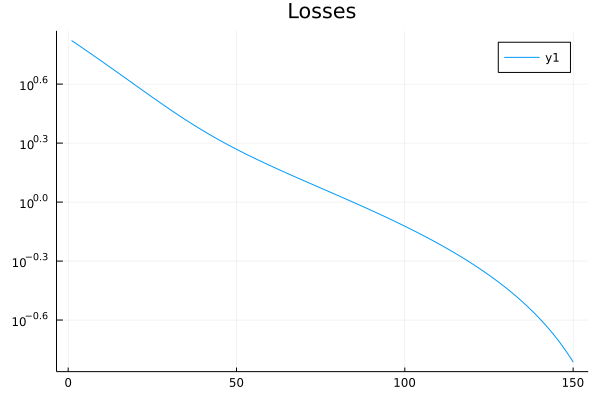

In [123]:
plot(losses, yaxis=:log, title="Losses")

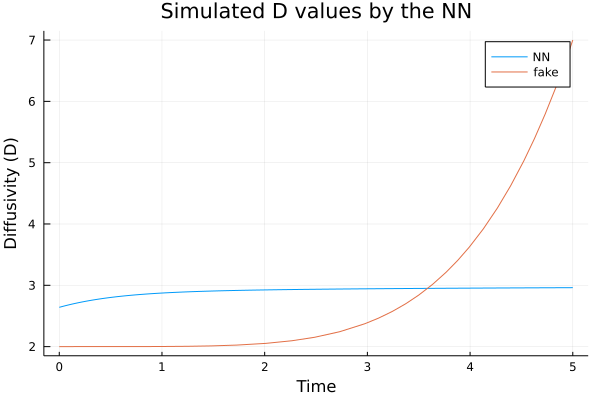

In [125]:
all_times = LinRange(0, t₁, 1000)
plot(all_times, UD_trained(all_times')', title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
plot!(fakeD, 0, t₁, label="fake")

In [ ]:
sqnorm(x) = sum(abs2, x)
sum(sqnorm, Flux.params(UD_trained))

In [ ]:
m = Chain(
  Dense(1, 2, relu),
  Dense(2, 1))

sqnorm(x) = sum(abs2, x)

ps = Flux.params(m)   # new line

loss(x, y) = Flux.Losses.logitcrossentropy(m(x), y) + sum(sqnorm, ps)

gradient(()->loss(rand(1), rand(1)), params(m))